# setup

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import numpy as np
import ast
import matplotlib.pyplot as plt
import scipy
import pickle
import pandas as pd
import seaborn as sns


In [5]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [7]:
muss_path = '/content/drive/MyDrive/muss'

In [8]:
!echo $muss_path

/content/drive/MyDrive/muss


In [9]:
%cd $muss_path

/content/drive/MyDrive/muss


In [10]:
!pwd

/content/drive/MyDrive/muss


In [11]:
pip install -e . &> /dev/null

In [12]:
%%capture
!pip install fairseq==0.10.2

In [13]:
from muss.simplifiers import get_fairseq_simplifier, get_preprocessed_simplifier
from muss.preprocessors import get_preprocessors, get_preprocessor_by_name
from easse.utils.helpers import read_lines

2021-09-25 14:18:34 | INFO | root | Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
2021-09-25 14:18:34 | INFO | root | Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt


In [14]:
def get_mean_confidence_interval(data, confidence=0.95):
    '''
    from https://github.com/facebookresearch/muss/blob/8b016942d9d0984866f6832594c049a189c1b46e/scripts/train_paper_models.py#L29
    '''

    data = np.array(data)
    a = 1.0 * data
    a = a[~np.isnan(a)]
    n = len(a)
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return h

## load named entities

In [15]:
import pickle
import pandas as pd

In [16]:
test_complex_df = pd.read_pickle("/content/drive/MyDrive/muss/test_complex_df_0825.pkl")

In [17]:
with open ('/content/drive/MyDrive/muss/qualitative/asset_test_df_0810.pkl', 'rb') as fp:
    test_simple_df = pickle.load(fp)

In [18]:
def find_num_appered_entity(NER_list,sentence):

  num_appered_entity = 0

  for NER in NER_list:
    if NER in sentence:
      num_appered_entity += 1

  return num_appered_entity


def get_NER_retain_portion(simple_or_complex,output_path):
  sentences = read_lines(output_path)

  if simple_or_complex=='simple':
    df = test_simple_df
  elif simple_or_complex=='complex':
    df = test_complex_df
  else:
    assert False, "please specify simple or complex"

  # store the index that has len(NER) != 0
  index_list = []
  NER_percentage_list = []

  for index, row in df.iterrows():
    if len(row['NER']) == 0:
      continue
    
    index_list.append(index)
    NER_num = find_num_appered_entity(row['NER'],sentences[index])

    NER_percentage = NER_num/len(row['NER'])

    NER_percentage_list.append(NER_percentage)

  df_output = pd.DataFrame(NER_percentage_list,columns=['NER_percent'])
  print(df_output['NER_percent'].describe())
  df_output['NER_percent'].value_counts().plot.bar()
  
  return np.mean(NER_percentage_list),np.std(NER_percentage_list)

In [19]:
with open ('/content/drive/MyDrive/muss/qualitative/asset_ABCD_valid_0911', 'rb') as fp:
    valid_complex_ABCD_df = pickle.load(fp)

with open ('/content/drive/MyDrive/muss/qualitative/asset_ABCD_test_0911', 'rb') as fp:
    test_complex_ABCD_df = pickle.load(fp)

In [20]:
def get_hard_word_retain_portion(phase,output_path):

  sentences = read_lines(output_path)

  if phase=='valid':
    df = valid_complex_ABCD_df
  elif phase=='test':
    df = test_complex_ABCD_df

  df = test_complex_ABCD_df
  
  NER_percentage_list = []

  for index, row in df.iterrows():
    if isinstance(row['C2C1B2_in_complex'],float):
      continue
    if len(row['C2C1B2_in_complex']) == 0:
      continue
    
    NER_num = find_num_appered_entity(row['C2C1B2_in_complex'],sentences[index])

    NER_percentage = NER_num/len(row['C2C1B2_in_complex'])

    NER_percentage_list.append(NER_percentage)

  df_output = pd.DataFrame(NER_percentage_list,columns=['hard_word_remain_percent'])
  print(df_output['hard_word_remain_percent'].describe())
  df_output['hard_word_remain_percent'].value_counts().plot.bar()
  
  return np.mean(NER_percentage_list),np.std(NER_percentage_list)

## define functions

In [21]:
!pip install sacrebleu==1.5.1

In [22]:
def easse_my_model_eval(output_id,generate_id,dataset,phase,output_file_name):

  pred_path = '/content/drive/MyDrive/muss/output/'+output_id+'/'+generate_id+'/'+output_file_name

  print('pred_path',pred_path)
  if phase=='valid':
    return os.popen("easse evaluate -t asset_valid -m 'bleu,sari,fkgl' -q < %s" %pred_path).read()
  elif phase=='test':
    return os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" %pred_path).read()

In [23]:
def evaluate_my_model(output_id,generate_id,dataset,phase,output_file_name,ABCD=False,muss=False,simple_or_complex=None):#,use_token=True,use_simple=False):
  
  if muss:
    result = ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" %output_id).read())
    print(result)

    if ABCD:
      NE_retain_mean,NE_retain_std = get_hard_word_retain_portion(phase,output_id)
    else:
      NE_retain_mean,NE_retain_std = get_NER_retain_portion(simple_or_complex,output_id)

    return result['bleu'], result['sari'], result['fkgl'],NE_retain_mean,NE_retain_std
  else:
    result = ast.literal_eval(easse_my_model_eval(output_id,generate_id,dataset,phase,output_file_name))

    print(result)
    print('model id:',output_id)
    print('dataset:',dataset)

    pred_path = '/content/drive/MyDrive/muss/output/'+output_id+'/'+generate_id+'/'+output_file_name

    if ABCD:
      NE_retain_mean,NE_retain_std = get_hard_word_retain_portion(phase,pred_path)
    else:
      NE_retain_mean,NE_retain_std = get_NER_retain_portion(simple_or_complex,pred_path)

    return result['bleu'], result['sari'], result['fkgl'],NE_retain_mean,NE_retain_std

In [24]:
def get_std(sari_list_list):
  calculated_std_list = []
  for i in range(np.array(sari_list_list).T.shape[0]):
      calculated_std_list.append(get_mean_confidence_interval(np.array(sari_list_list).T[i]))
  return calculated_std_list

In [25]:
def easse_my_model_eval_operation(output_id,generate_id,dataset,phase,output_file_name):

  pred_path = '/content/drive/MyDrive/muss/output/'+output_id+'/'+generate_id+'/'+output_file_name

  print('pred_path',pred_path)
  if phase=='valid':
    return os.popen("easse evaluate -t asset_valid -m 'sari_by_operation' -q < %s" %pred_path).read()
  elif phase=='test':
    return os.popen("easse evaluate -t asset_test -m 'sari_by_operation' -q < %s" %pred_path).read()

In [26]:
def evaluate_my_model_operation(output_id,generate_id,dataset,phase,output_file_name,ABCD=False,muss=False):#,use_token=True,use_simple=False):
  
  if muss:
    result = ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'sari_by_operation' -q < %s" %output_id).read())
    print(result)

    return result['sari_add'], result['sari_keep'], result['sari_del']
  else:
    result = ast.literal_eval(easse_my_model_eval_operation(output_id,generate_id,dataset,phase,output_file_name))

    print(result)
    
    print('model id:',output_id)
    print('dataset:',dataset)

    pred_path = '/content/drive/MyDrive/muss/output/'+output_id+'/'+generate_id+'/'+output_file_name

    return result['sari_add'], result['sari_keep'], result['sari_del']

# define data path for experiments of differnt Train and Parameter setting

## define test set path (simple)

In [58]:
DATA_DIR = '/content/drive/MyDrive/muss/resources/datasets/'

asset_valid_complex_dir =  DATA_DIR + f'token_asset_0803/valid.complex'
asset_test_complex_dir = DATA_DIR + f'token_asset_0803/test.complex'

asset_valid_simple_dir = DATA_DIR + f'token_asset_simple_NER_0810/valid.complex'
asset_test_simple_dir = DATA_DIR + f'token_asset_simple_NER_0810/test.complex'

asset_valid_all_no_random_dir = DATA_DIR + f'asset_simple_all_words_no_random_0825/valid.complex'
asset_test_all_no_random_dir = DATA_DIR + f'asset_simple_all_words_no_random_0825/test.complex'

asset_valid_all_random_dir = DATA_DIR + f'asset_simple_all_words_random_0825/valid.complex'
asset_test_all_random_dir = DATA_DIR + f'asset_simple_all_words_random_0825/test.complex'



In [59]:
complex_model_data_test_dir_list=[asset_test_complex_dir,asset_test_simple_dir]
complex_model_data_test_list=['asset.complex.test','asset.simple.test']

In [60]:
test_data_dir_list,test_data_list = [],[]

In [61]:
tmp_data_dir_list = []
tmp_data_list = []

for phase in ['test']:
  for i in range(7):
    path_name = 'asset_'+phase+'_'+str(i)+'_simple_dir'
    globals()[path_name] = DATA_DIR + f'asset_simple_'+str(i)+'NE_0825/'+phase+'.complex'

    tmp_data_dir_list.append(globals()[path_name])
    tmp_data_list.append('asset.'+str(i)+'.simple.'+phase)

In [62]:
test_data_dir_list.extend(tmp_data_dir_list)
test_data_list.extend(tmp_data_list)

In [63]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_simple_0NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_1NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_2NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_3NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_4NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_5NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_6NE_0825/test.complex']

In [64]:
test_data_list

['asset.0.simple.test',
 'asset.1.simple.test',
 'asset.2.simple.test',
 'asset.3.simple.test',
 'asset.4.simple.test',
 'asset.5.simple.test',
 'asset.6.simple.test']

In [65]:
test_data_dir_list.extend([
            asset_test_simple_dir,
             asset_test_complex_dir,
             asset_test_all_no_random_dir,
             asset_test_all_random_dir
             ]
)

test_data_list.extend([
            'asset.simple.test',
             'asset.complex.test',
             'asset.norandom.test',
             'asset.random.test',
             ]
)


In [66]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_simple_0NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_1NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_2NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_3NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_4NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_5NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_6NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/token_asset_simple_NER_0810/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/token_asset_0803/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_no_random_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_random_0825/test.complex']

In [67]:
test_data_list

['asset.0.simple.test',
 'asset.1.simple.test',
 'asset.2.simple.test',
 'asset.3.simple.test',
 'asset.4.simple.test',
 'asset.5.simple.test',
 'asset.6.simple.test',
 'asset.simple.test',
 'asset.complex.test',
 'asset.norandom.test',
 'asset.random.test']

In [68]:
#  x  asix is thing prepend to sentence
# NE from named entities detected in simple sentence

# mean of #NE is 3, so increase lateern atfetr 3
test_data_explain_list = ['0 NE at simple',
                          '1 NE at simple',
                          '2 NE at simple',
                          '3 NE at simple',
                          '4 NE at simple',
                          '5 NE at simple',
                          '6 NE at simple',
                          'all NE at simple',
                          'all NE at complex',
                          'all at simple',
                          'all at simple shuffled',
                          ]

## define test set path (complex)

In [ ]:
DATA_DIR = '/content/drive/MyDrive/muss/resources/datasets/'


complex_asset_valid_all_no_random_dir = DATA_DIR + f'asset_complex_all_words_0828/valid.complex'
complex_asset_test_all_no_random_dir = DATA_DIR + f'asset_complex_all_words_0828/test.complex'

complex_asset_valid_all_random_dir = DATA_DIR + f'asset_complex_all_words_random_0828/valid.complex'
complex_asset_test_all_random_dir = DATA_DIR + f'asset_complex_all_words_random_0828/test.complex'



In [ ]:
test_data_dir_list,test_data_list = [],[]

In [ ]:
tmp_data_dir_list = []
tmp_data_list = []

for phase in ['test']:
  for i in range(7):
    path_name = 'asset_'+phase+'_'+str(i)+'_complex_dir'
    globals()[path_name] = DATA_DIR + f'asset_complex_'+str(i)+'NE_0828/'+phase+'.complex'

    tmp_data_dir_list.append(globals()[path_name])
    tmp_data_list.append('asset.'+str(i)+'.complex.'+phase)

In [ ]:
test_data_dir_list.extend(tmp_data_dir_list)
test_data_list.extend(tmp_data_list)

In [ ]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_complex_0NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_1NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_2NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_3NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_4NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_5NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_6NE_0828/test.complex']

In [ ]:
test_data_list

['asset.0.complex.test',
 'asset.1.complex.test',
 'asset.2.complex.test',
 'asset.3.complex.test',
 'asset.4.complex.test',
 'asset.5.complex.test',
 'asset.6.complex.test']

In [ ]:
test_data_dir_list.extend([

            complex_asset_test_all_no_random_dir,
             complex_asset_test_all_random_dir
             ]
)

test_data_list.extend([

            'asset.complex.all.test',
             'asset.complex.allrandom.test',
             ]
)


In [ ]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_complex_0NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_1NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_2NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_3NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_4NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_5NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_6NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/token_asset_0803/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_all_words_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_all_words_random_0828/test.complex']

In [ ]:
test_data_list

['asset.0.complex.test',
 'asset.1.complex.test',
 'asset.2.complex.test',
 'asset.3.complex.test',
 'asset.4.complex.test',
 'asset.5.complex.test',
 'asset.6.complex.test',
 'asset.complex.test',
 'asset.complex.all.test',
 'asset.complex.allrandom.test']

In [ ]:
test_data_explain_list=['0 NE at complex',
 '1 NE at complex',
 '2 NE at complex',
 '3 NE at complex',
 '4 NE at complex',
 '5 NE at complex',
 '6 NE at complex',
 'all words at complex',
 'all words at complex shuffled']

## define test set path complex & simple

In [ ]:
DATA_DIR = '/content/drive/MyDrive/muss/resources/datasets/'

# complex 
asset_valid_complex_dir =  DATA_DIR + f'token_asset_0803/valid.complex'
asset_test_complex_dir = DATA_DIR + f'token_asset_0803/test.complex'

complex_asset_valid_all_no_random_dir = DATA_DIR + f'asset_complex_all_words_0828/valid.complex'
complex_asset_test_all_no_random_dir = DATA_DIR + f'asset_complex_all_words_0828/test.complex'

complex_asset_valid_all_random_dir = DATA_DIR + f'asset_complex_all_words_random_0828/valid.complex'
complex_asset_test_all_random_dir = DATA_DIR + f'asset_complex_all_words_random_0828/test.complex'



In [ ]:

asset_valid_simple_dir = DATA_DIR + f'token_asset_simple_NER_0810/valid.complex'
asset_test_simple_dir = DATA_DIR + f'token_asset_simple_NER_0810/test.complex'

asset_valid_all_no_random_dir = DATA_DIR + f'asset_simple_all_words_no_random_0825/valid.complex'
asset_test_all_no_random_dir = DATA_DIR + f'asset_simple_all_words_no_random_0825/test.complex'

asset_valid_all_random_dir = DATA_DIR + f'asset_simple_all_words_random_0825/valid.complex'
asset_test_all_random_dir = DATA_DIR + f'asset_simple_all_words_random_0825/test.complex'



In [ ]:
test_data_dir_list,test_data_list = [],[]

In [ ]:
tmp_data_dir_list = []
tmp_data_list = []

for phase in ['test']:
  for i in range(7):
    path_name = 'asset_'+phase+'_'+str(i)+'_complex_dir'
    globals()[path_name] = DATA_DIR + f'asset_complex_'+str(i)+'NE_0828/'+phase+'.complex'

    tmp_data_dir_list.append(globals()[path_name])
    tmp_data_list.append('asset.'+str(i)+'.complex.'+phase)

In [ ]:
test_data_dir_list.extend(tmp_data_dir_list)
test_data_list.extend(tmp_data_list)

In [ ]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_complex_0NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_1NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_2NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_3NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_4NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_5NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_6NE_0828/test.complex']

In [ ]:
test_data_list

['asset.0.complex.test',
 'asset.1.complex.test',
 'asset.2.complex.test',
 'asset.3.complex.test',
 'asset.4.complex.test',
 'asset.5.complex.test',
 'asset.6.complex.test']

In [ ]:
test_data_dir_list.extend([
                           asset_test_complex_dir,

             ]
)

test_data_list.extend([
                       'asset.allNE.complex.test'

             ]
)


In [ ]:

for phase in ['test']:
  for i in range(7):
    path_name = 'asset_'+phase+'_'+str(i)+'_simple_dir'
    globals()[path_name] = DATA_DIR + f'asset_simple_'+str(i)+'NE_0825/'+phase+'.complex'

    test_data_dir_list.append(globals()[path_name])
    test_data_list.append('asset.'+str(i)+'.simple.'+phase)

In [ ]:
test_data_dir_list.extend([
            asset_test_simple_dir,
            complex_asset_test_all_no_random_dir,
             complex_asset_test_all_random_dir,
             asset_test_all_no_random_dir,
             asset_test_all_random_dir
             ]
)

test_data_list.extend([
            'asset.simple.test',
            'asset.complex.all.test',
             'asset.complex.allrandom.test',
             'asset.norandom.test',
             'asset.random.test',
             ]
)


In [ ]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_complex_0NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_1NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_2NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_3NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_4NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_5NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_complex_6NE_0828/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/token_asset_0803/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_0NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_1NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_simple_2NE_0825/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/ass

In [ ]:
test_data_list

['asset.0.complex.test',
 'asset.1.complex.test',
 'asset.2.complex.test',
 'asset.3.complex.test',
 'asset.4.complex.test',
 'asset.5.complex.test',
 'asset.6.complex.test',
 'asset.allNE.complex.test',
 'asset.0.simple.test',
 'asset.1.simple.test',
 'asset.2.simple.test',
 'asset.3.simple.test',
 'asset.4.simple.test',
 'asset.5.simple.test',
 'asset.6.simple.test',
 'asset.simple.test',
 'asset.complex.all.test',
 'asset.complex.allrandom.test',
 'asset.norandom.test',
 'asset.random.test']

In [ ]:
test_data_explain_list=['0 NE at complex',
 '1 NE at complex',
 '2 NE at complex',
 '3 NE at complex',
 '4 NE at complex',
 '5 NE at complex',
 '6 NE at complex',
 'all NE at complex',

 '0 NE at simple',
 '1 NE at simple',
 '2 NE at simple',
 '3 NE at simple',
 '4 NE at simple',
 '5 NE at simple',
 '6 NE at simple',
 'all NE at simple',

 'all words at complex',
 'all words at complex shuffled',

 'all words at simple',
 'all words at simple shuffled',
 
 ]

## define test set path CERF

In [ ]:
DATA_DIR = '/content/drive/MyDrive/muss/resources/datasets/'

asset_valid_all_ABCDword_dir = DATA_DIR + f'asset_ABCD_C1C2B2/valid.complex'
asset_test_all_ABCDword_dir = DATA_DIR + f'asset_ABCD_C1C2B2/test.complex'

asset_valid_all_no_random_dir = DATA_DIR + f'asset_ABCD_all_words_0911/valid.complex'
asset_test_all_no_random_dir = DATA_DIR + f'asset_ABCD_all_words_0911/test.complex'

asset_valid_all_random_dir = DATA_DIR + f'asset_ABCD_all_words_random_0911/valid.complex'
asset_test_all_random_dir = DATA_DIR + f'asset_ABCD_all_words_random_0911/test.complex'



In [ ]:
test_data_dir_list,test_data_list = [],[]

In [ ]:
tmp_data_dir_list = []
tmp_data_list = []

for phase in ['test']:
  for i in range(7):
    path_name = 'asset_'+phase+'_'+str(i)+'_complex_dir'
    globals()[path_name] = DATA_DIR + f'asset_ABCD_'+str(i)+'words_0911/'+phase+'.complex'

    tmp_data_dir_list.append(globals()[path_name])
    tmp_data_list.append('asset.'+str(i)+'.ABCD.'+phase)

In [ ]:
test_data_dir_list.extend(tmp_data_dir_list)
test_data_list.extend(tmp_data_list)

In [ ]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_0words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_1words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_2words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_3words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_4words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_5words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_6words_0911/test.complex']

In [ ]:
test_data_list

['asset.0.ABCD.test',
 'asset.1.ABCD.test',
 'asset.2.ABCD.test',
 'asset.3.ABCD.test',
 'asset.4.ABCD.test',
 'asset.5.ABCD.test',
 'asset.6.ABCD.test']

In [ ]:
test_data_dir_list.extend([
                           asset_test_all_ABCDword_dir,
                           asset_test_all_no_random_dir,
                           asset_test_all_random_dir
            
             ]
)

test_data_list.extend([
            'asset.allABCD.ABCD.test',
             'asset.allwords.ABCD.test',
             'asset.allwordsrandom.ABCD.test',
             ]
)


In [ ]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_0words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_1words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_2words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_3words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_4words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_5words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_6words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_C1C2B2/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_all_words_0911/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_all_words_random_0911/test.complex']

In [ ]:
test_data_list

['asset.0.ABCD.test',
 'asset.1.ABCD.test',
 'asset.2.ABCD.test',
 'asset.3.ABCD.test',
 'asset.4.ABCD.test',
 'asset.5.ABCD.test',
 'asset.6.ABCD.test',
 'asset.allABCD.ABCD.test',
 'asset.allwords.ABCD.test',
 'asset.allwordsrandom.ABCD.test']

In [ ]:
test_data_explain_list=[
                        '0 hard word',
                        '1 hard word',
                        '2 hard word',
                        '3 hard word',
                        '4 hard word',
                        '5 hard word',
                        '6 hard word',
                        'all hard word',
                        'all word',
                        'all word shuffled',

]

## define test set path Named Entities + CERF

In [66]:
DATA_DIR = '/content/drive/MyDrive/muss/resources/datasets/'

asset_valid_all_all_dir = DATA_DIR + f'asset_ABCD_NER/valid.complex'
asset_test_all_all_dir = DATA_DIR + f'asset_ABCD_NER/test.complex'



In [67]:
test_data_dir_list,test_data_list = [],[]

In [68]:
tmp_data_dir_list = []
tmp_data_list = []

for i in range(7):
  path_name = 'asset_ABCD_NER_fix_CERF_'+str(i)+'NE_dir'
  globals()[path_name] = DATA_DIR+'asset_ABCD_NER_fix_CERF_'+str(i)+'NE/test.complex'

  tmp_data_dir_list.append(globals()[path_name])
  tmp_data_list.append('asset.allCERF.'+str(i)+'NE')

In [69]:
test_data_dir_list.extend(tmp_data_dir_list)
test_data_list.extend(tmp_data_list)

In [70]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_0NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_1NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_2NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_3NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_4NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_5NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_6NE/test.complex']

In [71]:
test_data_list

['asset.allCERF.0NE',
 'asset.allCERF.1NE',
 'asset.allCERF.2NE',
 'asset.allCERF.3NE',
 'asset.allCERF.4NE',
 'asset.allCERF.5NE',
 'asset.allCERF.6NE']

In [72]:
tmp_data_dir_list = []
tmp_data_list = []

for i in range(7):
  path_name = 'asset_ABCD_NER_fix_NE_'+str(i)+'CERF_dir'
  globals()[path_name] = DATA_DIR+'asset_ABCD_NER_fix_NE_'+str(i)+'CERF/test.complex'

  tmp_data_dir_list.append(globals()[path_name])
  tmp_data_list.append('asset.allNE.'+str(i)+'CERF')

In [73]:
test_data_dir_list.extend(tmp_data_dir_list)
test_data_list.extend(tmp_data_list)

In [74]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_0NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_1NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_2NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_3NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_4NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_5NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_6NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_0CERF/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_1CERF/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_2CERF/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_3CERF/tes

In [75]:
test_data_list

['asset.allCERF.0NE',
 'asset.allCERF.1NE',
 'asset.allCERF.2NE',
 'asset.allCERF.3NE',
 'asset.allCERF.4NE',
 'asset.allCERF.5NE',
 'asset.allCERF.6NE',
 'asset.allNE.0CERF',
 'asset.allNE.1CERF',
 'asset.allNE.2CERF',
 'asset.allNE.3CERF',
 'asset.allNE.4CERF',
 'asset.allNE.5CERF',
 'asset.allNE.6CERF']

In [76]:
test_data_dir_list.extend([
                           asset_test_all_all_dir
            
             ]
)

test_data_list.extend([
            'asset.allNE.allCERF',

             ]
)


In [77]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_0NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_1NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_2NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_3NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_4NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_5NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_6NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_0CERF/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_1CERF/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_2CERF/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_3CERF/tes

In [78]:
test_data_list

['asset.allCERF.0NE',
 'asset.allCERF.1NE',
 'asset.allCERF.2NE',
 'asset.allCERF.3NE',
 'asset.allCERF.4NE',
 'asset.allCERF.5NE',
 'asset.allCERF.6NE',
 'asset.allNE.0CERF',
 'asset.allNE.1CERF',
 'asset.allNE.2CERF',
 'asset.allNE.3CERF',
 'asset.allNE.4CERF',
 'asset.allNE.5CERF',
 'asset.allNE.6CERF',
 'asset.allNE.allCERF']

In [79]:
test_data_explain_list=[
'0 NE, all hard words',
'1 NE, all hard words',
'2 NE, all hard words',
'3 NE, all hard words',
'4 NE, all hard words',
'5 NE, all hard words',
'6 NE, all hard words',
'all NE, 0 hard words',
'all NE, 1 hard words',
'all NE, 2 hard words',
'all NE, 3 hard words',
'all NE, 4 hard words',
'all NE, 5 hard words',
'all NE, 6 hard words',
'all NE, all hard words',
]

# model info dictionary

In [13]:
MODEL_DIR = '/content/drive/MyDrive/muss/experiments/fairseq/'

In [14]:
model_dir_dict = {}

def add_item_to_dict(**kwargs):

  id = len(model_dir_dict)
  model_dir_dict[id]={}

  for key, value in kwargs.items():
    model_dir_dict[id][key]=value
  print('added:',model_dir_dict[id])

In [15]:
add_item_to_dict(model_id=len(model_dir_dict),exp_dir='/content/drive/MyDrive/muss/resources/models/bart_mined',model_name='bart_mined')

added: {'model_id': 0, 'exp_dir': '/content/drive/MyDrive/muss/resources/models/bart_mined', 'model_name': 'bart_mined'}


In [16]:
add_item_to_dict(model_id=len(model_dir_dict),exp_dir='/content/drive/MyDrive/muss/resources/models/bart_mined_wikilarge',model_name='bart_mined_wikilarge',preprocessors_kwargs = {
        'LengthRatioPreprocessor': {'target_ratio': 0.9, 'use_short_name': False},
        'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.65, 'use_short_name': False},
        'WordRankRatioPreprocessor': {'target_ratio': 0.75, 'language': 'en', 'use_short_name': False},
        'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.4, 'language': 'en', 'use_short_name': False},
    })

added: {'model_id': 1, 'exp_dir': '/content/drive/MyDrive/muss/resources/models/bart_mined_wikilarge', 'model_name': 'bart_mined_wikilarge', 'preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.9, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.65, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.75, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.4, 'language': 'en', 'use_short_name': False}}}


In [17]:
add_item_to_dict(model_id=len(model_dir_dict),
                #  exp_dir=MODEL_DIR+'local_1626908793158/',
                #  model_name='bart_wikilarge_wo_token',
                #  info=
                #  '''
                #  training not completed. 
                #  use original code.
                #  use detoken wikilarge data. i.e. no NER token added.
                #  use_asset=True.
                #  load bart.large.
                #  '''
                 )

added: {'model_id': 2}


In [19]:
add_item_to_dict(model_id=len(model_dir_dict),
                #  exp_dir=MODEL_DIR+'local_1627676101775/',
                #  model_name='bart_change_all_data',
                #  info=
                #  '''
                #  training not completed. 
                #  train, test, valid data: NER added wikilarge data.
                #  use_asset=True.
                #  load bart.large.
                #  '''
                 )

added: {'model_id': 3}


In [20]:
add_item_to_dict(model_id=len(model_dir_dict),
                #  exp_dir=MODEL_DIR+'local_1627757030330/', 
                #  model_name='bart_change_all_data',
                #  info=
                #  '''
                #  training completed.
                #  scores={'bleu': 76.51763175185911, 'sari': 44.9886054760627, 'fkgl': 6.2702108605400255}!!(should rerun using predict_file=asset_token)
                #  train, test, valid data: NER added wikilarge data.
                #  use_asset=True.
                #  load bart.large.
                #  continue train on local_1627676101775/checkpoints/checkpoint_6_3200.pt
                #  ''',
                #  recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.8183618791572886, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7897938410469331, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8047148154836818, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.7532679172898086, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}
                 )

added: {'model_id': 4}


In [21]:
add_item_to_dict(model_id=len(model_dir_dict),
                #  exp_dir=MODEL_DIR+'local_1627767953241/',
                #  model_name='muss_change_all_data',
                #  info=
                #  '''
                #  training not completed. 
                #  train, test, valid data: NER added wikilarge data.
                #  use_asset=True.
                #  load muss_mined.
                #  ''',
                #  train_args=
                #  '''
                #  fairseq-train /content/drive/MyDrive/muss/resources/datasets/_59df15dce93dacacb2a9ada082637f1e/fairseq_preprocessed_complex-simple --task translation --source-lang complex --target-lang simple --save-dir /content/drive/MyDrive/muss/experiments/fairseq/local_1627767953241/checkpoints --optimizer adam --adam-betas '(0.9, 0.98)' --clip-norm 0.0 --criterion label_smoothed_cross_entropy --label-smoothing 0.1 --lr-scheduler polynomial_decay --lr 3e-05 --warmup-updates 500 --update-freq 128 --arch bart_large --dropout 0.1 --weight-decay 0.0 --clip-norm 0.1 --share-all-embeddings --no-epoch-checkpoints --save-interval 999999 --validate-interval 999999 --max-update 20000 --save-interval-updates 100 --keep-interval-updates 1 --patience 10 --batch-size 64 --seed 555 --distributed-world-size 1 --distributed-port 16491 --fp16 --restore-file '/content/drive/MyDrive/muss/resources/models/bart_mined/model.pt' --max-tokens 512 --truncate-source --layernorm-embedding --share-all-embeddings --share-decoder-input-output-embed --reset-optimizer --reset-dataloader --reset-meters --required-batch-size-multiple 1 --label-smoothing 0.1 --attention-dropout 0.1 --weight-decay 0.01 --optimizer 'adam' --adam-betas '(0.9, 0.999)' --adam-eps 1e-08 --clip-norm 0.1 --skip-invalid-size-inputs-valid-test --find-unused-parameters
                #  '''
                 )



added: {'model_id': 5}


In [22]:
add_item_to_dict(model_id=len(model_dir_dict),
#                  exp_dir=MODEL_DIR+'local_1627838987960/', THIS AND BEFORE DELETED
#                  model_name='muss_change_all_data',
#                  info=
#                  '''
#                  train complete.
#                  scores={'bleu': 80.62918711490221, 'sari': 44.16175529588565, 'fkgl': 7.079753954439823}(predict file used asset_token.)
#                  train, test, valid data: NER added wikilarge data.
#                  use_asset=True.
#                  load muss_mined.
#                  ''',
#                  recommended_preprocessors_kwargs={'DependencyTreeDepthRatioPreprocessor': {'language': 'en',
#   'target_ratio': 0.8937919408369409,
#   'use_short_name': False},
#  'GPT2BPEPreprocessor': {},
#  'LengthRatioPreprocessor': {'target_ratio': 0.8625830047202065,
#   'use_short_name': False},
#  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8706196758216501,
#   'use_short_name': False},
#  'WordRankRatioPreprocessor': {'language': 'en',
#   'target_ratio': 0.9829037295830106,
#   'use_short_name': False}}
  )



added: {'model_id': 6}


In [23]:
add_item_to_dict(model_id=len(model_dir_dict),
                #  exp_dir=MODEL_DIR+'local_1628033181968/',
                #  model_name='muss_1',
                #  info=
                #  '''
                #  train complete
                #  # complex NE
                #  train, test, valid data: NER added wikilarge data.
                #  1. changed dictionaru
                # 2. changed extract special token
                # 3. changed train kwargs
                # 4.muss/evaluation\general 2 function changed 
                # 5.muss/fairseq/base train arg
                #  use_asset=True.
                #  load muss_mined.
                #  ''',
                #  recommended_preprocessors_kwargs=
                #  {'LengthRatioPreprocessor': {'target_ratio': 0.9013845768472064, 'use_short_name': False}, 
                #   'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8412439617313068, 'use_short_name': False}, 
                #   'WordRankRatioPreprocessor': {'target_ratio': 0.945465089807053, 'language': 'en', 'use_short_name': False}, 
                #   'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.3179728920946812, 'language': 'en', 'use_short_name': False}, 
                #   'GPT2BPEPreprocessor': {}}
                 )



added: {'model_id': 7}


In [24]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628299139742/',
                 model_name='muss_train_use_target_NER',
                 info=
                 '''
                 train complete
                 train,test, valid: insert target NER into source.
                 1. changed dictionary
                2. changed extract special token
                3. changed train kwargs
                4.muss/evaluation\general 2 function changed 
                5.muss/fairseq/base train arg
                 use_asset=True.
                 load muss_mined.
                 token_data_wikilarge_0807
                 ''',
                 # use source NE
                 recommended_preprocessors_kwargs=
                 {'LengthRatioPreprocessor': {'target_ratio': 0.9232791040422811, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7547104722847939, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 0.8384149385346878, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.45741492410366896, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}
                 )

# use clean target NE
# # recommended_preprocessors_kwargs=
# {'LengthRatioPreprocessor': {'target_ratio': 0.909607027613668, 'use_short_name': False}, 
#  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8162749783306084, 'use_short_name': False}, 
#  'WordRankRatioPreprocessor': {'target_ratio': 0.5462451568701605, 'language': 'en', 'use_short_name': False}, 
#  'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.3694423178221648, 'language': 'en', 'use_short_name': False}, 
#  'GPT2BPEPreprocessor': {}}

added: {'model_id': 8, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628299139742/', 'model_name': 'muss_train_use_target_NER', 'info': '\n                 train complete\n                 train,test, valid: insert target NER into source.\n                 1. changed dictionary\n                2. changed extract special token\n                3. changed train kwargs\n                4.muss/evaluation\\general 2 function changed \n                5.muss/fairseq/base train arg\n                 use_asset=True.\n                 load muss_mined.\n                 token_data_wikilarge_0807\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.9232791040422811, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7547104722847939, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8384149385346878, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioP

In [25]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628356825356/',
                 model_name='muss_train_use_co_occur_NER',
                 info=
                 '''
                 train complete
                 train: insert NER that is both in target and source.
                test, valid data: unchanged wikilarge. NER is from source.
                 use_asset=True.
                 load muss_mined.
                 token_data_wikilarge_0807_cooccur
                 ''',
                 
                 )



added: {'model_id': 9, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628356825356/', 'model_name': 'muss_train_use_co_occur_NER', 'info': '\n                 train complete\n                 train: insert NER that is both in target and source.\n                test, valid data: unchanged wikilarge. NER is from source.\n                 use_asset=True.\n                 load muss_mined.\n                 token_data_wikilarge_0807_cooccur\n                 '}


In [26]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628357063986/',
                 model_name='muss_no_NER',
                 info=
                 '''
                 train complete
                 train: insert NER that is both in target and source.
                test, valid data: unchanged wikilarge. NER is from source.
                 use_asset=True.
                 load muss_mined.
                 token_data_wikilarge_0807_no_NER
                 ''',
                 recommended_preprocessors_kwargs=
                 {'LengthRatioPreprocessor': {'target_ratio': 0.671471662548423, 'use_short_name': False}, 
                  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7899616811007996, 'use_short_name': False}, 
                  'WordRankRatioPreprocessor': {'target_ratio': 0.40813050670938067, 'language': 'en', 'use_short_name': False}, 
                  'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.791613961476961, 'language': 'en', 'use_short_name': False}, 
                  'GPT2BPEPreprocessor': {}}

                 )




added: {'model_id': 10, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628357063986/', 'model_name': 'muss_no_NER', 'info': '\n                 train complete\n                 train: insert NER that is both in target and source.\n                test, valid data: unchanged wikilarge. NER is from source.\n                 use_asset=True.\n                 load muss_mined.\n                 token_data_wikilarge_0807_no_NER\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.671471662548423, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7899616811007996, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.40813050670938067, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.791613961476961, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [27]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628299139742/',
                 model_name='muss_train_use_target_NER',
                 info=
                 '''
                 train complete
                 train: insert target sentence NER into source.
                test, valid data: unchanged wikilarge. NER is from source.
                 1. changed dictionary
                2. changed extract special token
                3. changed train kwargs
                4.muss/evaluation\general 2 function changed 
                5.muss/fairseq/base train arg
                 use_asset=True.
                 load muss_mined.
                 token_data_wikilarge_0807
                 ''',
                 # use clean target NE
                 recommended_preprocessors_kwargs=
                 {'LengthRatioPreprocessor': {'target_ratio': 0.909607027613668, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8162749783306084, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 0.5462451568701605, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.3694423178221648, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}
                 )

# use clean target NE
# # recommended_preprocessors_kwargs=
# {'LengthRatioPreprocessor': {'target_ratio': 0.909607027613668, 'use_short_name': False}, 
#  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8162749783306084, 'use_short_name': False}, 
#  'WordRankRatioPreprocessor': {'target_ratio': 0.5462451568701605, 'language': 'en', 'use_short_name': False}, 
#  'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.3694423178221648, 'language': 'en', 'use_short_name': False}, 
#  'GPT2BPEPreprocessor': {}}

added: {'model_id': 11, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628299139742/', 'model_name': 'muss_train_use_target_NER', 'info': '\n                 train complete\n                 train: insert target sentence NER into source.\n                test, valid data: unchanged wikilarge. NER is from source.\n                 1. changed dictionary\n                2. changed extract special token\n                3. changed train kwargs\n                4.muss/evaluation\\general 2 function changed \n                5.muss/fairseq/base train arg\n                 use_asset=True.\n                 load muss_mined.\n                 token_data_wikilarge_0807\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.909607027613668, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8162749783306084, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.546245156870160

In [28]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628632701978/',
                 model_name='muss_complex_0810',
                 dataset='token_complex_wikilarge_0810',
                 info=
                 '''
                 train complete
                 train,test,valid
                 use_asset=True.
                 load muss_mined.
                 ''',
                 # source NE

                 )



added: {'model_id': 12, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628632701978/', 'model_name': 'muss_complex_0810', 'dataset': 'token_complex_wikilarge_0810', 'info': '\n                 train complete\n                 train,test,valid\n                 use_asset=True.\n                 load muss_mined.\n                 '}


In [29]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628632701978/',
                 model_name='muss_complex_0810',
                 dataset='token_complex_wikilarge_0810',
                 info=
                 '''
                 train complete
                 train,test,valid
                 use_asset=True.
                 load muss_mined.
                 ''',
                 # target NE
                 
                 )



added: {'model_id': 13, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628632701978/', 'model_name': 'muss_complex_0810', 'dataset': 'token_complex_wikilarge_0810', 'info': '\n                 train complete\n                 train,test,valid\n                 use_asset=True.\n                 load muss_mined.\n                 '}


In [30]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628635148170/',
                 model_name='muss_co_occur_0810', # clean
                 dataset='token_data_wikilarge_0810_cooccur',
                 info=
                 '''
                 train complete
                 train,test,valid: insert NER that is both in target and source.
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  soruce NE
                 # cluster
                 recommended_preprocessors_kwargs=
                 {'LengthRatioPreprocessor': 
                  {'target_ratio': 0.7106468975998875, 'use_short_name': False}, 
                  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7209310103866642, 'use_short_name': False}, 
                  'WordRankRatioPreprocessor': {'target_ratio': 0.6883820678495148, 'language': 'en', 'use_short_name': False},
                  'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.22377179007596412, 'language': 'en', 'use_short_name': False}, 
                  'GPT2BPEPreprocessor': {}}
                 )



added: {'model_id': 14, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628635148170/', 'model_name': 'muss_co_occur_0810', 'dataset': 'token_data_wikilarge_0810_cooccur', 'info': '\n                 train complete\n                 train,test,valid: insert NER that is both in target and source.\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.7106468975998875, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7209310103866642, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.6883820678495148, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.22377179007596412, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [31]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628635148170/',
                 model_name='muss_co_occur_0810', # clean
                 dataset='token_data_wikilarge_0810_cooccur',
                 info=
                 '''
                 train complete
                 train,test,valid: insert NER that is both in target and source.
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  target NE
                recommended_preprocessors_kwargs=
                 {'LengthRatioPreprocessor': {'target_ratio': 1.0420012310744888, 'use_short_name': False}, 
                  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7158657422607126, 'use_short_name': False}, 
                  'WordRankRatioPreprocessor': {'target_ratio': 0.5760708375407306, 'language': 'en', 'use_short_name': False}, 
                  'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.21329612191393035, 'language': 'en', 'use_short_name': False}, 
                  'GPT2BPEPreprocessor': {}}
                 )



added: {'model_id': 15, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628635148170/', 'model_name': 'muss_co_occur_0810', 'dataset': 'token_data_wikilarge_0810_cooccur', 'info': '\n                 train complete\n                 train,test,valid: insert NER that is both in target and source.\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.0420012310744888, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7158657422607126, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.5760708375407306, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.21329612191393035, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [32]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628718821939/',
                 model_name='muss_simple_0810', # clean
                 dataset='token_simple_wikilarge_0810',
                 info=
                 '''
                 train complete
                 train,test,valid: insert NER that is both in target and source.
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  source NE
                recommended_preprocessors_kwargs=
                 {'LengthRatioPreprocessor': {'target_ratio': 0.8745775160578683, 'use_short_name': False}, 
                  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8184146111849491, 'use_short_name': False}, 
                  'WordRankRatioPreprocessor': {'target_ratio': 0.8301636377664322, 'language': 'en', 'use_short_name': False}, 
                  'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.574831422440179, 'language': 'en', 'use_short_name': False}, 
                  'GPT2BPEPreprocessor': {}}
                 )



added: {'model_id': 16, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628718821939/', 'model_name': 'muss_simple_0810', 'dataset': 'token_simple_wikilarge_0810', 'info': '\n                 train complete\n                 train,test,valid: insert NER that is both in target and source.\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.8745775160578683, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8184146111849491, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8301636377664322, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.574831422440179, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [33]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1628718821939/',
                 model_name='muss_simple_0810', # clean
                 dataset='token_simple_wikilarge_0810',
                 info=
                 '''
                 train complete
                 train,test,valid: insert NER that is both in target and source.
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  target NE

                 )



added: {'model_id': 17, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628718821939/', 'model_name': 'muss_simple_0810', 'dataset': 'token_simple_wikilarge_0810', 'info': '\n                 train complete\n                 train,test,valid: insert NER that is both in target and source.\n                 use_asset=True.\n                 load muss_mined.\n                 '}


In [34]:
#############################
# 0825

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1629593348299/',
                 model_name='muss_complex_0822', # delete simple sentence not contain '.', and any of word in simple not in complex
                 dataset='wikilarge_final_complex_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # complex NE
                 recommended_preprocessors_kwargs={
                     'LengthRatioPreprocessor': {'target_ratio': 0.956836653713281, 'use_short_name': False}, 
                     'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7285203296261804, 'use_short_name': False}, 
                     'WordRankRatioPreprocessor': {'target_ratio': 0.77610910374061, 'language': 'en', 'use_short_name': False}, 
                     'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.33930538813771477, 'language': 'en', 'use_short_name': False}, 
                     'GPT2BPEPreprocessor': {}}

                 )



added: {'model_id': 18, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629593348299/', 'model_name': 'muss_complex_0822', 'dataset': 'wikilarge_final_complex_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.956836653713281, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7285203296261804, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.77610910374061, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.33930538813771477, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [35]:
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1629593348299/',
                 model_name='muss_complex_0822', # delete simple sentence not contain '.', and any of word in simple not in complex
                 dataset='wikilarge_final_complex_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # simple NE
                 
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 0.9700595349762818, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.81504274123193, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 0.8269654939477459, 'language': 'en', 'use_short_name': False},
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.29353456265546596, 'language': 'en', 'use_short_name': False},
 'GPT2BPEPreprocessor': {}}
                 )



added: {'model_id': 19, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629593348299/', 'model_name': 'muss_complex_0822', 'dataset': 'wikilarge_final_complex_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.9700595349762818, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.81504274123193, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8269654939477459, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.29353456265546596, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [36]:
# 0825

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1629593322552/',
                 model_name='muss_simple_0822', # delete simple sentence not contain '.', and any of word in simple not in complex
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # complex NE
                 recommended_preprocessors_kwargs=
                 {'LengthRatioPreprocessor': {'target_ratio': 0.9489030771756881, 'use_short_name': False}, 
                  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8512708177758973, 'use_short_name': False}, 
                  'WordRankRatioPreprocessor': {'target_ratio': 0.4332282006330827, 'language': 'en', 'use_short_name': False}, 
                  'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.48180181825919544, 'language': 'en', 'use_short_name': False}, 
                  'GPT2BPEPreprocessor': {}}
                 )



added: {'model_id': 20, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629593322552/', 'model_name': 'muss_simple_0822', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.9489030771756881, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8512708177758973, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.4332282006330827, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.48180181825919544, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [37]:
# 0825

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1629593322552/',
                 model_name='muss_simple_0822', # delete simple sentence not contain '.', and any of word in simple not in complex
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # simple NE
                 recommended_preprocessors_kwargs=
                 {'LengthRatioPreprocessor': {'target_ratio': 0.9027911048335139, 'use_short_name': False}, 
                  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8490285416814356, 'use_short_name': False}, 
                  'WordRankRatioPreprocessor': {'target_ratio': 0.823359682206033, 'language': 'en', 'use_short_name': False},
                  'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.41809516782054756, 'language': 'en', 'use_short_name': False}, 
                  'GPT2BPEPreprocessor': {}}
                 )



added: {'model_id': 21, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629593322552/', 'model_name': 'muss_simple_0822', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.9027911048335139, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8490285416814356, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.823359682206033, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.41809516782054756, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [38]:
# 0825

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1629750798219/',
                 model_name='muss_cooc_0822', # delete simple sentence not contain '.', and any of word in simple not in complex
                 dataset='wikilarge_cooc_0823',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # complex NE
                 recommended_preprocessors_kwargs=
                 {'LengthRatioPreprocessor': {'target_ratio': 0.835076952260348, 'use_short_name': False}, 
                  'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8358750604197434, 'use_short_name': False}, 
                  'WordRankRatioPreprocessor': {'target_ratio': 0.9409659060288595, 'language': 'en', 'use_short_name': False},
                  'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.621889800579547, 'language': 'en', 'use_short_name': False}, 
                  'GPT2BPEPreprocessor': {}}


                 )



added: {'model_id': 22, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629750798219/', 'model_name': 'muss_cooc_0822', 'dataset': 'wikilarge_cooc_0823', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.835076952260348, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8358750604197434, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.9409659060288595, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.621889800579547, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [39]:
# 0825

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1629750798219/',
                 model_name='muss_cooc_0822', # delete simple sentence not contain '.', and any of word in simple not in complex
                 dataset='wikilarge_cooc_0823',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # simple NE
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 0.9449211615293195, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8248051135114383, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 0.9249977217558367, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.3694293245030373, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}



                 )



added: {'model_id': 23, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629750798219/', 'model_name': 'muss_cooc_0822', 'dataset': 'wikilarge_cooc_0823', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.9449211615293195, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8248051135114383, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.9249977217558367, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.3694293245030373, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [40]:
# 0826
# early stop
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1629763944392/',
                 model_name='0823_train_simple_2BART_2RNN_together', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # simple NE
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.2158014432652016, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7184432274104291, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 1.444762809665763, 'language': 'en', 'use_short_name': False},
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.1892137216162368, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}


                 )



added: {'model_id': 24, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629763944392/', 'model_name': '0823_train_simple_2BART_2RNN_together', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.2158014432652016, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7184432274104291, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.444762809665763, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.1892137216162368, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [41]:
# 0826
# choose randomly one to to evalution since loss is pretty low compared to the begining 
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1629841731976/',
                 model_name='0823_train_together_for2_then_fix_RNN', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                 generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1629841731976/checkpoints/checkpoint12.pt',
                # simple NE
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.487917569735402, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8763562448202163, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 0.9380293764647682, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.3320036079739315, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}



                 )



added: {'model_id': 25, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629841731976/', 'model_name': '0823_train_together_for2_then_fix_RNN', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'generate_use_checkpoint_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629841731976/checkpoints/checkpoint12.pt', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.487917569735402, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8763562448202163, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.9380293764647682, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.3320036079739315, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [42]:
# 0827
# train for 3 epochs

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630019050042/',
                 model_name='0826_train_together_model_simple_0_0_0_para_1', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # simple NE @ 3 epochs
                  
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.124169888991001, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.4667328463927494, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 1.3922614814378658, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.21508139243375501, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}

                 )

added: {'model_id': 26, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630019050042/', 'model_name': '0826_train_together_model_simple_0_0_0_para_1', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.124169888991001, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.4667328463927494, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.3922614814378658, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.21508139243375501, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [43]:
# 0827
# train for 2 epochs

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630019050042/',
                 model_name='0826_train_together_model_simple_0_0_0_para_1', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                 generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1630019050042/checkpoints/checkpoint2.pt',
                # simple NE @ 2 epochs
                  
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.4183927088210322, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.46991609764759845, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 1.1101461716597665, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.0879423219775408, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}
                 )

added: {'model_id': 27, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630019050042/', 'model_name': '0826_train_together_model_simple_0_0_0_para_1', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'generate_use_checkpoint_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630019050042/checkpoints/checkpoint2.pt', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.4183927088210322, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.46991609764759845, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.1101461716597665, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.0879423219775408, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [44]:
# 0827
# train for 3 epochs

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630019555772/',
                 model_name='0826_train_muss_together_0_0_0_para_1', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # simple NE
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.0926432098556644, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.6555919488220876, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 1.1239251594138633, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.474779058586391, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}

                 )

added: {'model_id': 28, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630019555772/', 'model_name': '0826_train_muss_together_0_0_0_para_1', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.0926432098556644, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.6555919488220876, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.1239251594138633, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.474779058586391, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [45]:
# 0827
# train for 2 epochs

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630019555772/',
                 model_name='0826_train_muss_together_0_0_0_para_1', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                 generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1630019555772/checkpoints/checkpoint2.pt',
                # simple NE
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.4183927088210322, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.46991609764759845, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 1.1101461716597665, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.0879423219775408, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}

                 )

added: {'model_id': 29, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630019555772/', 'model_name': '0826_train_muss_together_0_0_0_para_1', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'generate_use_checkpoint_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630019555772/checkpoints/checkpoint2.pt', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.4183927088210322, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.46991609764759845, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.1101461716597665, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.0879423219775408, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [46]:
# 0827
# train for 3 epochs

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630021031879/',
                 model_name='0826_train_together_model_simple_0_0_0_para_0_1', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                # simple NE
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.0798647080199697, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.3381431454564642, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 1.1412509349407423, 'language': 'en', 'use_short_name': False},
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.1007668301973916, 'language': 'en', 'use_short_name': False},
 'GPT2BPEPreprocessor': {}}


                 )

added: {'model_id': 30, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/', 'model_name': '0826_train_together_model_simple_0_0_0_para_0_1', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.0798647080199697, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.3381431454564642, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.1412509349407423, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.1007668301973916, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [47]:
# 0827
# train for 2 epochs

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630021031879/',
                 model_name='0826_train_together_model_simple_0_0_0_para_0_1', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                 generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/checkpoints/checkpoint2.pt',
                # simple NE

                 )

added: {'model_id': 31, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/', 'model_name': '0826_train_together_model_simple_0_0_0_para_0_1', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'generate_use_checkpoint_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/checkpoints/checkpoint2.pt'}


In [48]:
# 0829

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630093363664/',
                 model_name='muss_train_0827_ABCD', 
                 dataset='C2C1B2_wikilarge',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/checkpoints/checkpoint2.pt',
                # find para using ABCD asset
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 0.9266386739130521, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8221555944889615, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 0.8824017602688162, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.27765722850669167, 'language': 'en', 'use_short_name': False},
 'GPT2BPEPreprocessor': {}}

                 )

added: {'model_id': 32, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630093363664/', 'model_name': 'muss_train_0827_ABCD', 'dataset': 'C2C1B2_wikilarge', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.9266386739130521, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8221555944889615, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8824017602688162, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.27765722850669167, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [49]:
# 33 


add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630195482716/',
                 model_name='0828_train_model_together_0_0_0_para_0_1_drop_2', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/checkpoints/checkpoint2.pt',
                # simple NE
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.5, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 1.0, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 1.5, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.0844414998933403, 'language': 'en', 'use_short_name': False},
 'GPT2BPEPreprocessor': {}}
                 )

added: {'model_id': 33, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630195482716/', 'model_name': '0828_train_model_together_0_0_0_para_0_1_drop_2', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.5, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 1.0, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.5, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.0844414998933403, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [50]:
# 0830 

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630152576723/',
                 model_name='muss_train_0828_na_include_ABCD', 
                 dataset='C2C1B2_wikilarge_all',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/checkpoints/checkpoint2.pt',
                # find para using ABCD asset
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.2749009548425654, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7693734277221083, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 0.8541376616472772, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.42718717259268596, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}


                 )


added: {'model_id': 34, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630152576723/', 'model_name': 'muss_train_0828_na_include_ABCD', 'dataset': 'C2C1B2_wikilarge_all', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.2749009548425654, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7693734277221083, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8541376616472772, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.42718717259268596, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [51]:


add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630338618428/',
                 model_name='BART_RNN(GRU)_0830_train_model_together_para0_5_epoch2_noBCEwhenvalid', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/checkpoints/checkpoint2.pt',
                # simple NE
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.234376999334771, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.676282864018335, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 0.9242397792347032, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.2062136513260375, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}
                 )

added: {'model_id': 35, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630338618428/', 'model_name': 'BART_RNN(GRU)_0830_train_model_together_para0_5_epoch2_noBCEwhenvalid', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.234376999334771, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.676282864018335, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.9242397792347032, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.2062136513260375, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [52]:
# 33 


add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1630345977698/',
                 model_name='BART_RNN(GRU)_0830_train_model_together_para0_5_fix1_1_epoch2_noBCEwhenvalid', 
                 dataset='wikilarge_final_simple_0821',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/checkpoints/checkpoint2.pt',
                # simple NE
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 0.6613155581718627, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.4719725671806245, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 1.3598832598362611, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.3373193777099142, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}
                 )

added: {'model_id': 36, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1630345977698/', 'model_name': 'BART_RNN(GRU)_0830_train_model_together_para0_5_fix1_1_epoch2_noBCEwhenvalid', 'dataset': 'wikilarge_final_simple_0821', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.6613155581718627, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.4719725671806245, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.3598832598362611, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.3373193777099142, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [53]:
# ABCD
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1631390882572/',
                 model_name='muss_train_0911_na_include_ABCD', 
                 dataset='0911_ABCD_wikilarge_inc_na',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',

recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.1836030880472763, 'use_short_name': False},
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7837758794547234, 'use_short_name': False}, 
 'WordRankRatioPreprocessor': {'target_ratio': 0.44310224347277266, 'language': 'en', 'use_short_name': False},
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.5450343251841754, 'language': 'en', 'use_short_name': False},
 'GPT2BPEPreprocessor': {}}

                 )


added: {'model_id': 37, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1631390882572/', 'model_name': 'muss_train_0911_na_include_ABCD', 'dataset': '0911_ABCD_wikilarge_inc_na', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.1836030880472763, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7837758794547234, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.44310224347277266, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.5450343251841754, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [54]:
# ABCD
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1631390826128/',
                 model_name='muss_train_0911_na_no_include_ABCD', 
                 dataset='0911_ABCD_wikilarge_no_inc_na',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.1372158070365654, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.5941372258967513, 'use_short_name': False},
 'WordRankRatioPreprocessor': {'target_ratio': 0.4846390863544413, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.8201457718035017, 'language': 'en', 'use_short_name': False},
 'GPT2BPEPreprocessor': {}}

                 )


added: {'model_id': 38, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1631390826128/', 'model_name': 'muss_train_0911_na_no_include_ABCD', 'dataset': '0911_ABCD_wikilarge_no_inc_na', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.1372158070365654, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.5941372258967513, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.4846390863544413, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.8201457718035017, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [55]:
# both new
add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1629750798219/',
                 model_name='muss_cooc_0822', 
                 dataset='wikilarge_cooc_0823',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',
                #  generate_use_checkpoint_dir='/content/drive/MyDrive/muss/experiments/fairseq/local_1630021031879/checkpoints/checkpoint2.pt',
                # find para using ABCD asset
recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 1.0504094095374035, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7753307276413414, 'use_short_name': False},
 'WordRankRatioPreprocessor': {'target_ratio': 0.596112042588367, 'language': 'en', 'use_short_name': False}, 
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.20027131014394287, 'language': 'en', 'use_short_name': False},
 'GPT2BPEPreprocessor': {}}

                 )


added: {'model_id': 39, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1629750798219/', 'model_name': 'muss_cooc_0822', 'dataset': 'wikilarge_cooc_0823', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 1.0504094095374035, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7753307276413414, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.596112042588367, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.20027131014394287, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [56]:

add_item_to_dict(model_id=len(model_dir_dict),
                 exp_dir=MODEL_DIR+'local_1631567843618/',
                 model_name='muss_train_0913_ABCD_NER', 
                 dataset='0913_ABCD_NER_wikilarge',
                 info=
                 '''
                 train complete
                 use_asset=True.
                 load muss_mined.
                 ''',

recommended_preprocessors_kwargs=
{'LengthRatioPreprocessor': {'target_ratio': 0.8362634626138021, 'use_short_name': False}, 
 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7719594617931818, 'use_short_name': False},
 'WordRankRatioPreprocessor': {'target_ratio': 0.8373903360773232, 'language': 'en', 'use_short_name': False},
 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.7178625295578446, 'language': 'en', 'use_short_name': False}, 
 'GPT2BPEPreprocessor': {}}


                 )


added: {'model_id': 40, 'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1631567843618/', 'model_name': 'muss_train_0913_ABCD_NER', 'dataset': '0913_ABCD_NER_wikilarge', 'info': '\n                 train complete\n                 use_asset=True.\n                 load muss_mined.\n                 ', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.8362634626138021, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.7719594617931818, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8373903360773232, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.7178625295578446, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}


In [57]:
model_dir_dict


{0: {'exp_dir': '/content/drive/MyDrive/muss/resources/models/bart_mined',
  'model_id': 0,
  'model_name': 'bart_mined'},
 1: {'exp_dir': '/content/drive/MyDrive/muss/resources/models/bart_mined_wikilarge',
  'model_id': 1,
  'model_name': 'bart_mined_wikilarge',
  'preprocessors_kwargs': {'DependencyTreeDepthRatioPreprocessor': {'language': 'en',
    'target_ratio': 0.4,
    'use_short_name': False},
   'LengthRatioPreprocessor': {'target_ratio': 0.9, 'use_short_name': False},
   'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.65,
    'use_short_name': False},
   'WordRankRatioPreprocessor': {'language': 'en',
    'target_ratio': 0.75,
    'use_short_name': False}}},
 2: {'model_id': 2},
 3: {'model_id': 3},
 4: {'model_id': 4},
 5: {'model_id': 5},
 6: {'model_id': 6},
 7: {'model_id': 7},
 8: {'exp_dir': '/content/drive/MyDrive/muss/experiments/fairseq/local_1628299139742/',
  'info': '\n                 train complete\n                 train,test, valid: insert target NER

# baseline

## asset test

In [ ]:
# NE(simple) retention rate

In [ ]:
bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]

for i in range(10):
  dir = '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.'+str(i)
  bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(dir,0,0,0,0,muss=True)
  bleu_list.append(bleu)
  sari_list.append(sari)
  fkgl_list.append(fkgl)
  NE_retain_mean_list.append(NE_retain_mean)
  NE_retain_std_list.append(NE_retain_std)

In [ ]:
asset_result = [bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/asset_evaluation', 'wb') as fp:
    pickle.dump(asset_result, fp)


In [ ]:
# NE(complex) retention rate

In [ ]:
bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]

for i in range(10):
  dir = '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.'+str(i)
  bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(dir,0,0,0,0,muss=True,simple_or_complex='complex')
  bleu_list.append(bleu)
  sari_list.append(sari)
  fkgl_list.append(fkgl)
  NE_retain_mean_list.append(NE_retain_mean)
  NE_retain_std_list.append(NE_retain_std)

In [ ]:
asset_result = [bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/asset_evaluation_complex_NE', 'wb') as fp:
    pickle.dump(asset_result, fp)


In [ ]:
# CERF hard words retention rate

In [ ]:
bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]

for i in range(10):
  dir = '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.'+str(i)
  bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(dir,0,0,0,0,ABCD=True,muss=True)
  bleu_list.append(bleu)
  sari_list.append(sari)
  fkgl_list.append(fkgl)
  NE_retain_mean_list.append(NE_retain_mean)
  NE_retain_std_list.append(NE_retain_std)

In [ ]:
asset_result_ABCD = [bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/asset_evaluation_ABCD', 'wb') as fp:
    pickle.dump(asset_result_ABCD, fp)


### SARI Leave one out

In [ ]:
from easse.cli import report, get_orig_and_refs_sents, evaluate_system_output

from muss.utils.helpers import write_lines, get_temp_filepath

'''A simplifier is a function with signature: simplifier(complex_filepath, output_pred_filepath)'''



'A simplifier is a function with signature: simplifier(complex_filepath, output_pred_filepath)'

In [ ]:
complete_ref_path = ''
for i in range(10):
  complete_ref_path += '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.'+str(i)
  if i != 9:
    complete_ref_path += ','
complete_ref_path_list = complete_ref_path.split(',')
complete_ref_path_list

['/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.0',
 '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.1',
 '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.2',
 '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.3',
 '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.4',
 '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.5',
 '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.6',
 '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.7',
 '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.8',
 '/content/drive/MyDrive/muss/resources/datasets/asset/test.simple.9']

In [ ]:

test_set = 'custom'

bleu_list,fkgl_list,sari_list, sari_add_list,sari_del_list,sari_keep_list= [],[],[],[],[],[]

for i in range(10):

  sys_sents_path = complete_ref_path_list[i]
  orig_sents_path = '/content/drive/MyDrive/muss/resources/datasets/asset/test.complex'
  refs_sents_paths = ','.join(complete_ref_path_list[:i]+complete_ref_path_list[i+1:]+[complete_ref_path_list[i-1]])

  result = evaluate_system_output(
      test_set,
      sys_sents_path=sys_sents_path,
      orig_sents_path=orig_sents_path,
      refs_sents_paths=refs_sents_paths,
      metrics=['bleu','fkgl','sari', 'sari_by_operation'],
      quality_estimation=False,
  )

  bleu_list.append(result['bleu'])
  fkgl_list.append(result['fkgl'])
  sari_list.append(result['sari'])
  sari_add_list.append(result['sari_add'])
  sari_del_list.append(result['sari_del'])
  sari_keep_list.append(result['sari_keep'])



In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_asset', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
np.mean(bleu_list),get_mean_confidence_interval(bleu_list)

(68.94905993540513, 1.3262391202906958)

In [ ]:
np.mean(sari_list),get_mean_confidence_interval(sari_list)

(44.87297856077286, 0.3597311689775888)

In [ ]:
np.mean(fkgl_list),get_mean_confidence_interval(fkgl_list)

(6.487483272312891, 0.15439073457017022)

In [ ]:
np.mean(sari_add_list),get_mean_confidence_interval(sari_add_list)

(10.172634053485957, 0.4375357167761592)

In [ ]:
np.mean(sari_keep_list),get_mean_confidence_interval(sari_keep_list)

(58.73453069126259, 0.8626393463616483)

In [ ]:
np.mean(sari_del_list),get_mean_confidence_interval(sari_del_list)

(65.71177093757002, 0.7455785483763439)

In [ ]:
print('asset test')
print('sari_add',round(np.mean(sari_add_list), 2),'±',round(get_mean_confidence_interval(sari_add_list), 2))
print('sari_keep_list',round(np.mean(sari_keep_list), 2),'±',round(get_mean_confidence_interval(sari_keep_list), 2))
print('sari_del_list',round(np.mean(sari_del_list), 2),'±',round(get_mean_confidence_interval(sari_del_list), 2))

asset test
sari_add 10.17 ± 0.44
sari_keep_list 58.73 ± 0.86
sari_del_list 65.71 ± 0.75


## muss

In [ ]:
MUSS_OUTPUT_DIR = '/content/drive/MyDrive/muss/muss_system_outputs/asset/test/'

In [ ]:
cd '/content/drive/MyDrive/muss/muss_system_outputs/asset/test/'

/content/drive/MyDrive/muss/muss_system_outputs/asset/test


In [ ]:
muss_sys_output = os.listdir(os.getcwd())
muss_sys_output

['muss_bart_access_newsela',
 'muss_bart_access_newsela_mined',
 'muss_bart_access_wikilarge',
 'muss_mbart_access_mined',
 'seq2seq_mined',
 'seq2seq_wikilarge',
 'muss_bart_access_mined',
 'muss_bart_access_wikilarge_mined']

In [ ]:
muss_sys_output=['muss_bart_access_wikilarge_mined']

In [ ]:
import ast

In [ ]:
output_dir =  '/content/drive/MyDrive/muss/muss_system_outputs/asset/test/muss_bart_access_wikilarge_mined'
filenames = next(os.walk(output_dir), (None, None, []))[2] 

bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
for file_name in filenames:
  
  dir = output_dir+'/'+file_name
  bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(dir,0,0,0,0,muss=True)
  bleu_list.append(bleu)
  sari_list.append(sari)
  fkgl_list.append(fkgl)
  NE_retain_mean_list.append(NE_retain_mean)
  NE_retain_std_list.append(NE_retain_std)


In [ ]:
muss_result = [bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/muss_evaluation', 'wb') as fp:
    pickle.dump(muss_result, fp)


In [ ]:
NE_retain_mean_list

[0.8013801537386441,
 0.816052710392333,
 0.839497853648797,
 0.7986198462613557,
 0.795038434661076]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/muss_evaluation', 'rb') as fp:
    muss_output = pickle.load(fp)


In [ ]:
np.mean(muss_output[0]),get_mean_confidence_interval(muss_output[0])

(72.97720000000001, 4.270979108891304)

In [ ]:
# CERF

In [ ]:
output_dir =  '/content/drive/MyDrive/muss/muss_system_outputs/asset/test/muss_bart_access_wikilarge_mined'
filenames = next(os.walk(output_dir), (None, None, []))[2]  # [] if no file

bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
for file_name in filenames:
  
  dir = output_dir+'/'+file_name
  bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(dir,0,0,0,0,ABCD=True,muss=True)
  bleu_list.append(bleu)
  sari_list.append(sari)
  fkgl_list.append(fkgl)
  NE_retain_mean_list.append(NE_retain_mean)
  NE_retain_std_list.append(NE_retain_std)


In [ ]:
muss_result_ABCD = [bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/muss_evaluation_ABCD', 'wb') as fp:
    pickle.dump(muss_result_ABCD, fp)


In [ ]:
np.mean(muss_result_ABCD[-1]),get_mean_confidence_interval(muss_result_ABCD[-1])

(0.3617709484705135, 0.005050972616893233)

In [ ]:
# operation

In [ ]:
output_dir =  '/content/drive/MyDrive/muss/muss_system_outputs/asset/test/muss_bart_access_wikilarge_mined'
filenames = next(os.walk(output_dir), (None, None, []))[2]  

sari_add_list, sari_keep_list, sari_del_list = [],[],[]
for file_name in filenames:
  
  dir = output_dir+'/'+file_name
  sari_add, sari_keep, sari_del = evaluate_my_model_operation(dir,0,0,'test',0,muss=True)
  sari_add_list.append(sari_add)
  sari_keep_list.append(sari_keep)
  sari_del_list.append(sari_del)



{'sari_add': 10.794, 'sari_keep': 61.336, 'sari_del': 59.892, 'quality_estimation': {'Compression ratio': 0.849, 'Sentence splits': 1.266, 'Levenshtein similarity': 0.817, 'Exact copies': 0.0, 'Additions proportion': 0.164, 'Deletions proportion': 0.254, 'Lexical complexity score': 7.873}}
{'sari_add': 11.421, 'sari_keep': 60.988, 'sari_del': 61.559, 'quality_estimation': {'Compression ratio': 0.893, 'Sentence splits': 1.494, 'Levenshtein similarity': 0.804, 'Exact copies': 0.003, 'Additions proportion': 0.21, 'Deletions proportion': 0.256, 'Lexical complexity score': 7.954}}
{'sari_add': 11.387, 'sari_keep': 62.158, 'sari_del': 59.98, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.381, 'Levenshtein similarity': 0.819, 'Exact copies': 0.003, 'Additions proportion': 0.189, 'Deletions proportion': 0.231, 'Lexical complexity score': 8.015}}
{'sari_add': 11.181, 'sari_keep': 60.699, 'sari_del': 58.683, 'quality_estimation': {'Compression ratio': 0.92, 'Sentence spl

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_muss', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
np.mean(sari_add_list),get_mean_confidence_interval(sari_add_list)

(11.143, 0.34263290003523755)

In [ ]:
np.mean(sari_keep_list),get_mean_confidence_interval(sari_keep_list)

(60.895999999999994, 1.299887300094011)

In [ ]:
np.mean(sari_del_list),get_mean_confidence_interval(sari_del_list)

(60.404999999999994, 1.643602739593353)

In [ ]:
# NE(complex) retention rate

{'bleu': 77.463, 'sari': 44.007, 'fkgl': 6.016, 'quality_estimation': {'Compression ratio': 0.849, 'Sentence splits': 1.266, 'Levenshtein similarity': 0.817, 'Exact copies': 0.0, 'Additions proportion': 0.164, 'Deletions proportion': 0.254, 'Lexical complexity score': 7.873}}
count    351.000000
mean       0.849959
std        0.245032
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
{'bleu': 71.947, 'sari': 44.656, 'fkgl': 5.402, 'quality_estimation': {'Compression ratio': 0.893, 'Sentence splits': 1.494, 'Levenshtein similarity': 0.804, 'Exact copies': 0.003, 'Additions proportion': 0.21, 'Deletions proportion': 0.256, 'Lexical complexity score': 7.954}}
count    351.000000
mean       0.855678
std        0.246241
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
{'bleu': 75.371, 'sari': 44.508, 'fkgl': 6.142, 'quality_

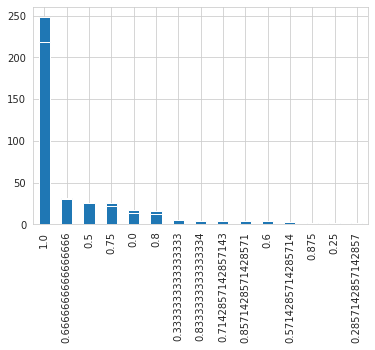

In [ ]:
output_dir =  '/content/drive/MyDrive/muss/muss_system_outputs/asset/test/muss_bart_access_wikilarge_mined'
filenames = next(os.walk(output_dir), (None, None, []))[2]  # [] if no file

# bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
for file_name in filenames:
  
  dir = output_dir+'/'+file_name
  # for output_file_name in test_data_list:
  bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(dir,0,0,0,0,muss=True,simple_or_complex='complex')
  bleu_list.append(bleu)
  sari_list.append(sari)
  fkgl_list.append(fkgl)
  NE_retain_mean_list.append(NE_retain_mean)
  NE_retain_std_list.append(NE_retain_std)

  # bleu_list_list += [bleu_list]
  # sari_list_list += [sari_list]
  # fkgl_list_list += [fkgl_list]
  # NE_retain_mean_list_list += [NE_retain_mean_list]
  # NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
muss_result = [bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/muss_evaluation_complex_NE', 'wb') as fp:
    pickle.dump(muss_result, fp)


# operation perserving

## model 18

In [69]:
# run the section define test set path (simple)
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_simple_0NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_1NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_2NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_3NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_4NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_5NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_6NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/token_asset_simple_NER_0810/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/token_asset_0803/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_no_random_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_random_0825/test.complex'],
 ['asset.0.s

In [ ]:
# NE(simple) retention rate

pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/02/asset.0.simple.test
{'bleu': 65.427, 'sari': 44.161, 'fkgl': 5.049, 'quality_estimation': {'Compression ratio': 0.946, 'Sentence splits': 1.634, 'Levenshtein similarity': 0.769, 'Exact copies': 0.0, 'Additions proportion': 0.281, 'Deletions proportion': 0.265, 'Lexical complexity score': 7.837}}
model id: model_18_local_1629593348299
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.789653
std        0.276656
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/02/asset.1.simple.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 65.271, 'sari': 44.278, 'fkgl': 5.12, 'quality_estimation': {'Compression ratio': 0.957, 'Sentence splits': 1.645, 'Levenshtein similarity': 0.767, 'Exact copies': 0.0, 'Additions proportion': 0.285, 'Deletions proportion': 0.258, 'Lexical complexity score': 7.824}}
model id: model_18_local_1629593348299
dataset: asset
blue: 65.427 0.0
sari: 44.161 0.0
fkgl: 5.049 0.0
count    318.000000
mean       0.798169
std        0.267311
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/02/asset.2.simple.test
{'bleu': 65.36, 'sari': 44.413, 'fkgl': 5.166, 'quality_estimation': {'Compression ratio': 0.962, 'Sentence splits': 1.643, 'Levenshtein similarity': 0.766, 'Exact copies': 0.0, 'Additions proportion': 0.286, 'Deletions proportion': 0.257, 'Lexical complexity score': 7.822}}
model id: model_18_local_1629593348299
dataset: asset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 64.669, 'sari': 43.887, 'fkgl': 5.128, 'quality_estimation': {'Compression ratio': 0.956, 'Sentence splits': 1.627, 'Levenshtein similarity': 0.763, 'Exact copies': 0.0, 'Additions proportion': 0.287, 'Deletions proportion': 0.256, 'Lexical complexity score': 7.801}}
model id: model_18_local_1629593348299
dataset: asset
blue: 64.686 0.0
sari: 44.218 0.0
fkgl: 4.994 0.0
count    318.000000
mean       0.790371
std        0.269194
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/03/asset.2.simple.test
{'bleu': 64.385, 'sari': 44.004, 'fkgl': 5.158, 'quality_estimation': {'Compression ratio': 0.962, 'Sentence splits': 1.633, 'Levenshtein similarity': 0.763, 'Exact copies': 0.0, 'Additions proportion': 0.291, 'Deletions proportion': 0.256, 'Lexical complexity score': 7.824}}
model id: model_18_local_1629593348299
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 64.21, 'sari': 44.095, 'fkgl': 5.122, 'quality_estimation': {'Compression ratio': 0.958, 'Sentence splits': 1.629, 'Levenshtein similarity': 0.762, 'Exact copies': 0.0, 'Additions proportion': 0.29, 'Deletions proportion': 0.259, 'Lexical complexity score': 7.796}}
model id: model_18_local_1629593348299
dataset: asset
blue: 64.926 0.0
sari: 44.169 0.0
fkgl: 5.064 0.0
count    318.000000
mean       0.795291
std        0.268734
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/04/asset.2.simple.test
{'bleu': 64.572, 'sari': 43.942, 'fkgl': 5.288, 'quality_estimation': {'Compression ratio': 0.965, 'Sentence splits': 1.603, 'Levenshtein similarity': 0.765, 'Exact copies': 0.0, 'Additions proportion': 0.288, 'Deletions proportion': 0.252, 'Lexical complexity score': 7.802}}
model id: model_18_local_1629593348299
dataset: asset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 63.763, 'sari': 43.715, 'fkgl': 5.093, 'quality_estimation': {'Compression ratio': 0.957, 'Sentence splits': 1.626, 'Levenshtein similarity': 0.759, 'Exact copies': 0.0, 'Additions proportion': 0.294, 'Deletions proportion': 0.261, 'Lexical complexity score': 7.79}}
model id: model_18_local_1629593348299
dataset: asset
blue: 63.756 0.0
sari: 43.908 0.0
fkgl: 5.065 0.0
count    318.000000
mean       0.768612
std        0.281182
min        0.000000
25%        0.600000
50%        0.857143
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/05/asset.2.simple.test
{'bleu': 63.836, 'sari': 43.961, 'fkgl': 5.216, 'quality_estimation': {'Compression ratio': 0.966, 'Sentence splits': 1.593, 'Levenshtein similarity': 0.762, 'Exact copies': 0.0, 'Additions proportion': 0.292, 'Deletions proportion': 0.251, 'Lexical complexity score': 7.806}}
model id: model_18_local_1629593348299
dataset: asse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 63.085, 'sari': 43.626, 'fkgl': 4.987, 'quality_estimation': {'Compression ratio': 0.955, 'Sentence splits': 1.636, 'Levenshtein similarity': 0.755, 'Exact copies': 0.0, 'Additions proportion': 0.3, 'Deletions proportion': 0.265, 'Lexical complexity score': 7.802}}
model id: model_18_local_1629593348299
dataset: asset
blue: 63.413 0.0
sari: 43.715 0.0
fkgl: 4.852 0.0
count    318.000000
mean       0.749280
std        0.296664
min        0.000000
25%        0.500000
50%        0.800000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/06/asset.2.simple.test
{'bleu': 62.184, 'sari': 43.494, 'fkgl': 5.0, 'quality_estimation': {'Compression ratio': 0.961, 'Sentence splits': 1.628, 'Levenshtein similarity': 0.751, 'Exact copies': 0.0, 'Additions proportion': 0.308, 'Deletions proportion': 0.263, 'Lexical complexity score': 7.797}}
model id: model_18_local_1629593348299
dataset: asset
b

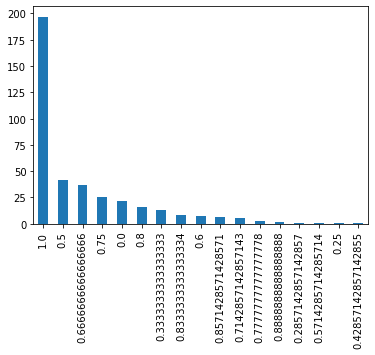

In [ ]:
i = 18
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['02','03','04','05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_18_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model18_evaluation', 'wb') as fp:
    pickle.dump(model_18_result, fp)


In [ ]:
# operation sari

In [ ]:
i = 18
generate_id_list = ['02','03','04','05','06']
test_data_list = ['asset.simple.test']

output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2] # model_18_local_1629593348299

sari_add_list, sari_keep_list, sari_del_list = [],[],[]

dataset = 'asset'
phase = 'test'

for generate_id in generate_id_list:
  
  
  for output_file_name in test_data_list:
    sari_add, sari_keep, sari_del = evaluate_my_model_operation(output_id,generate_id,dataset,phase,output_file_name)
    sari_add_list.append(sari_add)
    sari_keep_list.append(sari_keep)
    sari_del_list.append(sari_del)


In [ ]:
np.mean(sari_add_list),get_mean_confidence_interval(sari_add_list)

(12.053999999999998, 0.2842054704242215)

In [ ]:
np.mean(sari_keep_list),get_mean_confidence_interval(sari_keep_list)

(59.217600000000004, 0.994527364843462)

In [ ]:
np.mean(sari_del_list),get_mean_confidence_interval(sari_del_list)

(61.321799999999996, 0.25157626334015654)

In [ ]:
# NE(complex) retention rate

pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/02/asset.complex.test
{'bleu': 65.772, 'sari': 44.629, 'fkgl': 5.131, 'quality_estimation': {'Compression ratio': 0.967, 'Sentence splits': 1.657, 'Levenshtein similarity': 0.768, 'Exact copies': 0.0, 'Additions proportion': 0.286, 'Deletions proportion': 0.252, 'Lexical complexity score': 7.823}}
model id: model_18_local_1629593348299
dataset: asset
count    351.000000
mean       0.852456
std        0.246256
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/03/asset.complex.test
{'bleu': 64.876, 'sari': 44.356, 'fkgl': 5.141, 'quality_estimation': {'Compression ratio': 0.972, 'Sentence splits': 1.642, 'Levenshtein similarity': 0.768, 'Exact copies': 0.0, 'Additions proportion': 0.29, 'Deletions proportion': 0.247, 'Lexical complexity score': 7.823}}
model i

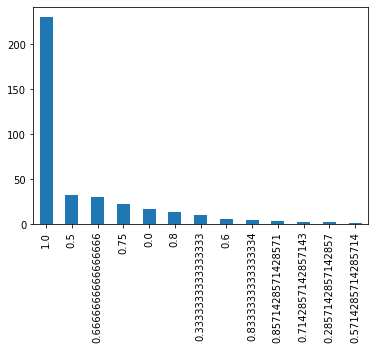

In [ ]:
i = 18
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['02','03','04','05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model18_evaluation_all_complex_NE_retain_rate', 'wb') as fp:
    pickle.dump([bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list], fp)


## model 18 complex

In [ ]:
# run define test set path (complex)
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_complex_0NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_1NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_2NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_3NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_4NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_5NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_6NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_all_words_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_all_words_random_0828/test.complex'],
 ['asset.0.complex.test',
  'asset.1.complex.test',
  'asset.2.complex.test',
  'asset.3.complex.test',
  'asset.4.complex.test',
  'asset.5.complex.test',
  'asset.6.complex.test',
  'ass

pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/07/asset.0.complex.test
{'bleu': 65.427, 'sari': 44.161, 'fkgl': 5.049, 'quality_estimation': {'Compression ratio': 0.946, 'Sentence splits': 1.634, 'Levenshtein similarity': 0.769, 'Exact copies': 0.0, 'Additions proportion': 0.281, 'Deletions proportion': 0.265, 'Lexical complexity score': 7.837}}
model id: model_18_local_1629593348299
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.789653
std        0.276656
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/07/asset.1.complex.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 65.397, 'sari': 44.41, 'fkgl': 5.104, 'quality_estimation': {'Compression ratio': 0.957, 'Sentence splits': 1.647, 'Levenshtein similarity': 0.768, 'Exact copies': 0.0, 'Additions proportion': 0.284, 'Deletions proportion': 0.257, 'Lexical complexity score': 7.825}}
model id: model_18_local_1629593348299
dataset: asset
blue: 65.427 0.0
sari: 44.161 0.0
fkgl: 5.049 0.0
count    318.000000
mean       0.796352
std        0.271272
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/07/asset.2.complex.test
{'bleu': 65.195, 'sari': 44.35, 'fkgl': 5.161, 'quality_estimation': {'Compression ratio': 0.961, 'Sentence splits': 1.645, 'Levenshtein similarity': 0.766, 'Exact copies': 0.0, 'Additions proportion': 0.287, 'Deletions proportion': 0.258, 'Lexical complexity score': 7.822}}
model id: model_18_local_1629593348299
dataset: asse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 64.812, 'sari': 44.018, 'fkgl': 5.136, 'quality_estimation': {'Compression ratio': 0.957, 'Sentence splits': 1.629, 'Levenshtein similarity': 0.765, 'Exact copies': 0.0, 'Additions proportion': 0.286, 'Deletions proportion': 0.255, 'Lexical complexity score': 7.818}}
model id: model_18_local_1629593348299
dataset: asset
blue: 64.686 0.0
sari: 44.218 0.0
fkgl: 4.994 0.0
count    318.000000
mean       0.789947
std        0.272351
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/08/asset.2.complex.test
{'bleu': 64.505, 'sari': 44.008, 'fkgl': 5.179, 'quality_estimation': {'Compression ratio': 0.964, 'Sentence splits': 1.627, 'Levenshtein similarity': 0.764, 'Exact copies': 0.0, 'Additions proportion': 0.29, 'Deletions proportion': 0.255, 'Lexical complexity score': 7.836}}
model id: model_18_local_1629593348299
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 63.996, 'sari': 44.128, 'fkgl': 5.105, 'quality_estimation': {'Compression ratio': 0.961, 'Sentence splits': 1.64, 'Levenshtein similarity': 0.761, 'Exact copies': 0.0, 'Additions proportion': 0.291, 'Deletions proportion': 0.258, 'Lexical complexity score': 7.788}}
model id: model_18_local_1629593348299
dataset: asset
blue: 64.926 0.0
sari: 44.169 0.0
fkgl: 5.064 0.0
count    318.000000
mean       0.796221
std        0.265773
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/09/asset.2.complex.test
{'bleu': 64.422, 'sari': 44.088, 'fkgl': 5.255, 'quality_estimation': {'Compression ratio': 0.965, 'Sentence splits': 1.611, 'Levenshtein similarity': 0.762, 'Exact copies': 0.0, 'Additions proportion': 0.292, 'Deletions proportion': 0.256, 'Lexical complexity score': 7.807}}
model id: model_18_local_1629593348299
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 64.282, 'sari': 43.901, 'fkgl': 5.113, 'quality_estimation': {'Compression ratio': 0.954, 'Sentence splits': 1.617, 'Levenshtein similarity': 0.762, 'Exact copies': 0.0, 'Additions proportion': 0.292, 'Deletions proportion': 0.261, 'Lexical complexity score': 7.804}}
model id: model_18_local_1629593348299
dataset: asset
blue: 63.756 0.0
sari: 43.908 0.0
fkgl: 5.065 0.0
count    318.000000
mean       0.760558
std        0.290984
min        0.000000
25%        0.559524
50%        0.845238
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/10/asset.2.complex.test
{'bleu': 63.7, 'sari': 44.011, 'fkgl': 5.188, 'quality_estimation': {'Compression ratio': 0.964, 'Sentence splits': 1.6, 'Levenshtein similarity': 0.762, 'Exact copies': 0.0, 'Additions proportion': 0.293, 'Deletions proportion': 0.253, 'Lexical complexity score': 7.816}}
model id: model_18_local_1629593348299
dataset: asset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 63.294, 'sari': 43.666, 'fkgl': 4.976, 'quality_estimation': {'Compression ratio': 0.956, 'Sentence splits': 1.642, 'Levenshtein similarity': 0.757, 'Exact copies': 0.0, 'Additions proportion': 0.298, 'Deletions proportion': 0.262, 'Lexical complexity score': 7.798}}
model id: model_18_local_1629593348299
dataset: asset
blue: 63.413 0.0
sari: 43.715 0.0
fkgl: 4.852 0.0
count    318.000000
mean       0.749642
std        0.294947
min        0.000000
25%        0.513889
50%        0.800000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/11/asset.2.complex.test
{'bleu': 62.733, 'sari': 43.582, 'fkgl': 4.992, 'quality_estimation': {'Compression ratio': 0.964, 'Sentence splits': 1.642, 'Levenshtein similarity': 0.753, 'Exact copies': 0.0, 'Additions proportion': 0.308, 'Deletions proportion': 0.262, 'Lexical complexity score': 7.797}}
model id: model_18_local_1629593348299
dataset: as

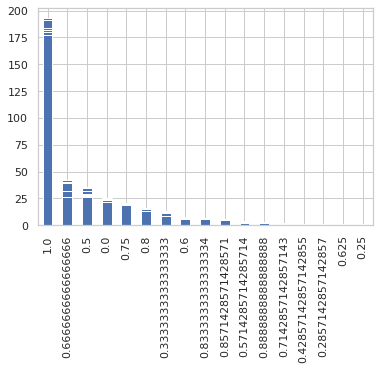

In [ ]:
i = 18
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]


for generate_id_list in ['07','08','09','10','11']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_18_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model18_evaluation_complex', 'wb') as fp:
    pickle.dump(model_18_result, fp)


In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model18_evaluation_complex', 'rb') as fp:
    model_18_result = pickle.load(fp)


In [ ]:
# NE(complex) retention rate

pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/07/asset.0.complex.test
{'bleu': 65.427, 'sari': 44.161, 'fkgl': 5.049, 'quality_estimation': {'Compression ratio': 0.946, 'Sentence splits': 1.634, 'Levenshtein similarity': 0.769, 'Exact copies': 0.0, 'Additions proportion': 0.281, 'Deletions proportion': 0.265, 'Lexical complexity score': 7.837}}
model id: model_18_local_1629593348299
dataset: asset
count    351.000000
mean       0.830688
std        0.259614
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_18_local_1629593348299/07/asset.1.complex.test
{'bleu': 65.397, 'sari': 44.41, 'fkgl': 5.104, 'quality_estimation': {'Compression ratio': 0.957, 'Sentence splits': 1.647, 'Levenshtein similarity': 0.768, 'Exact copies': 0.0, 'Additions proportion': 0.284, 'Deletions proportion': 0.257, 'Lexical complexity score': 7.825}}
mod

SyntaxError: ignored

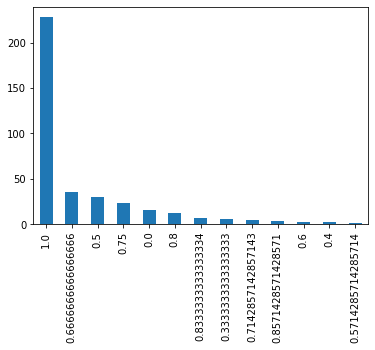

In [ ]:
i = 18
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]


for generate_id_list in ['07','08','09','10','11']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_18_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model18_evaluation_complex_NE', 'wb') as fp:
    pickle.dump(model_18_result, fp)


## model 19

In [ ]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_simple_0NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_1NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_2NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_3NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_4NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_5NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_6NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/token_asset_simple_NER_0810/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/token_asset_0803/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_no_random_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_random_0825/test.complex'],
 ['asset.0.s

pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/00/asset.0.simple.test
{'bleu': 71.834, 'sari': 44.11, 'fkgl': 5.239, 'quality_estimation': {'Compression ratio': 0.942, 'Sentence splits': 1.642, 'Levenshtein similarity': 0.811, 'Exact copies': 0.0, 'Additions proportion': 0.234, 'Deletions proportion': 0.234, 'Lexical complexity score': 7.93}}
model id: model_19_local_1629593348299
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.823626
std        0.260802
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/00/asset.1.simple.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 71.766, 'sari': 44.285, 'fkgl': 5.319, 'quality_estimation': {'Compression ratio': 0.956, 'Sentence splits': 1.645, 'Levenshtein similarity': 0.811, 'Exact copies': 0.0, 'Additions proportion': 0.238, 'Deletions proportion': 0.226, 'Lexical complexity score': 7.943}}
model id: model_19_local_1629593348299
dataset: asset
blue: 71.834 0.0
sari: 44.11 0.0
fkgl: 5.239 0.0
count    318.000000
mean       0.843115
std        0.243035
min        0.000000
25%        0.703571
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/00/asset.2.simple.test
{'bleu': 71.165, 'sari': 44.244, 'fkgl': 5.353, 'quality_estimation': {'Compression ratio': 0.962, 'Sentence splits': 1.648, 'Levenshtein similarity': 0.809, 'Exact copies': 0.0, 'Additions proportion': 0.241, 'Deletions proportion': 0.224, 'Lexical complexity score': 7.934}}
model id: model_19_local_1629593348299
dataset: asse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 70.474, 'sari': 44.233, 'fkgl': 5.202, 'quality_estimation': {'Compression ratio': 0.956, 'Sentence splits': 1.673, 'Levenshtein similarity': 0.806, 'Exact copies': 0.0, 'Additions proportion': 0.244, 'Deletions proportion': 0.23, 'Lexical complexity score': 7.935}}
model id: model_19_local_1629593348299
dataset: asset
blue: 71.243 0.0
sari: 44.186 0.0
fkgl: 5.297 0.0
count    318.000000
mean       0.827770
std        0.253135
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/01/asset.2.simple.test
{'bleu': 71.126, 'sari': 44.393, 'fkgl': 5.269, 'quality_estimation': {'Compression ratio': 0.96, 'Sentence splits': 1.66, 'Levenshtein similarity': 0.805, 'Exact copies': 0.0, 'Additions proportion': 0.242, 'Deletions proportion': 0.224, 'Lexical complexity score': 7.949}}
model id: model_19_local_1629593348299
dataset: asset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 70.261, 'sari': 43.937, 'fkgl': 5.38, 'quality_estimation': {'Compression ratio': 0.955, 'Sentence splits': 1.64, 'Levenshtein similarity': 0.799, 'Exact copies': 0.003, 'Additions proportion': 0.244, 'Deletions proportion': 0.232, 'Lexical complexity score': 7.939}}
model id: model_19_local_1629593348299
dataset: asset
blue: 70.429 0.0
sari: 43.664 0.0
fkgl: 5.218 0.0
count    318.000000
mean       0.820717
std        0.255629
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/02/asset.2.simple.test
{'bleu': 69.866, 'sari': 43.929, 'fkgl': 5.307, 'quality_estimation': {'Compression ratio': 0.958, 'Sentence splits': 1.65, 'Levenshtein similarity': 0.802, 'Exact copies': 0.003, 'Additions proportion': 0.245, 'Deletions proportion': 0.229, 'Lexical complexity score': 7.94}}
model id: model_19_local_1629593348299
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 69.032, 'sari': 43.677, 'fkgl': 5.137, 'quality_estimation': {'Compression ratio': 0.955, 'Sentence splits': 1.678, 'Levenshtein similarity': 0.796, 'Exact copies': 0.0, 'Additions proportion': 0.251, 'Deletions proportion': 0.233, 'Lexical complexity score': 7.941}}
model id: model_19_local_1629593348299
dataset: asset
blue: 69.772 0.0
sari: 43.947 0.0
fkgl: 5.242 0.0
count    318.000000
mean       0.808441
std        0.271615
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/03/asset.2.simple.test
{'bleu': 69.217, 'sari': 43.989, 'fkgl': 5.236, 'quality_estimation': {'Compression ratio': 0.963, 'Sentence splits': 1.662, 'Levenshtein similarity': 0.796, 'Exact copies': 0.0, 'Additions proportion': 0.255, 'Deletions proportion': 0.231, 'Lexical complexity score': 7.928}}
model id: model_19_local_1629593348299
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 68.571, 'sari': 43.484, 'fkgl': 5.101, 'quality_estimation': {'Compression ratio': 0.958, 'Sentence splits': 1.686, 'Levenshtein similarity': 0.791, 'Exact copies': 0.0, 'Additions proportion': 0.258, 'Deletions proportion': 0.235, 'Lexical complexity score': 7.925}}
model id: model_19_local_1629593348299
dataset: asset
blue: 68.7 0.0
sari: 43.618 0.0
fkgl: 5.064 0.0
count    318.000000
mean       0.799155
std        0.269680
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/04/asset.2.simple.test
{'bleu': 68.568, 'sari': 43.371, 'fkgl': 5.117, 'quality_estimation': {'Compression ratio': 0.961, 'Sentence splits': 1.682, 'Levenshtein similarity': 0.793, 'Exact copies': 0.003, 'Additions proportion': 0.26, 'Deletions proportion': 0.233, 'Lexical complexity score': 7.938}}
model id: model_19_local_1629593348299
dataset: asse

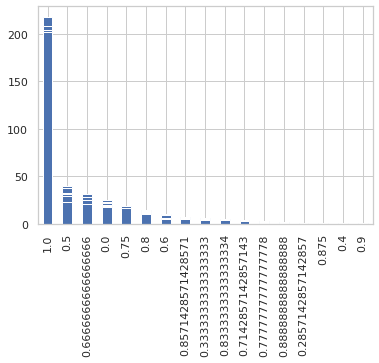

In [ ]:
i = 19
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_19_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model19_evaluation', 'wb') as fp:
    pickle.dump(model_19_result, fp)


pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/00/asset.complex.test
{'bleu': 71.225, 'sari': 44.211, 'fkgl': 5.348, 'quality_estimation': {'Compression ratio': 0.967, 'Sentence splits': 1.656, 'Levenshtein similarity': 0.81, 'Exact copies': 0.0, 'Additions proportion': 0.243, 'Deletions proportion': 0.221, 'Lexical complexity score': 7.938}}
model id: model_19_local_1629593348299
dataset: asset
count    351.000000
mean       0.887522
std        0.208629
min        0.000000
25%        0.800000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/01/asset.complex.test
{'bleu': 70.654, 'sari': 44.409, 'fkgl': 5.344, 'quality_estimation': {'Compression ratio': 0.966, 'Sentence splits': 1.656, 'Levenshtein similarity': 0.804, 'Exact copies': 0.0, 'Additions proportion': 0.244, 'Deletions proportion': 0.222, 'Lexical complexity score': 7.964}}
model i

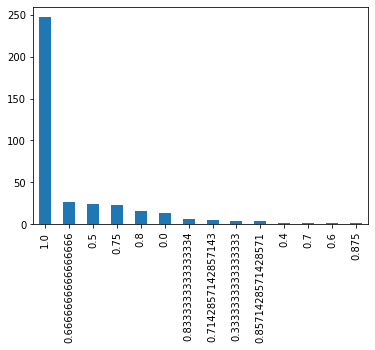

In [ ]:
i = 19
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model19_evaluation_all_complex_NE_retain_rate', 'wb') as fp:
    pickle.dump([bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list], fp)


## model 19 complex

In [ ]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_complex_0NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_1NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_2NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_3NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_4NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_5NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_6NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_all_words_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_all_words_random_0828/test.complex'],
 ['asset.0.complex.test',
  'asset.1.complex.test',
  'asset.2.complex.test',
  'asset.3.complex.test',
  'asset.4.complex.test',
  'asset.5.complex.test',
  'asset.6.complex.test',
  'ass

pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/05/asset.0.complex.test
{'bleu': 71.834, 'sari': 44.11, 'fkgl': 5.239, 'quality_estimation': {'Compression ratio': 0.942, 'Sentence splits': 1.642, 'Levenshtein similarity': 0.811, 'Exact copies': 0.0, 'Additions proportion': 0.234, 'Deletions proportion': 0.234, 'Lexical complexity score': 7.93}}
model id: model_19_local_1629593348299
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.823626
std        0.260802
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/05/asset.1.complex.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 71.753, 'sari': 44.353, 'fkgl': 5.323, 'quality_estimation': {'Compression ratio': 0.954, 'Sentence splits': 1.645, 'Levenshtein similarity': 0.811, 'Exact copies': 0.0, 'Additions proportion': 0.239, 'Deletions proportion': 0.229, 'Lexical complexity score': 7.934}}
model id: model_19_local_1629593348299
dataset: asset
blue: 71.834 0.0
sari: 44.11 0.0
fkgl: 5.239 0.0
count    318.000000
mean       0.839746
std        0.250612
min        0.000000
25%        0.703571
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/05/asset.2.complex.test
{'bleu': 71.273, 'sari': 44.249, 'fkgl': 5.322, 'quality_estimation': {'Compression ratio': 0.962, 'Sentence splits': 1.654, 'Levenshtein similarity': 0.809, 'Exact copies': 0.0, 'Additions proportion': 0.242, 'Deletions proportion': 0.224, 'Lexical complexity score': 7.932}}
model id: model_19_local_1629593348299
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 70.541, 'sari': 44.201, 'fkgl': 5.213, 'quality_estimation': {'Compression ratio': 0.957, 'Sentence splits': 1.673, 'Levenshtein similarity': 0.808, 'Exact copies': 0.0, 'Additions proportion': 0.242, 'Deletions proportion': 0.227, 'Lexical complexity score': 7.936}}
model id: model_19_local_1629593348299
dataset: asset
blue: 71.243 0.0
sari: 44.186 0.0
fkgl: 5.297 0.0
count    318.000000
mean       0.816165
std        0.268911
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/06/asset.2.complex.test
{'bleu': 71.148, 'sari': 44.43, 'fkgl': 5.325, 'quality_estimation': {'Compression ratio': 0.962, 'Sentence splits': 1.655, 'Levenshtein similarity': 0.806, 'Exact copies': 0.0, 'Additions proportion': 0.241, 'Deletions proportion': 0.222, 'Lexical complexity score': 7.944}}
model id: model_19_local_1629593348299
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 70.351, 'sari': 43.993, 'fkgl': 5.34, 'quality_estimation': {'Compression ratio': 0.954, 'Sentence splits': 1.643, 'Levenshtein similarity': 0.799, 'Exact copies': 0.003, 'Additions proportion': 0.245, 'Deletions proportion': 0.233, 'Lexical complexity score': 7.937}}
model id: model_19_local_1629593348299
dataset: asset
blue: 70.429 0.0
sari: 43.664 0.0
fkgl: 5.218 0.0
count    318.000000
mean       0.817004
std        0.266254
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/07/asset.2.complex.test
{'bleu': 70.066, 'sari': 43.962, 'fkgl': 5.298, 'quality_estimation': {'Compression ratio': 0.956, 'Sentence splits': 1.65, 'Levenshtein similarity': 0.803, 'Exact copies': 0.003, 'Additions proportion': 0.245, 'Deletions proportion': 0.231, 'Lexical complexity score': 7.937}}
model id: model_19_local_1629593348299
dataset: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 69.146, 'sari': 43.869, 'fkgl': 5.19, 'quality_estimation': {'Compression ratio': 0.955, 'Sentence splits': 1.667, 'Levenshtein similarity': 0.799, 'Exact copies': 0.0, 'Additions proportion': 0.249, 'Deletions proportion': 0.232, 'Lexical complexity score': 7.945}}
model id: model_19_local_1629593348299
dataset: asset
blue: 69.772 0.0
sari: 43.947 0.0
fkgl: 5.242 0.0
count    318.000000
mean       0.801215
std        0.283773
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/08/asset.2.complex.test
{'bleu': 68.983, 'sari': 44.047, 'fkgl': 5.232, 'quality_estimation': {'Compression ratio': 0.964, 'Sentence splits': 1.668, 'Levenshtein similarity': 0.796, 'Exact copies': 0.0, 'Additions proportion': 0.255, 'Deletions proportion': 0.231, 'Lexical complexity score': 7.929}}
model id: model_19_local_1629593348299
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 68.525, 'sari': 43.344, 'fkgl': 5.083, 'quality_estimation': {'Compression ratio': 0.957, 'Sentence splits': 1.689, 'Levenshtein similarity': 0.793, 'Exact copies': 0.0, 'Additions proportion': 0.257, 'Deletions proportion': 0.233, 'Lexical complexity score': 7.92}}
model id: model_19_local_1629593348299
dataset: asset
blue: 68.7 0.0
sari: 43.618 0.0
fkgl: 5.064 0.0
count    318.000000
mean       0.781111
std        0.287799
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/09/asset.2.complex.test
{'bleu': 68.69, 'sari': 43.377, 'fkgl': 5.176, 'quality_estimation': {'Compression ratio': 0.96, 'Sentence splits': 1.662, 'Levenshtein similarity': 0.797, 'Exact copies': 0.003, 'Additions proportion': 0.256, 'Deletions proportion': 0.23, 'Lexical complexity score': 7.927}}
model id: model_19_local_1629593348299
dataset: asset


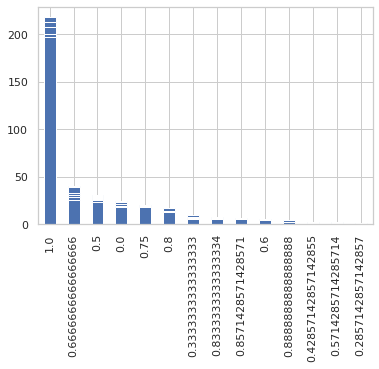

In [ ]:
i = 19
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_19_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model19_evaluation_complex', 'wb') as fp:
    pickle.dump(model_19_result, fp)


pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/05/asset.0.complex.test
{'bleu': 71.834, 'sari': 44.11, 'fkgl': 5.239, 'quality_estimation': {'Compression ratio': 0.942, 'Sentence splits': 1.642, 'Levenshtein similarity': 0.811, 'Exact copies': 0.0, 'Additions proportion': 0.234, 'Deletions proportion': 0.234, 'Lexical complexity score': 7.93}}
model id: model_19_local_1629593348299
dataset: asset
count    351.000000
mean       0.871730
std        0.223448
min        0.000000
25%        0.775000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_19_local_1629593348299/05/asset.1.complex.test
{'bleu': 71.753, 'sari': 44.353, 'fkgl': 5.323, 'quality_estimation': {'Compression ratio': 0.954, 'Sentence splits': 1.645, 'Levenshtein similarity': 0.811, 'Exact copies': 0.0, 'Additions proportion': 0.239, 'Deletions proportion': 0.229, 'Lexical complexity score': 7.934}}
mode

SyntaxError: ignored

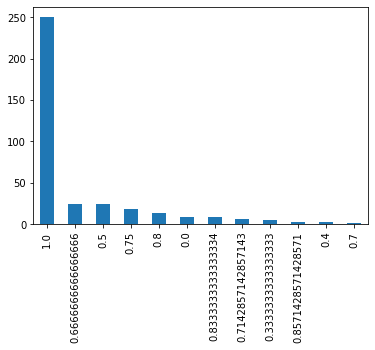

In [ ]:
i = 19
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_19_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model19_evaluation_complex_NE', 'wb') as fp:
    pickle.dump(model_19_result, fp)


## model 20

In [ ]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_simple_0NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_1NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_2NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_3NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_4NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_5NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_6NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/token_asset_simple_NER_0810/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/token_asset_0803/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_no_random_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_random_0825/test.complex'],
 ['asset.0.s

pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/00/asset.0.simple.test
{'bleu': 58.68, 'sari': 38.773, 'fkgl': 5.683, 'quality_estimation': {'Compression ratio': 0.896, 'Sentence splits': 1.525, 'Levenshtein similarity': 0.736, 'Exact copies': 0.0, 'Additions proportion': 0.293, 'Deletions proportion': 0.339, 'Lexical complexity score': 7.924}}
model id: model_20_local_1629593322552
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.202715
std        0.299373
min        0.000000
25%        0.000000
50%        0.000000
75%        0.333333
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/00/asset.1.simple.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 61.458, 'sari': 41.46, 'fkgl': 5.488, 'quality_estimation': {'Compression ratio': 0.904, 'Sentence splits': 1.57, 'Levenshtein similarity': 0.754, 'Exact copies': 0.0, 'Additions proportion': 0.277, 'Deletions proportion': 0.318, 'Lexical complexity score': 7.863}}
model id: model_20_local_1629593322552
dataset: asset
blue: 58.68 0.0
sari: 38.773 0.0
fkgl: 5.683 0.0
count    318.000000
mean       0.572995
std        0.306061
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/00/asset.2.simple.test
{'bleu': 65.279, 'sari': 43.236, 'fkgl': 5.368, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.611, 'Levenshtein similarity': 0.775, 'Exact copies': 0.0, 'Additions proportion': 0.251, 'Deletions proportion': 0.293, 'Lexical complexity score': 7.923}}
model id: model_20_local_1629593322552
dataset: asset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 60.546, 'sari': 41.439, 'fkgl': 5.484, 'quality_estimation': {'Compression ratio': 0.904, 'Sentence splits': 1.574, 'Levenshtein similarity': 0.746, 'Exact copies': 0.0, 'Additions proportion': 0.279, 'Deletions proportion': 0.321, 'Lexical complexity score': 7.871}}
model id: model_20_local_1629593322552
dataset: asset
blue: 56.016 0.0
sari: 38.478 0.0
fkgl: 5.718 0.0
count    318.000000
mean       0.567998
std        0.303620
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/01/asset.2.simple.test
{'bleu': 64.368, 'sari': 43.414, 'fkgl': 5.328, 'quality_estimation': {'Compression ratio': 0.903, 'Sentence splits': 1.618, 'Levenshtein similarity': 0.764, 'Exact copies': 0.0, 'Additions proportion': 0.255, 'Deletions proportion': 0.299, 'Lexical complexity score': 7.909}}
model id: model_20_local_1629593322552
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 59.056, 'sari': 41.387, 'fkgl': 5.498, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.575, 'Levenshtein similarity': 0.743, 'Exact copies': 0.0, 'Additions proportion': 0.291, 'Deletions proportion': 0.328, 'Lexical complexity score': 7.852}}
model id: model_20_local_1629593322552
dataset: asset
blue: 56.869 0.0
sari: 38.725 0.0
fkgl: 5.72 0.0
count    318.000000
mean       0.570659
std        0.301739
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/02/asset.2.simple.test
{'bleu': 62.513, 'sari': 43.261, 'fkgl': 5.286, 'quality_estimation': {'Compression ratio': 0.911, 'Sentence splits': 1.619, 'Levenshtein similarity': 0.757, 'Exact copies': 0.003, 'Additions proportion': 0.27, 'Deletions proportion': 0.301, 'Lexical complexity score': 7.929}}
model id: model_20_local_1629593322552
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 58.787, 'sari': 41.205, 'fkgl': 5.518, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.572, 'Levenshtein similarity': 0.739, 'Exact copies': 0.0, 'Additions proportion': 0.294, 'Deletions proportion': 0.331, 'Lexical complexity score': 7.859}}
model id: model_20_local_1629593322552
dataset: asset
blue: 56.127 0.0
sari: 38.539 0.0
fkgl: 5.647 0.0
count    318.000000
mean       0.564684
std        0.299087
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/03/asset.2.simple.test
{'bleu': 62.712, 'sari': 43.439, 'fkgl': 5.258, 'quality_estimation': {'Compression ratio': 0.91, 'Sentence splits': 1.636, 'Levenshtein similarity': 0.753, 'Exact copies': 0.0, 'Additions proportion': 0.276, 'Deletions proportion': 0.307, 'Lexical complexity score': 7.905}}
model id: model_20_local_1629593322552
dataset: asse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 58.02, 'sari': 40.882, 'fkgl': 5.349, 'quality_estimation': {'Compression ratio': 0.912, 'Sentence splits': 1.594, 'Levenshtein similarity': 0.738, 'Exact copies': 0.0, 'Additions proportion': 0.302, 'Deletions proportion': 0.326, 'Lexical complexity score': 7.828}}
model id: model_20_local_1629593322552
dataset: asset
blue: 54.9 0.0
sari: 38.503 0.0
fkgl: 5.53 0.0
count    318.000000
mean       0.559163
std        0.305453
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/05/asset.2.simple.test
{'bleu': 61.502, 'sari': 42.904, 'fkgl': 5.102, 'quality_estimation': {'Compression ratio': 0.911, 'Sentence splits': 1.644, 'Levenshtein similarity': 0.753, 'Exact copies': 0.0, 'Additions proportion': 0.276, 'Deletions proportion': 0.3, 'Lexical complexity score': 7.916}}
model id: model_20_local_1629593322552
dataset: asset
blu

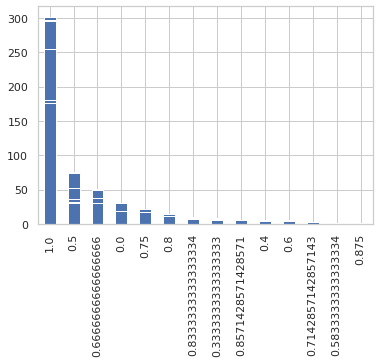

In [ ]:
i = 20
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','05']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_20_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model20_evaluation', 'wb') as fp:
    pickle.dump(model_20_result, fp)


pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/00/asset.complex.test
{'bleu': 72.531, 'sari': 45.309, 'fkgl': 4.901, 'quality_estimation': {'Compression ratio': 0.926, 'Sentence splits': 1.68, 'Levenshtein similarity': 0.813, 'Exact copies': 0.0, 'Additions proportion': 0.223, 'Deletions proportion': 0.234, 'Lexical complexity score': 7.917}}
model id: model_20_local_1629593322552
dataset: asset
count    351.000000
mean       0.993875
std        0.061744
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/01/asset.complex.test
{'bleu': 71.129, 'sari': 45.399, 'fkgl': 4.897, 'quality_estimation': {'Compression ratio': 0.923, 'Sentence splits': 1.665, 'Levenshtein similarity': 0.801, 'Exact copies': 0.0, 'Additions proportion': 0.233, 'Deletions proportion': 0.246, 'Lexical complexity score': 7.9}}
model id:

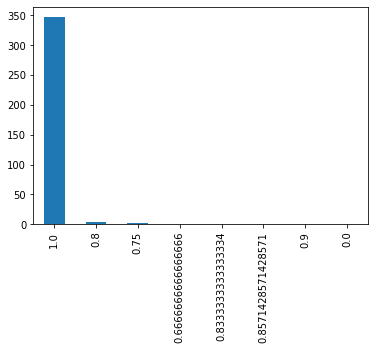

In [ ]:
i = 20
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','05']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model20_evaluation_all_complex_NE_retain_rate', 'wb') as fp:
    pickle.dump([bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list], fp)


## model 20 complex

pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/06/asset.0.complex.test
{'bleu': 58.68, 'sari': 38.773, 'fkgl': 5.683, 'quality_estimation': {'Compression ratio': 0.896, 'Sentence splits': 1.525, 'Levenshtein similarity': 0.736, 'Exact copies': 0.0, 'Additions proportion': 0.293, 'Deletions proportion': 0.339, 'Lexical complexity score': 7.924}}
model id: model_20_local_1629593322552
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.202715
std        0.299373
min        0.000000
25%        0.000000
50%        0.000000
75%        0.333333
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/06/asset.1.complex.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 62.194, 'sari': 41.142, 'fkgl': 5.397, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.575, 'Levenshtein similarity': 0.758, 'Exact copies': 0.0, 'Additions proportion': 0.276, 'Deletions proportion': 0.316, 'Lexical complexity score': 7.902}}
model id: model_20_local_1629593322552
dataset: asset
blue: 58.68 0.0
sari: 38.773 0.0
fkgl: 5.683 0.0
count    318.000000
mean       0.523943
std        0.331617
min        0.000000
25%        0.250000
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/06/asset.2.complex.test
{'bleu': 66.201, 'sari': 42.699, 'fkgl': 5.344, 'quality_estimation': {'Compression ratio': 0.904, 'Sentence splits': 1.594, 'Levenshtein similarity': 0.782, 'Exact copies': 0.0, 'Additions proportion': 0.244, 'Deletions proportion': 0.286, 'Lexical complexity score': 7.912}}
model id: model_20_local_1629593322552
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 60.861, 'sari': 41.042, 'fkgl': 5.394, 'quality_estimation': {'Compression ratio': 0.904, 'Sentence splits': 1.579, 'Levenshtein similarity': 0.748, 'Exact copies': 0.0, 'Additions proportion': 0.28, 'Deletions proportion': 0.321, 'Lexical complexity score': 7.872}}
model id: model_20_local_1629593322552
dataset: asset
blue: 56.016 0.0
sari: 38.478 0.0
fkgl: 5.718 0.0
count    318.000000
mean       0.522615
std        0.327985
min        0.000000
25%        0.250000
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/07/asset.2.complex.test
{'bleu': 64.901, 'sari': 42.892, 'fkgl': 5.26, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.615, 'Levenshtein similarity': 0.769, 'Exact copies': 0.0, 'Additions proportion': 0.25, 'Deletions proportion': 0.292, 'Lexical complexity score': 7.899}}
model id: model_20_local_1629593322552
dataset: asset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 59.555, 'sari': 40.872, 'fkgl': 5.425, 'quality_estimation': {'Compression ratio': 0.902, 'Sentence splits': 1.57, 'Levenshtein similarity': 0.749, 'Exact copies': 0.0, 'Additions proportion': 0.285, 'Deletions proportion': 0.325, 'Lexical complexity score': 7.883}}
model id: model_20_local_1629593322552
dataset: asset
blue: 56.869 0.0
sari: 38.725 0.0
fkgl: 5.72 0.0
count    318.000000
mean       0.523262
std        0.326254
min        0.000000
25%        0.250000
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/08/asset.2.complex.test
{'bleu': 63.596, 'sari': 42.407, 'fkgl': 5.262, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.608, 'Levenshtein similarity': 0.767, 'Exact copies': 0.003, 'Additions proportion': 0.255, 'Deletions proportion': 0.293, 'Lexical complexity score': 7.94}}
model id: model_20_local_1629593322552
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 59.383, 'sari': 40.638, 'fkgl': 5.448, 'quality_estimation': {'Compression ratio': 0.906, 'Sentence splits': 1.572, 'Levenshtein similarity': 0.745, 'Exact copies': 0.0, 'Additions proportion': 0.29, 'Deletions proportion': 0.324, 'Lexical complexity score': 7.873}}
model id: model_20_local_1629593322552
dataset: asset
blue: 56.127 0.0
sari: 38.539 0.0
fkgl: 5.647 0.0
count    318.000000
mean       0.518677
std        0.325325
min        0.000000
25%        0.250000
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/09/asset.2.complex.test
{'bleu': 63.223, 'sari': 42.627, 'fkgl': 5.203, 'quality_estimation': {'Compression ratio': 0.91, 'Sentence splits': 1.623, 'Levenshtein similarity': 0.761, 'Exact copies': 0.0, 'Additions proportion': 0.267, 'Deletions proportion': 0.296, 'Lexical complexity score': 7.908}}
model id: model_20_local_1629593322552
dataset: asse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 58.144, 'sari': 40.427, 'fkgl': 5.334, 'quality_estimation': {'Compression ratio': 0.915, 'Sentence splits': 1.603, 'Levenshtein similarity': 0.742, 'Exact copies': 0.0, 'Additions proportion': 0.302, 'Deletions proportion': 0.324, 'Lexical complexity score': 7.85}}
model id: model_20_local_1629593322552
dataset: asset
blue: 54.9 0.0
sari: 38.503 0.0
fkgl: 5.53 0.0
count    318.000000
mean       0.512807
std        0.327218
min        0.000000
25%        0.250000
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_20_local_1629593322552/10/asset.2.complex.test
{'bleu': 62.388, 'sari': 42.295, 'fkgl': 5.077, 'quality_estimation': {'Compression ratio': 0.913, 'Sentence splits': 1.635, 'Levenshtein similarity': 0.762, 'Exact copies': 0.0, 'Additions proportion': 0.271, 'Deletions proportion': 0.294, 'Lexical complexity score': 7.919}}
model id: model_20_local_1629593322552
dataset: asset


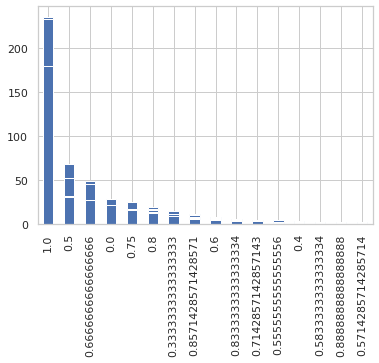

In [ ]:
i = 20
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['06','07','08','09','10']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_20_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model20_evaluation_complex', 'wb') as fp:
    pickle.dump(model_20_result, fp)


In [ ]:
i = 20
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['06','07','08','09','10']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_20_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model20_evaluation_complex_NE', 'wb') as fp:
    pickle.dump(model_20_result, fp)


## model 21

In [ ]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_simple_0NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_1NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_2NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_3NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_4NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_5NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_6NE_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/token_asset_simple_NER_0810/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/token_asset_0803/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_no_random_0825/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_simple_all_words_random_0825/test.complex'],
 ['asset.0.s

pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/00/asset.0.simple.test
{'bleu': 59.899, 'sari': 39.002, 'fkgl': 5.83, 'quality_estimation': {'Compression ratio': 0.9, 'Sentence splits': 1.449, 'Levenshtein similarity': 0.75, 'Exact copies': 0.0, 'Additions proportion': 0.285, 'Deletions proportion': 0.322, 'Lexical complexity score': 7.825}}
model id: model_21_local_1629593322552
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.208316
std        0.294836
min        0.000000
25%        0.000000
50%        0.000000
75%        0.333333
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/00/asset.1.simple.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 64.098, 'sari': 41.738, 'fkgl': 5.836, 'quality_estimation': {'Compression ratio': 0.901, 'Sentence splits': 1.482, 'Levenshtein similarity': 0.769, 'Exact copies': 0.0, 'Additions proportion': 0.258, 'Deletions proportion': 0.304, 'Lexical complexity score': 7.81}}
model id: model_21_local_1629593322552
dataset: asset
blue: 59.899 0.0
sari: 39.002 0.0
fkgl: 5.83 0.0
count    318.000000
mean       0.582958
std        0.303240
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/00/asset.2.simple.test
{'bleu': 68.063, 'sari': 43.542, 'fkgl': 5.608, 'quality_estimation': {'Compression ratio': 0.906, 'Sentence splits': 1.546, 'Levenshtein similarity': 0.789, 'Exact copies': 0.0, 'Additions proportion': 0.234, 'Deletions proportion': 0.276, 'Lexical complexity score': 7.899}}
model id: model_21_local_1629593322552
dataset: asset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 62.563, 'sari': 41.807, 'fkgl': 5.751, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.502, 'Levenshtein similarity': 0.761, 'Exact copies': 0.0, 'Additions proportion': 0.27, 'Deletions proportion': 0.31, 'Lexical complexity score': 7.827}}
model id: model_21_local_1629593322552
dataset: asset
blue: 59.319 0.0
sari: 39.034 0.0
fkgl: 5.719 0.0
count    318.000000
mean       0.580866
std        0.303807
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/01/asset.2.simple.test
{'bleu': 66.485, 'sari': 43.546, 'fkgl': 5.486, 'quality_estimation': {'Compression ratio': 0.906, 'Sentence splits': 1.553, 'Levenshtein similarity': 0.779, 'Exact copies': 0.0, 'Additions proportion': 0.249, 'Deletions proportion': 0.287, 'Lexical complexity score': 7.882}}
model id: model_21_local_1629593322552
dataset: asset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 63.063, 'sari': 41.603, 'fkgl': 5.719, 'quality_estimation': {'Compression ratio': 0.904, 'Sentence splits': 1.501, 'Levenshtein similarity': 0.762, 'Exact copies': 0.0, 'Additions proportion': 0.269, 'Deletions proportion': 0.311, 'Lexical complexity score': 7.817}}
model id: model_21_local_1629593322552
dataset: asset
blue: 58.139 0.0
sari: 38.986 0.0
fkgl: 5.893 0.0
count    318.000000
mean       0.585793
std        0.304216
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/02/asset.2.simple.test
{'bleu': 65.94, 'sari': 43.198, 'fkgl': 5.578, 'quality_estimation': {'Compression ratio': 0.904, 'Sentence splits': 1.539, 'Levenshtein similarity': 0.775, 'Exact copies': 0.0, 'Additions proportion': 0.249, 'Deletions proportion': 0.293, 'Lexical complexity score': 7.865}}
model id: model_21_local_1629593322552
dataset: asse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/03/asset.1.simple.test
{'bleu': 61.093, 'sari': 41.384, 'fkgl': 5.741, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.49, 'Levenshtein similarity': 0.757, 'Exact copies': 0.0, 'Additions proportion': 0.277, 'Deletions proportion': 0.314, 'Lexical complexity score': 7.8}}
model id: model_21_local_1629593322552
dataset: asset
blue: 57.694 0.0
sari: 38.977 0.0
fkgl: 5.744 0.0
count    318.000000
mean       0.575625
std        0.304494
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/03/asset.2.simple.test
{'bleu': 64.877, 'sari': 43.242, 'fkgl': 5.458, 'quality_estimation': {'Compression ratio': 0.911, 'Sentence splits': 1.558, 'Levenshtein similarity': 0.774, 'Exact copies': 0.0, 'Additions proportion': 0.256, 'Deletions proportion': 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 60.813, 'sari': 41.577, 'fkgl': 5.577, 'quality_estimation': {'Compression ratio': 0.906, 'Sentence splits': 1.512, 'Levenshtein similarity': 0.752, 'Exact copies': 0.0, 'Additions proportion': 0.286, 'Deletions proportion': 0.317, 'Lexical complexity score': 7.794}}
model id: model_21_local_1629593322552
dataset: asset
blue: 57.093 0.0
sari: 38.644 0.0
fkgl: 5.581 0.0
count    318.000000
mean       0.575054
std        0.306166
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/04/asset.2.simple.test
{'bleu': 63.814, 'sari': 43.204, 'fkgl': 5.382, 'quality_estimation': {'Compression ratio': 0.912, 'Sentence splits': 1.567, 'Levenshtein similarity': 0.766, 'Exact copies': 0.003, 'Additions proportion': 0.265, 'Deletions proportion': 0.29, 'Lexical complexity score': 7.852}}
model id: model_21_local_1629593322552
dataset: as

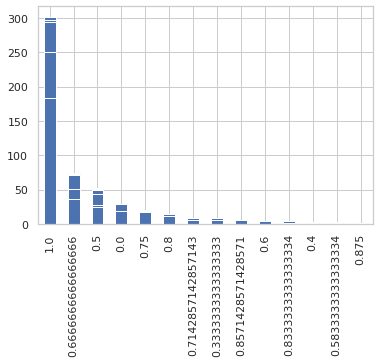

In [ ]:
i = 21
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_21_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model21_evaluation', 'wb') as fp:
    pickle.dump(model_21_result, fp)


pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/00/asset.complex.test
{'bleu': 74.128, 'sari': 45.211, 'fkgl': 5.137, 'quality_estimation': {'Compression ratio': 0.925, 'Sentence splits': 1.605, 'Levenshtein similarity': 0.825, 'Exact copies': 0.006, 'Additions proportion': 0.212, 'Deletions proportion': 0.225, 'Lexical complexity score': 7.851}}
model id: model_21_local_1629593322552
dataset: asset
count    351.000000
mean       0.991880
std        0.067915
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/01/asset.complex.test
{'bleu': 71.868, 'sari': 44.972, 'fkgl': 5.134, 'quality_estimation': {'Compression ratio': 0.923, 'Sentence splits': 1.587, 'Levenshtein similarity': 0.813, 'Exact copies': 0.0, 'Additions proportion': 0.223, 'Deletions proportion': 0.236, 'Lexical complexity score': 7.864}}
mode

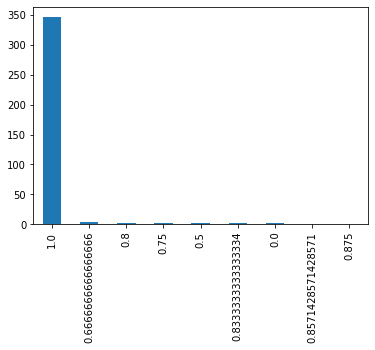

In [ ]:
i = 21
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model21_evaluation_all_complex_NE_retain_rate', 'wb') as fp:
    pickle.dump([bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list], fp)


## model 21 complex

In [ ]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_complex_0NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_1NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_2NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_3NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_4NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_5NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_6NE_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_all_words_0828/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_complex_all_words_random_0828/test.complex'],
 ['asset.0.complex.test',
  'asset.1.complex.test',
  'asset.2.complex.test',
  'asset.3.complex.test',
  'asset.4.complex.test',
  'asset.5.complex.test',
  'asset.6.complex.test',
  'ass

pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/05/asset.0.complex.test
{'bleu': 59.899, 'sari': 39.002, 'fkgl': 5.83, 'quality_estimation': {'Compression ratio': 0.9, 'Sentence splits': 1.449, 'Levenshtein similarity': 0.75, 'Exact copies': 0.0, 'Additions proportion': 0.285, 'Deletions proportion': 0.322, 'Lexical complexity score': 7.825}}
model id: model_21_local_1629593322552
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.208316
std        0.294836
min        0.000000
25%        0.000000
50%        0.000000
75%        0.333333
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/05/asset.1.complex.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 64.414, 'sari': 41.356, 'fkgl': 5.748, 'quality_estimation': {'Compression ratio': 0.901, 'Sentence splits': 1.492, 'Levenshtein similarity': 0.771, 'Exact copies': 0.0, 'Additions proportion': 0.257, 'Deletions proportion': 0.302, 'Lexical complexity score': 7.837}}
model id: model_21_local_1629593322552
dataset: asset
blue: 59.899 0.0
sari: 39.002 0.0
fkgl: 5.83 0.0
count    318.000000
mean       0.534972
std        0.329879
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/05/asset.2.complex.test
{'bleu': 67.992, 'sari': 43.122, 'fkgl': 5.455, 'quality_estimation': {'Compression ratio': 0.906, 'Sentence splits': 1.561, 'Levenshtein similarity': 0.792, 'Exact copies': 0.0, 'Additions proportion': 0.234, 'Deletions proportion': 0.272, 'Lexical complexity score': 7.875}}
model id: model_21_local_1629593322552
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 62.927, 'sari': 41.187, 'fkgl': 5.718, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.5, 'Levenshtein similarity': 0.765, 'Exact copies': 0.0, 'Additions proportion': 0.264, 'Deletions proportion': 0.306, 'Lexical complexity score': 7.832}}
model id: model_21_local_1629593322552
dataset: asset
blue: 59.319 0.0
sari: 39.034 0.0
fkgl: 5.719 0.0
count    318.000000
mean       0.532182
std        0.327797
min        0.000000
25%        0.308333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/06/asset.2.complex.test
{'bleu': 66.639, 'sari': 42.927, 'fkgl': 5.434, 'quality_estimation': {'Compression ratio': 0.907, 'Sentence splits': 1.546, 'Levenshtein similarity': 0.786, 'Exact copies': 0.0, 'Additions proportion': 0.242, 'Deletions proportion': 0.276, 'Lexical complexity score': 7.877}}
model id: model_21_local_1629593322552
dataset: asse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 63.011, 'sari': 41.295, 'fkgl': 5.601, 'quality_estimation': {'Compression ratio': 0.901, 'Sentence splits': 1.505, 'Levenshtein similarity': 0.763, 'Exact copies': 0.0, 'Additions proportion': 0.269, 'Deletions proportion': 0.311, 'Lexical complexity score': 7.833}}
model id: model_21_local_1629593322552
dataset: asset
blue: 58.139 0.0
sari: 38.986 0.0
fkgl: 5.893 0.0
count    318.000000
mean       0.539147
std        0.330096
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/07/asset.2.complex.test
{'bleu': 66.375, 'sari': 42.647, 'fkgl': 5.503, 'quality_estimation': {'Compression ratio': 0.903, 'Sentence splits': 1.535, 'Levenshtein similarity': 0.784, 'Exact copies': 0.0, 'Additions proportion': 0.246, 'Deletions proportion': 0.285, 'Lexical complexity score': 7.865}}
model id: model_21_local_1629593322552
dataset: as

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 61.332, 'sari': 40.915, 'fkgl': 5.635, 'quality_estimation': {'Compression ratio': 0.905, 'Sentence splits': 1.499, 'Levenshtein similarity': 0.759, 'Exact copies': 0.0, 'Additions proportion': 0.276, 'Deletions proportion': 0.313, 'Lexical complexity score': 7.821}}
model id: model_21_local_1629593322552
dataset: asset
blue: 57.694 0.0
sari: 38.977 0.0
fkgl: 5.744 0.0
count    318.000000
mean       0.528425
std        0.326392
min        0.000000
25%        0.289286
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/08/asset.2.complex.test
{'bleu': 65.715, 'sari': 42.706, 'fkgl': 5.497, 'quality_estimation': {'Compression ratio': 0.911, 'Sentence splits': 1.53, 'Levenshtein similarity': 0.784, 'Exact copies': 0.0, 'Additions proportion': 0.247, 'Deletions proportion': 0.277, 'Lexical complexity score': 7.874}}
model id: model_21_local_1629593322552
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 61.013, 'sari': 41.147, 'fkgl': 5.488, 'quality_estimation': {'Compression ratio': 0.908, 'Sentence splits': 1.521, 'Levenshtein similarity': 0.755, 'Exact copies': 0.0, 'Additions proportion': 0.285, 'Deletions proportion': 0.313, 'Lexical complexity score': 7.809}}
model id: model_21_local_1629593322552
dataset: asset
blue: 57.093 0.0
sari: 38.644 0.0
fkgl: 5.581 0.0
count    318.000000
mean       0.523831
std        0.331399
min        0.000000
25%        0.250000
50%        0.500000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_21_local_1629593322552/09/asset.2.complex.test
{'bleu': 64.352, 'sari': 42.708, 'fkgl': 5.358, 'quality_estimation': {'Compression ratio': 0.914, 'Sentence splits': 1.55, 'Levenshtein similarity': 0.773, 'Exact copies': 0.003, 'Additions proportion': 0.261, 'Deletions proportion': 0.283, 'Lexical complexity score': 7.893}}
model id: model_21_local_1629593322552
dataset: a

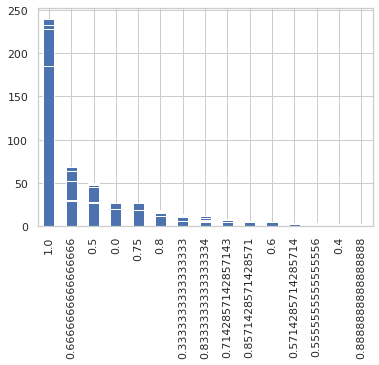

In [ ]:
i = 21
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_21_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model21_evaluation_complex', 'wb') as fp:
    pickle.dump(model_21_result, fp)


In [ ]:
i = 21
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_21_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model21_evaluation_complex_NE', 'wb') as fp:
    pickle.dump(model_21_result, fp)


## model 22

pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/00/asset.0.simple.test
{'bleu': 77.819, 'sari': 43.663, 'fkgl': 6.33, 'quality_estimation': {'Compression ratio': 0.853, 'Sentence splits': 1.257, 'Levenshtein similarity': 0.82, 'Exact copies': 0.0, 'Additions proportion': 0.158, 'Deletions proportion': 0.255, 'Lexical complexity score': 7.992}}
model id: model_22_local_1629750798219
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.832689
std        0.253107
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/00/asset.1.simple.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 77.54, 'sari': 43.655, 'fkgl': 6.25, 'quality_estimation': {'Compression ratio': 0.854, 'Sentence splits': 1.269, 'Levenshtein similarity': 0.819, 'Exact copies': 0.0, 'Additions proportion': 0.162, 'Deletions proportion': 0.255, 'Lexical complexity score': 7.979}}
model id: model_22_local_1629750798219
dataset: asset
blue: 77.819 0.0
sari: 43.663 0.0
fkgl: 6.33 0.0
count    318.000000
mean       0.834325
std        0.247789
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/00/asset.2.simple.test
{'bleu': 78.081, 'sari': 43.613, 'fkgl': 6.28, 'quality_estimation': {'Compression ratio': 0.855, 'Sentence splits': 1.268, 'Levenshtein similarity': 0.821, 'Exact copies': 0.0, 'Additions proportion': 0.161, 'Deletions proportion': 0.254, 'Lexical complexity score': 7.975}}
model id: model_22_local_1629750798219
dataset: asset
b

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 76.511, 'sari': 43.776, 'fkgl': 6.264, 'quality_estimation': {'Compression ratio': 0.857, 'Sentence splits': 1.272, 'Levenshtein similarity': 0.816, 'Exact copies': 0.0, 'Additions proportion': 0.168, 'Deletions proportion': 0.258, 'Lexical complexity score': 7.971}}
model id: model_22_local_1629750798219
dataset: asset
blue: 76.736 0.0
sari: 43.766 0.0
fkgl: 6.258 0.0
count    318.000000
mean       0.805623
std        0.271818
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/01/asset.2.simple.test
{'bleu': 76.015, 'sari': 43.679, 'fkgl': 6.239, 'quality_estimation': {'Compression ratio': 0.856, 'Sentence splits': 1.276, 'Levenshtein similarity': 0.815, 'Exact copies': 0.0, 'Additions proportion': 0.168, 'Deletions proportion': 0.261, 'Lexical complexity score': 7.964}}
model id: model_22_local_1629750798219
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 75.626, 'sari': 43.168, 'fkgl': 6.27, 'quality_estimation': {'Compression ratio': 0.857, 'Sentence splits': 1.272, 'Levenshtein similarity': 0.818, 'Exact copies': 0.0, 'Additions proportion': 0.169, 'Deletions proportion': 0.259, 'Lexical complexity score': 7.992}}
model id: model_22_local_1629750798219
dataset: asset
blue: 76.185 0.0
sari: 42.958 0.0
fkgl: 6.282 0.0
count    318.000000
mean       0.812218
std        0.276742
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/02/asset.2.simple.test
{'bleu': 75.656, 'sari': 43.162, 'fkgl': 6.277, 'quality_estimation': {'Compression ratio': 0.858, 'Sentence splits': 1.269, 'Levenshtein similarity': 0.818, 'Exact copies': 0.0, 'Additions proportion': 0.166, 'Deletions proportion': 0.256, 'Lexical complexity score': 8.01}}
model id: model_22_local_1629750798219
dataset: asset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 74.929, 'sari': 42.971, 'fkgl': 6.315, 'quality_estimation': {'Compression ratio': 0.856, 'Sentence splits': 1.246, 'Levenshtein similarity': 0.815, 'Exact copies': 0.0, 'Additions proportion': 0.166, 'Deletions proportion': 0.257, 'Lexical complexity score': 7.97}}
model id: model_22_local_1629750798219
dataset: asset
blue: 74.791 0.0
sari: 42.94 0.0
fkgl: 6.236 0.0
count    318.000000
mean       0.792422
std        0.282919
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/03/asset.2.simple.test
{'bleu': 75.203, 'sari': 42.872, 'fkgl': 6.217, 'quality_estimation': {'Compression ratio': 0.853, 'Sentence splits': 1.268, 'Levenshtein similarity': 0.814, 'Exact copies': 0.0, 'Additions proportion': 0.167, 'Deletions proportion': 0.261, 'Lexical complexity score': 8.013}}
model id: model_22_local_1629750798219
dataset: asset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 74.281, 'sari': 42.568, 'fkgl': 6.174, 'quality_estimation': {'Compression ratio': 0.856, 'Sentence splits': 1.283, 'Levenshtein similarity': 0.809, 'Exact copies': 0.0, 'Additions proportion': 0.175, 'Deletions proportion': 0.262, 'Lexical complexity score': 8.001}}
model id: model_22_local_1629750798219
dataset: asset
blue: 74.771 0.0
sari: 42.468 0.0
fkgl: 6.134 0.0
count    318.000000
mean       0.781424
std        0.286399
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/04/asset.2.simple.test
{'bleu': 74.3, 'sari': 42.638, 'fkgl': 6.11, 'quality_estimation': {'Compression ratio': 0.859, 'Sentence splits': 1.295, 'Levenshtein similarity': 0.81, 'Exact copies': 0.0, 'Additions proportion': 0.179, 'Deletions proportion': 0.263, 'Lexical complexity score': 8.001}}
model id: model_22_local_1629750798219
dataset: asset
b

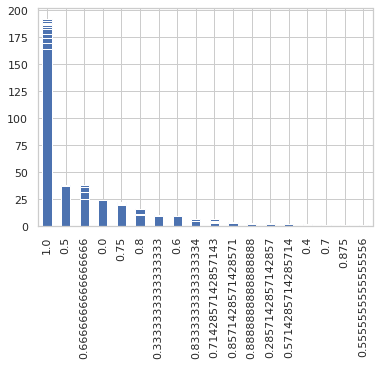

In [ ]:
i = 22
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_22_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model22_evaluation', 'wb') as fp:
    pickle.dump(model_22_result, fp)


pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/00/asset.complex.test
{'bleu': 77.834, 'sari': 43.763, 'fkgl': 6.279, 'quality_estimation': {'Compression ratio': 0.857, 'Sentence splits': 1.272, 'Levenshtein similarity': 0.819, 'Exact copies': 0.0, 'Additions proportion': 0.164, 'Deletions proportion': 0.256, 'Lexical complexity score': 7.973}}
model id: model_22_local_1629750798219
dataset: asset
count    351.000000
mean       0.866445
std        0.229821
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/01/asset.complex.test
{'bleu': 76.738, 'sari': 43.506, 'fkgl': 6.235, 'quality_estimation': {'Compression ratio': 0.858, 'Sentence splits': 1.284, 'Levenshtein similarity': 0.818, 'Exact copies': 0.0, 'Additions proportion': 0.168, 'Deletions proportion': 0.259, 'Lexical complexity score': 7.98}}
model i

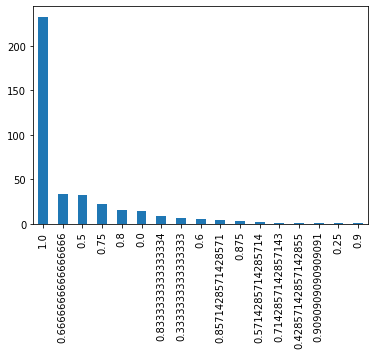

In [ ]:
i = 22
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model22_evaluation_all_complex_NE_retain_rate', 'wb') as fp:
    pickle.dump([bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list], fp)


## model 22 complex

pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/05/asset.0.complex.test
{'bleu': 77.819, 'sari': 43.663, 'fkgl': 6.33, 'quality_estimation': {'Compression ratio': 0.853, 'Sentence splits': 1.257, 'Levenshtein similarity': 0.82, 'Exact copies': 0.0, 'Additions proportion': 0.158, 'Deletions proportion': 0.255, 'Lexical complexity score': 7.992}}
model id: model_22_local_1629750798219
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.832689
std        0.253107
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/05/asset.1.complex.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 77.581, 'sari': 43.75, 'fkgl': 6.231, 'quality_estimation': {'Compression ratio': 0.855, 'Sentence splits': 1.275, 'Levenshtein similarity': 0.819, 'Exact copies': 0.0, 'Additions proportion': 0.163, 'Deletions proportion': 0.255, 'Lexical complexity score': 7.982}}
model id: model_22_local_1629750798219
dataset: asset
blue: 77.819 0.0
sari: 43.663 0.0
fkgl: 6.33 0.0
count    318.000000
mean       0.836684
std        0.246572
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/05/asset.2.complex.test
{'bleu': 78.218, 'sari': 43.666, 'fkgl': 6.269, 'quality_estimation': {'Compression ratio': 0.856, 'Sentence splits': 1.274, 'Levenshtein similarity': 0.821, 'Exact copies': 0.0, 'Additions proportion': 0.162, 'Deletions proportion': 0.255, 'Lexical complexity score': 7.98}}
model id: model_22_local_1629750798219
dataset: asset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 76.725, 'sari': 43.8, 'fkgl': 6.248, 'quality_estimation': {'Compression ratio': 0.855, 'Sentence splits': 1.272, 'Levenshtein similarity': 0.815, 'Exact copies': 0.0, 'Additions proportion': 0.168, 'Deletions proportion': 0.26, 'Lexical complexity score': 7.971}}
model id: model_22_local_1629750798219
dataset: asset
blue: 76.736 0.0
sari: 43.766 0.0
fkgl: 6.258 0.0
count    318.000000
mean       0.805373
std        0.269383
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/06/asset.2.complex.test
{'bleu': 76.077, 'sari': 43.473, 'fkgl': 6.25, 'quality_estimation': {'Compression ratio': 0.855, 'Sentence splits': 1.273, 'Levenshtein similarity': 0.815, 'Exact copies': 0.0, 'Additions proportion': 0.168, 'Deletions proportion': 0.261, 'Lexical complexity score': 7.959}}
model id: model_22_local_1629750798219
dataset: asset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 75.65, 'sari': 43.095, 'fkgl': 6.249, 'quality_estimation': {'Compression ratio': 0.855, 'Sentence splits': 1.272, 'Levenshtein similarity': 0.817, 'Exact copies': 0.0, 'Additions proportion': 0.168, 'Deletions proportion': 0.26, 'Lexical complexity score': 7.982}}
model id: model_22_local_1629750798219
dataset: asset
blue: 76.185 0.0
sari: 42.958 0.0
fkgl: 6.282 0.0
count    318.000000
mean       0.807064
std        0.280994
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/07/asset.2.complex.test
{'bleu': 75.744, 'sari': 43.204, 'fkgl': 6.267, 'quality_estimation': {'Compression ratio': 0.858, 'Sentence splits': 1.272, 'Levenshtein similarity': 0.818, 'Exact copies': 0.0, 'Additions proportion': 0.167, 'Deletions proportion': 0.256, 'Lexical complexity score': 7.998}}
model id: model_22_local_1629750798219
dataset: asse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 74.651, 'sari': 42.887, 'fkgl': 6.264, 'quality_estimation': {'Compression ratio': 0.855, 'Sentence splits': 1.249, 'Levenshtein similarity': 0.815, 'Exact copies': 0.0, 'Additions proportion': 0.168, 'Deletions proportion': 0.257, 'Lexical complexity score': 7.972}}
model id: model_22_local_1629750798219
dataset: asset
blue: 74.791 0.0
sari: 42.94 0.0
fkgl: 6.236 0.0
count    318.000000
mean       0.793819
std        0.279379
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/08/asset.2.complex.test
{'bleu': 75.253, 'sari': 42.786, 'fkgl': 6.234, 'quality_estimation': {'Compression ratio': 0.855, 'Sentence splits': 1.264, 'Levenshtein similarity': 0.815, 'Exact copies': 0.0, 'Additions proportion': 0.165, 'Deletions proportion': 0.258, 'Lexical complexity score': 8.002}}
model id: model_22_local_1629750798219
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 74.044, 'sari': 42.523, 'fkgl': 6.191, 'quality_estimation': {'Compression ratio': 0.857, 'Sentence splits': 1.278, 'Levenshtein similarity': 0.809, 'Exact copies': 0.0, 'Additions proportion': 0.175, 'Deletions proportion': 0.263, 'Lexical complexity score': 8.003}}
model id: model_22_local_1629750798219
dataset: asset
blue: 74.771 0.0
sari: 42.468 0.0
fkgl: 6.134 0.0
count    318.000000
mean       0.777306
std        0.291314
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/09/asset.2.complex.test
{'bleu': 74.359, 'sari': 42.531, 'fkgl': 6.095, 'quality_estimation': {'Compression ratio': 0.86, 'Sentence splits': 1.298, 'Levenshtein similarity': 0.81, 'Exact copies': 0.0, 'Additions proportion': 0.178, 'Deletions proportion': 0.262, 'Lexical complexity score': 8.002}}
model id: model_22_local_1629750798219
dataset: asse

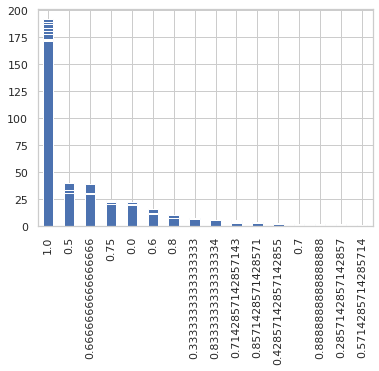

In [ ]:
i = 22
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_22_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model22_evaluation_complex', 'wb') as fp:
    pickle.dump(model_22_result, fp)


pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/05/asset.0.complex.test
{'bleu': 77.819, 'sari': 43.663, 'fkgl': 6.33, 'quality_estimation': {'Compression ratio': 0.853, 'Sentence splits': 1.257, 'Levenshtein similarity': 0.82, 'Exact copies': 0.0, 'Additions proportion': 0.158, 'Deletions proportion': 0.255, 'Lexical complexity score': 7.992}}
model id: model_22_local_1629750798219
dataset: asset
count    351.000000
mean       0.873622
std        0.225375
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_22_local_1629750798219/05/asset.1.complex.test
{'bleu': 77.581, 'sari': 43.75, 'fkgl': 6.231, 'quality_estimation': {'Compression ratio': 0.855, 'Sentence splits': 1.275, 'Levenshtein similarity': 0.819, 'Exact copies': 0.0, 'Additions proportion': 0.163, 'Deletions proportion': 0.255, 'Lexical complexity score': 7.982}}
model

SyntaxError: ignored

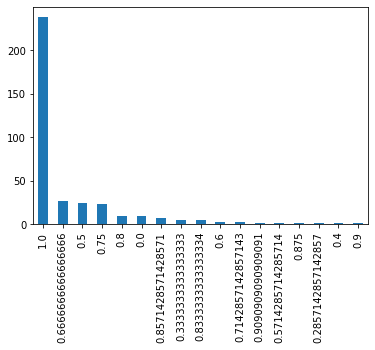

In [ ]:
i = 22
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_22_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model22_evaluation_complex_NE', 'wb') as fp:
    pickle.dump(model_22_result, fp)


## model 23

pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/00/asset.0.simple.test
{'bleu': 72.354, 'sari': 43.811, 'fkgl': 5.615, 'quality_estimation': {'Compression ratio': 0.933, 'Sentence splits': 1.565, 'Levenshtein similarity': 0.813, 'Exact copies': 0.0, 'Additions proportion': 0.219, 'Deletions proportion': 0.237, 'Lexical complexity score': 7.987}}
model id: model_23_local_1629750798219
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.855215
std        0.247968
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/00/asset.1.simple.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 72.331, 'sari': 43.907, 'fkgl': 5.633, 'quality_estimation': {'Compression ratio': 0.933, 'Sentence splits': 1.565, 'Levenshtein similarity': 0.812, 'Exact copies': 0.0, 'Additions proportion': 0.218, 'Deletions proportion': 0.237, 'Lexical complexity score': 7.983}}
model id: model_23_local_1629750798219
dataset: asset
blue: 72.354 0.0
sari: 43.811 0.0
fkgl: 5.615 0.0
count    318.000000
mean       0.849768
std        0.250056
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/00/asset.2.simple.test
{'bleu': 72.331, 'sari': 43.936, 'fkgl': 5.635, 'quality_estimation': {'Compression ratio': 0.934, 'Sentence splits': 1.565, 'Levenshtein similarity': 0.812, 'Exact copies': 0.0, 'Additions proportion': 0.219, 'Deletions proportion': 0.238, 'Lexical complexity score': 7.974}}
model id: model_23_local_1629750798219
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 71.52, 'sari': 43.519, 'fkgl': 5.599, 'quality_estimation': {'Compression ratio': 0.938, 'Sentence splits': 1.561, 'Levenshtein similarity': 0.812, 'Exact copies': 0.0, 'Additions proportion': 0.225, 'Deletions proportion': 0.238, 'Lexical complexity score': 8.012}}
model id: model_23_local_1629750798219
dataset: asset
blue: 71.231 0.0
sari: 43.486 0.0
fkgl: 5.678 0.0
count    318.000000
mean       0.841839
std        0.253471
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/01/asset.2.simple.test
{'bleu': 71.24, 'sari': 43.545, 'fkgl': 5.635, 'quality_estimation': {'Compression ratio': 0.936, 'Sentence splits': 1.552, 'Levenshtein similarity': 0.81, 'Exact copies': 0.0, 'Additions proportion': 0.225, 'Deletions proportion': 0.24, 'Lexical complexity score': 7.99}}
model id: model_23_local_1629750798219
dataset: asset
bl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 70.341, 'sari': 43.172, 'fkgl': 5.696, 'quality_estimation': {'Compression ratio': 0.936, 'Sentence splits': 1.538, 'Levenshtein similarity': 0.809, 'Exact copies': 0.0, 'Additions proportion': 0.228, 'Deletions proportion': 0.239, 'Lexical complexity score': 7.984}}
model id: model_23_local_1629750798219
dataset: asset
blue: 70.415 0.0
sari: 43.097 0.0
fkgl: 5.694 0.0
count    318.000000
mean       0.821357
std        0.262806
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/02/asset.2.simple.test
{'bleu': 70.741, 'sari': 43.095, 'fkgl': 5.688, 'quality_estimation': {'Compression ratio': 0.937, 'Sentence splits': 1.541, 'Levenshtein similarity': 0.809, 'Exact copies': 0.0, 'Additions proportion': 0.227, 'Deletions proportion': 0.239, 'Lexical complexity score': 7.984}}
model id: model_23_local_1629750798219
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 69.95, 'sari': 43.194, 'fkgl': 5.664, 'quality_estimation': {'Compression ratio': 0.934, 'Sentence splits': 1.528, 'Levenshtein similarity': 0.801, 'Exact copies': 0.003, 'Additions proportion': 0.232, 'Deletions proportion': 0.245, 'Lexical complexity score': 7.937}}
model id: model_23_local_1629750798219
dataset: asset
blue: 69.476 0.0
sari: 43.069 0.0
fkgl: 5.655 0.0
count    318.000000
mean       0.820091
std        0.271568
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/03/asset.2.simple.test
{'bleu': 70.446, 'sari': 43.139, 'fkgl': 5.597, 'quality_estimation': {'Compression ratio': 0.934, 'Sentence splits': 1.556, 'Levenshtein similarity': 0.807, 'Exact copies': 0.003, 'Additions proportion': 0.23, 'Deletions proportion': 0.243, 'Lexical complexity score': 7.953}}
model id: model_23_local_1629750798219
dataset: a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 69.474, 'sari': 42.942, 'fkgl': 5.517, 'quality_estimation': {'Compression ratio': 0.94, 'Sentence splits': 1.583, 'Levenshtein similarity': 0.808, 'Exact copies': 0.003, 'Additions proportion': 0.238, 'Deletions proportion': 0.243, 'Lexical complexity score': 7.976}}
model id: model_23_local_1629750798219
dataset: asset
blue: 69.341 0.0
sari: 42.786 0.0
fkgl: 5.516 0.0
count    318.000000
mean       0.824550
std        0.268459
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/04/asset.2.simple.test
{'bleu': 69.539, 'sari': 42.84, 'fkgl': 5.466, 'quality_estimation': {'Compression ratio': 0.936, 'Sentence splits': 1.581, 'Levenshtein similarity': 0.806, 'Exact copies': 0.0, 'Additions proportion': 0.24, 'Deletions proportion': 0.247, 'Lexical complexity score': 7.961}}
model id: model_23_local_1629750798219
dataset: asse

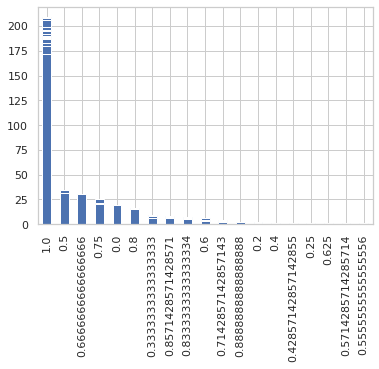

In [ ]:
i = 23
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_23_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model23_evaluation', 'wb') as fp:
    pickle.dump(model_23_result, fp)


pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/00/asset.complex.test
{'bleu': 72.888, 'sari': 43.792, 'fkgl': 5.682, 'quality_estimation': {'Compression ratio': 0.934, 'Sentence splits': 1.548, 'Levenshtein similarity': 0.813, 'Exact copies': 0.003, 'Additions proportion': 0.216, 'Deletions proportion': 0.236, 'Lexical complexity score': 7.98}}
model id: model_23_local_1629750798219
dataset: asset
count    351.000000
mean       0.895899
std        0.206753
min        0.000000
25%        0.833333
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/01/asset.complex.test
{'bleu': 71.803, 'sari': 43.741, 'fkgl': 5.613, 'quality_estimation': {'Compression ratio': 0.932, 'Sentence splits': 1.551, 'Levenshtein similarity': 0.81, 'Exact copies': 0.0, 'Additions proportion': 0.223, 'Deletions proportion': 0.241, 'Lexical complexity score': 8.001}}
model 

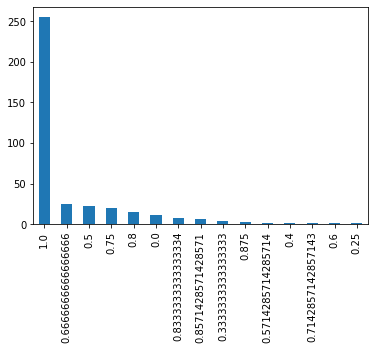

In [ ]:
i = 23
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model23_evaluation_all_complex_NE_retain_rate', 'wb') as fp:
    pickle.dump([bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list], fp)


## model 23 complex

pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/05/asset.0.complex.test
{'bleu': 72.354, 'sari': 43.811, 'fkgl': 5.615, 'quality_estimation': {'Compression ratio': 0.933, 'Sentence splits': 1.565, 'Levenshtein similarity': 0.813, 'Exact copies': 0.0, 'Additions proportion': 0.219, 'Deletions proportion': 0.237, 'Lexical complexity score': 7.987}}
model id: model_23_local_1629750798219
dataset: asset
blue: nan nan
sari: nan nan
fkgl: nan nan
count    318.000000
mean       0.855215
std        0.247968
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/05/asset.1.complex.test


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 72.293, 'sari': 43.918, 'fkgl': 5.629, 'quality_estimation': {'Compression ratio': 0.933, 'Sentence splits': 1.565, 'Levenshtein similarity': 0.812, 'Exact copies': 0.0, 'Additions proportion': 0.218, 'Deletions proportion': 0.238, 'Lexical complexity score': 7.983}}
model id: model_23_local_1629750798219
dataset: asset
blue: 72.354 0.0
sari: 43.811 0.0
fkgl: 5.615 0.0
count    318.000000
mean       0.850030
std        0.249293
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/05/asset.2.complex.test
{'bleu': 72.303, 'sari': 43.922, 'fkgl': 5.664, 'quality_estimation': {'Compression ratio': 0.934, 'Sentence splits': 1.556, 'Levenshtein similarity': 0.813, 'Exact copies': 0.0, 'Additions proportion': 0.219, 'Deletions proportion': 0.237, 'Lexical complexity score': 7.977}}
model id: model_23_local_1629750798219
dataset: as

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 71.426, 'sari': 43.553, 'fkgl': 5.574, 'quality_estimation': {'Compression ratio': 0.938, 'Sentence splits': 1.561, 'Levenshtein similarity': 0.811, 'Exact copies': 0.0, 'Additions proportion': 0.226, 'Deletions proportion': 0.237, 'Lexical complexity score': 8.015}}
model id: model_23_local_1629750798219
dataset: asset
blue: 71.231 0.0
sari: 43.486 0.0
fkgl: 5.678 0.0
count    318.000000
mean       0.842101
std        0.251945
min        0.000000
25%        0.750000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/06/asset.2.complex.test
{'bleu': 71.602, 'sari': 43.683, 'fkgl': 5.612, 'quality_estimation': {'Compression ratio': 0.935, 'Sentence splits': 1.553, 'Levenshtein similarity': 0.809, 'Exact copies': 0.0, 'Additions proportion': 0.226, 'Deletions proportion': 0.24, 'Lexical complexity score': 7.991}}
model id: model_23_local_1629750798219
dataset: ass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 70.312, 'sari': 43.134, 'fkgl': 5.726, 'quality_estimation': {'Compression ratio': 0.936, 'Sentence splits': 1.529, 'Levenshtein similarity': 0.807, 'Exact copies': 0.0, 'Additions proportion': 0.227, 'Deletions proportion': 0.24, 'Lexical complexity score': 7.988}}
model id: model_23_local_1629750798219
dataset: asset
blue: 70.415 0.0
sari: 43.097 0.0
fkgl: 5.694 0.0
count    318.000000
mean       0.820496
std        0.264719
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/07/asset.2.complex.test
{'bleu': 70.63, 'sari': 43.051, 'fkgl': 5.672, 'quality_estimation': {'Compression ratio': 0.935, 'Sentence splits': 1.54, 'Levenshtein similarity': 0.808, 'Exact copies': 0.0, 'Additions proportion': 0.224, 'Deletions proportion': 0.239, 'Lexical complexity score': 7.994}}
model id: model_23_local_1629750798219
dataset: asset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 69.86, 'sari': 43.115, 'fkgl': 5.624, 'quality_estimation': {'Compression ratio': 0.934, 'Sentence splits': 1.528, 'Levenshtein similarity': 0.802, 'Exact copies': 0.003, 'Additions proportion': 0.233, 'Deletions proportion': 0.247, 'Lexical complexity score': 7.947}}
model id: model_23_local_1629750798219
dataset: asset
blue: 69.476 0.0
sari: 43.069 0.0
fkgl: 5.655 0.0
count    318.000000
mean       0.823235
std        0.264845
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/08/asset.2.complex.test
{'bleu': 70.366, 'sari': 43.191, 'fkgl': 5.666, 'quality_estimation': {'Compression ratio': 0.933, 'Sentence splits': 1.538, 'Levenshtein similarity': 0.805, 'Exact copies': 0.003, 'Additions proportion': 0.231, 'Deletions proportion': 0.245, 'Lexical complexity score': 7.958}}
model id: model_23_local_1629750798219
dataset:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWa

{'bleu': 69.564, 'sari': 42.919, 'fkgl': 5.532, 'quality_estimation': {'Compression ratio': 0.94, 'Sentence splits': 1.575, 'Levenshtein similarity': 0.808, 'Exact copies': 0.003, 'Additions proportion': 0.236, 'Deletions proportion': 0.241, 'Lexical complexity score': 7.973}}
model id: model_23_local_1629750798219
dataset: asset
blue: 69.341 0.0
sari: 42.786 0.0
fkgl: 5.516 0.0
count    318.000000
mean       0.822266
std        0.269635
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_23_local_1629750798219/09/asset.2.complex.test
{'bleu': 69.364, 'sari': 42.818, 'fkgl': 5.428, 'quality_estimation': {'Compression ratio': 0.936, 'Sentence splits': 1.585, 'Levenshtein similarity': 0.803, 'Exact copies': 0.0, 'Additions proportion': 0.241, 'Deletions proportion': 0.248, 'Lexical complexity score': 7.957}}
model id: model_23_local_1629750798219
dataset: a

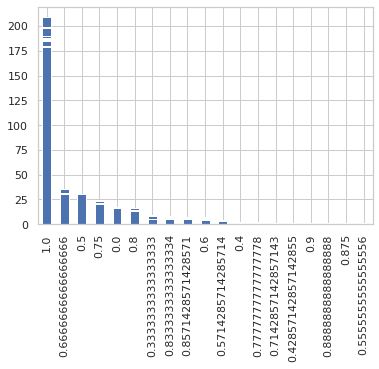

In [ ]:
i = 23
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_23_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model23_evaluation_complex', 'wb') as fp:
    pickle.dump(model_23_result, fp)


In [ ]:
i = 23
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_23_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model23_evaluation_complex_NE', 'wb') as fp:
    pickle.dump(model_23_result, fp)


## model 39

pred_path /content/drive/MyDrive/muss/output/model_39_local_1629750798219/00/asset.0.simple.test
{'bleu': 66.438, 'sari': 44.118, 'fkgl': 5.341, 'quality_estimation': {'Compression ratio': 0.991, 'Sentence splits': 1.639, 'Levenshtein similarity': 0.789, 'Exact copies': 0.0, 'Additions proportion': 0.282, 'Deletions proportion': 0.228, 'Lexical complexity score': 7.781}}
model id: model_39_local_1629750798219
dataset: asset
count    318.000000
mean       0.836201
std        0.256484
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_39_local_1629750798219/00/asset.1.simple.test
{'bleu': 66.655, 'sari': 44.371, 'fkgl': 5.344, 'quality_estimation': {'Compression ratio': 0.994, 'Sentence splits': 1.639, 'Levenshtein similarity': 0.788, 'Exact copies': 0.0, 'Additions proportion': 0.283, 'Deletions proportion': 0.226, 'Lexical complexity score': 7.782}}
mode

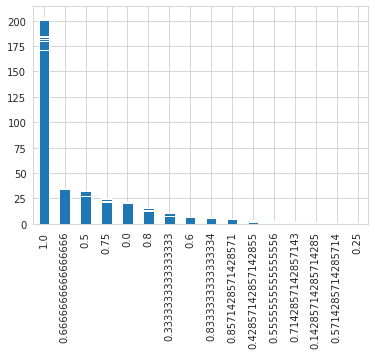

In [ ]:
i = 39
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_39_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model39_evaluation', 'wb') as fp:
    pickle.dump(model_39_result, fp)


pred_path /content/drive/MyDrive/muss/output/model_39_local_1629750798219/00/asset.complex.test
{'bleu': 66.608, 'sari': 44.408, 'fkgl': 5.34, 'quality_estimation': {'Compression ratio': 0.99, 'Sentence splits': 1.634, 'Levenshtein similarity': 0.789, 'Exact copies': 0.0, 'Additions proportion': 0.281, 'Deletions proportion': 0.227, 'Lexical complexity score': 7.762}}
model id: model_39_local_1629750798219
dataset: asset
count    351.000000
mean       0.878582
std        0.224514
min        0.000000
25%        0.800000
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_39_local_1629750798219/01/asset.complex.test
{'bleu': 66.014, 'sari': 44.131, 'fkgl': 5.4, 'quality_estimation': {'Compression ratio': 0.993, 'Sentence splits': 1.628, 'Levenshtein similarity': 0.787, 'Exact copies': 0.003, 'Additions proportion': 0.284, 'Deletions proportion': 0.226, 'Lexical complexity score': 7.758}}
model id

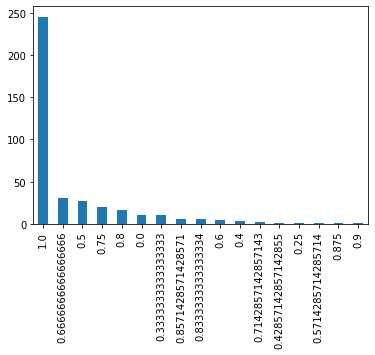

In [ ]:
i = 39
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model39_evaluation_all_complex_NE_retain_rate', 'wb') as fp:
    pickle.dump([bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list], fp)


## model 39 complex

pred_path /content/drive/MyDrive/muss/output/model_39_local_1629750798219/05/asset.0.complex.test
{'bleu': 66.438, 'sari': 44.118, 'fkgl': 5.341, 'quality_estimation': {'Compression ratio': 0.991, 'Sentence splits': 1.639, 'Levenshtein similarity': 0.789, 'Exact copies': 0.0, 'Additions proportion': 0.282, 'Deletions proportion': 0.228, 'Lexical complexity score': 7.781}}
model id: model_39_local_1629750798219
dataset: asset
count    318.000000
mean       0.836201
std        0.256484
min        0.000000
25%        0.666667
50%        1.000000
75%        1.000000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_39_local_1629750798219/05/asset.1.complex.test
{'bleu': 66.575, 'sari': 44.205, 'fkgl': 5.379, 'quality_estimation': {'Compression ratio': 0.994, 'Sentence splits': 1.627, 'Levenshtein similarity': 0.789, 'Exact copies': 0.0, 'Additions proportion': 0.283, 'Deletions proportion': 0.225, 'Lexical complexity score': 7.778}}
mo

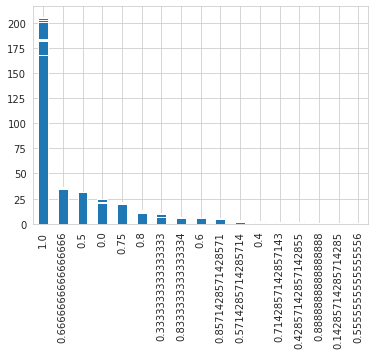

In [ ]:
i = 39
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_39_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model39_evaluation_complex', 'wb') as fp:
    pickle.dump(model_39_result, fp)


In [ ]:
i = 39
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['05','06','07','08','09']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,simple_or_complex='complex')
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_39_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model39_evaluation_complex_NE', 'wb') as fp:
    pickle.dump(model_39_result, fp)


## all combine


In [73]:
id_list = [x for x in range(18,24)]
id_list.append(39)
id_list

[18, 19, 20, 21, 22, 23, 39]

In [74]:
for i in id_list:
  

  with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation', 'rb') as fp:
    var_name = 'model_'+str(i)+'_result'
    globals()[var_name] = pickle.load(fp)


  with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation_complex_NE', 'rb') as fp:
    var_name_complex = 'model_'+str(i)+'_result_complex'
    globals()[var_name_complex] = pickle.load(fp)

  # with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation_complex_NE', 'rb') as fp:
  #   var_name_complex_NE = 'model_'+str(i)+'_complex_NE'
  #   globals()[var_name_complex_NE] = pickle.load(fp)

  with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation_all_complex_NE_retain_rate', 'rb') as fp:
    var_name_complex_NE_single = 'model_'+str(i)+'_complex_NE_single'
    globals()[var_name_complex_NE_single] = pickle.load(fp)
  

  var_name_combined = 'model_'+str(i)+'_result_combine'
  globals()[var_name_combined] = np.array(globals()[var_name_complex])[:,:,:7]
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,8:9]), axis=2)
  globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name_complex_NE_single])), axis=2)
  globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,0:8]), axis=2)
  globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name_complex])[:,:,7:9]), axis=2)
  globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,9:]), axis=2)
  
  # break

In [75]:
final_clrs = []
clrs = sns.color_palette('BrBG')#BrBG,,RdBu,RdGy,RdYlBu,Spectral,YlGnBu,,tab20c
final_clrs = clrs[:2]+clrs[-2:]
final_clrs

[(0.6313725490196078, 0.3951557093425605, 0.09573241061130335),
 (0.8572856593617839, 0.7257977700884274, 0.4471357170319107),
 (0.4615916955017304, 0.7748558246828146, 0.7299500192233758),
 (0.0878892733564014, 0.479123414071511, 0.44775086505190315)]

In [76]:
clrs = sns.color_palette('tab20c')#BrBG,,RdBu,RdGy,RdYlBu,Spectral,YlGnBu,,tab20c
final_clrs.extend(clrs)

In [77]:
sns.reset_orig()  # get default matplotlib styles back

In [78]:
label_list=[
            'complex/complex',
            'complex/simple',
'simple/complex',
'simple/simple',
'both/complex',
'both/simple',
'both/both'

]

In [79]:
color_list=[
            final_clrs[0],
            final_clrs[1],
            final_clrs[2],
            final_clrs[3],
            final_clrs[-4],
            final_clrs[-3],
            final_clrs[-2],

]

In [80]:
marker_list=[
             '8',
             'o',
             's',
             's',
             'P',
             '*',
             'd'

]

In [81]:
ms_list=[8,
         None,
         8,
         None,
         10,
         10,
         10]

In [82]:
fillstyle_list=['none',
                None,
                'none',
                None,
                'none',
                None,
                None,
                None
                
                
                
                ]

In [83]:
linestyle_list=['--',
                None,
                '-.',
                None,
                ':',
                '-',
                None
                
                
                ]

In [84]:
alpha_list=[
            1,
            1,
            1,
            1,
            0.8,
            0.6,
            0.8
]

In [85]:

with open('/content/drive/MyDrive/muss/qualitative/asset_evaluation', 'rb') as fp:
    asset_result = pickle.load(fp)


with open('/content/drive/MyDrive/muss/qualitative/muss_evaluation', 'rb') as fp:
    muss_result = pickle.load(fp)



In [86]:



with open('/content/drive/MyDrive/muss/qualitative/asset_evaluation_complex_NE', 'rb') as fp:
    asset_result_complex_NE = pickle.load(fp)


with open('/content/drive/MyDrive/muss/qualitative/muss_evaluation_complex_NE', 'rb') as fp:
    muss_result_complex_NE = pickle.load(fp)



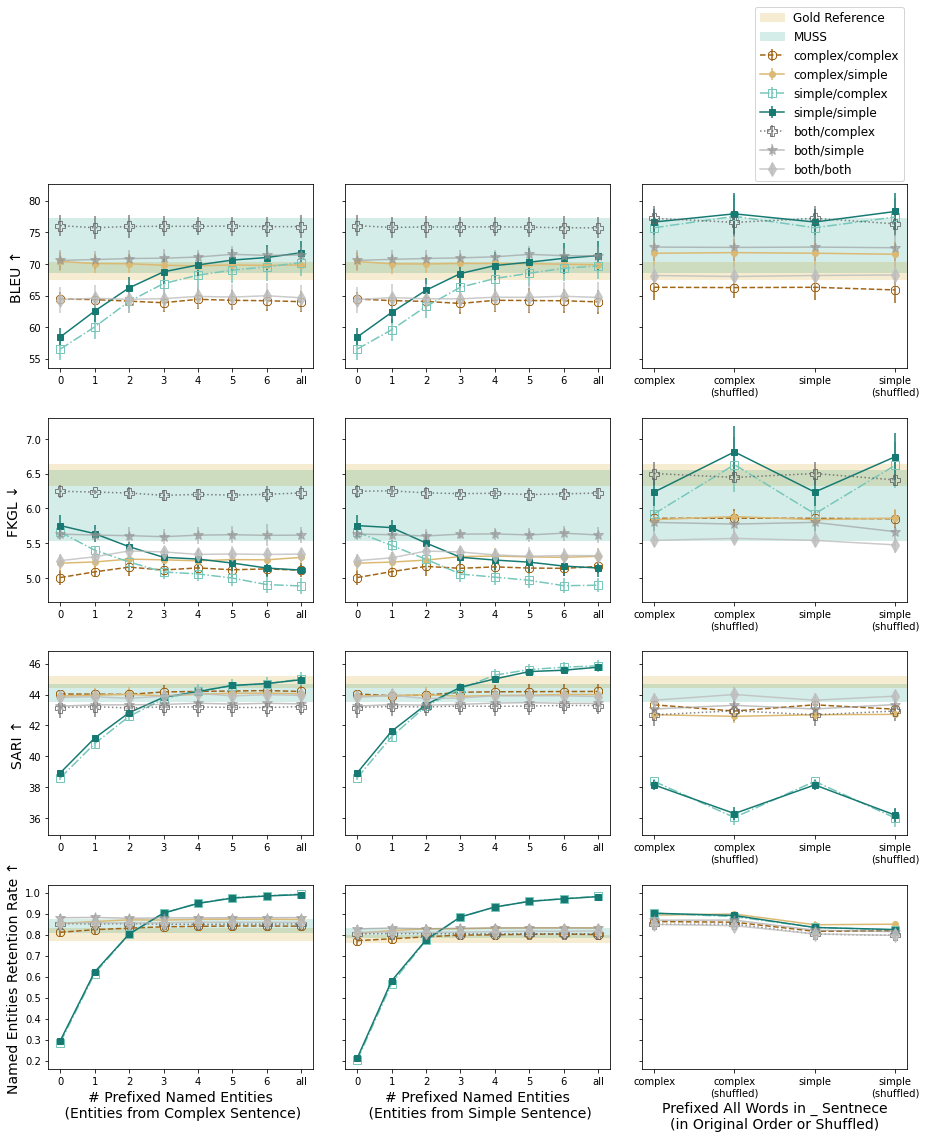

In [101]:
fig, ((ax1, ax2,ax3),(ax4, ax5,ax6),(ax7, ax8,ax9),(ax10, ax11,ax12)) = plt.subplots(ncols=3,nrows=4, sharey='row',figsize=(13,16))

# BLEU
for index_ax,ax in enumerate([ax1,ax2,ax3]):
  ax.axhspan(68.95+1.33, 68.95-1.33, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(72.98+4.28, 72.98-4.28, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(68.95+1.33, 72.98-4.28, alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=2:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    else:
      x_list = ['complex','complex\n(shuffled)','simple','simple\n(shuffled)']
    
    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][0,:,0:8]),axis=0),
                  yerr=get_std(globals()['model_'+str(i)+'_result_combine'][0,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('BLEU ↑',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][0,:,8:16]),axis=0),
                yerr=get_std(globals()['model_'+str(i)+'_result_combine'][0,:,8:16]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )


      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Simple Sentence)',fontsize=14)
    elif index_ax ==2:
    
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][0,:,16:]),axis=0),
                  yerr=get_std(globals()['model_'+str(i)+'_result_combine'][0,:,16:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index]
                  )
      # ax.set_xlabel('Prepended All Words in _ Sentnece\n(in order or shuffled)',fontsize=14)

    else:
      assert False,'wrong index ax'


# FKGL
for index_ax,ax in enumerate([ax4,ax5,ax6]):
  # ax.axhspan(6.05+0.51, 6.05-0.51, alpha=0.3, color='lightcoral',label='MUSS')
  # ax.axhspan(6.49+0.15, 6.49-0.15, alpha=0.5, color='gold',label='Gold Reference')
  ax.axhspan(6.49+0.15, 6.49-0.15, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(6.05+0.51, 6.05-0.51, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(6.05+0.51, 6.49-0.15, alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=2:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    else:
      x_list = ['complex','complex\n(shuffled)','simple','simple\n(shuffled)']
    
    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][2,:,0:8]),axis=0),
                  yerr=get_std(globals()['model_'+str(i)+'_result_combine'][2,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('FKGL ↓',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][2,:,8:16]),axis=0),
                yerr=get_std(globals()['model_'+str(i)+'_result_combine'][2,:,8:16]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )


      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Simple Sentence)',fontsize=14)
    elif index_ax ==2:
    
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][2,:,16:]),axis=0),
                  yerr=get_std(globals()['model_'+str(i)+'_result_combine'][2,:,16:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index]
                  )
      # ax.set_xlabel('Prepended All Words in _ Sentnece\n(in order or shuffled)',fontsize=14)

    else:
      assert False,'wrong index ax'



# SARI
for index_ax,ax in enumerate([ax7,ax8,ax9]):
#   ax.axhspan(44.15-0.56, 44.15+0.56, alpha=0.3, color='lightcoral',label='MUSS')

# ax.axhspan(44.87+0.36, 44.87-0.36, alpha=0.5, color='gold',label='Gold Reference')

  ax.axhspan(44.87+0.36, 44.87-0.36, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(44.15-0.56, 44.15+0.56, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(44.15+0.56, 44.87-0.36, alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=2:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    else:
      x_list = ['complex','complex\n(shuffled)','simple','simple\n(shuffled)']
    
    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][1,:,0:8]),axis=0),
                  yerr=get_std(globals()['model_'+str(i)+'_result_combine'][1,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('SARI ↑',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][1,:,8:16]),axis=0),
                yerr=get_std(globals()['model_'+str(i)+'_result_combine'][1,:,8:16]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )


      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Simple Sentence)',fontsize=14)
    elif index_ax ==2:
    
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][1,:,16:]),axis=0),
                  yerr=get_std(globals()['model_'+str(i)+'_result_combine'][1,:,16:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index]
                  )
      # ax.set_xlabel('Prepended All Words in _ Sentnece\n(in order or shuffled)',fontsize=14)

    else:
      assert False,'wrong index ax'



# NE retention rate
for index_ax,ax in enumerate([ax10,ax11,ax12]):
  
  if index_ax == 0:
    ax.axhspan(np.mean(asset_result_complex_NE[3])+get_mean_confidence_interval(asset_result_complex_NE[3]), np.mean(asset_result_complex_NE[3])-get_mean_confidence_interval(asset_result_complex_NE[3]), alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
    ax.axhspan(np.mean(muss_result_complex_NE[3])+get_mean_confidence_interval(muss_result_complex_NE[3]), np.mean(muss_result_complex_NE[3])-get_mean_confidence_interval(muss_result_complex_NE[3]), alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
    ax.axhspan(np.mean(muss_result_complex_NE[3])-get_mean_confidence_interval(muss_result_complex_NE[3]), np.mean(asset_result_complex_NE[3])+get_mean_confidence_interval(asset_result_complex_NE[3]), alpha=1, color='#cddbbf')

  if index_ax == 1:
    ax.axhspan(np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), np.mean(asset_result[3])-get_mean_confidence_interval(asset_result[3]), alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
    ax.axhspan(np.mean(muss_result[3])+get_mean_confidence_interval(muss_result[3]), np.mean(muss_result[3])-get_mean_confidence_interval(muss_result[3]), alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
    ax.axhspan(np.mean(muss_result[3])-get_mean_confidence_interval(muss_result[3]), np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=2:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    else:
      x_list = ['complex','complex\n(shuffled)','simple','simple\n(shuffled)']
  

    if index_ax == 0:
      
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][3,:,0:8]),axis=0),
                  yerr=get_std(globals()['model_'+str(i)+'_result_combine'][3,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )
     
      ax.set_ylabel('Named Entities Retention Rate ↑',fontsize=14)
      ax.set_xlabel('# Prefixed Named Entities\n (Entities from Complex Sentence)',fontsize=14)



    elif index_ax ==1:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][3,:,8:16]),axis=0),
                yerr=get_std(globals()['model_'+str(i)+'_result_combine'][3,:,8:16]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )


      ax.set_xlabel('# Prefixed Named Entities\n (Entities from Simple Sentence)',fontsize=14)
    elif index_ax ==2:
    
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'][3,:,16:]),axis=0),
                  yerr=get_std(globals()['model_'+str(i)+'_result_combine'][3,:,16:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index]
                  )
      ax.set_xlabel('Prefixed All Words in _ Sentnece\n(in Original Order or Shuffled)',fontsize=14)

    else:
      assert False,'wrong index ax'

# ax.legend(loc='lower right',bbox_to_anchor=(1.5,-0.02,0,0),fontsize='large')
ax3.legend(loc='upper right',bbox_to_anchor=(1.01,2,0,0),fontsize='large')
# for label in ax.get_xticklabels():
#     label.set_ha("right")
#     label.set_rotation(45)


plt.tight_layout()

# plt.savefig('all_result.pdf',bbox_inches='tight')
plt.show()

In [ ]:
cd /content

/content


# operation lexical simplification

## model 37 ABCD

In [ ]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_0words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_1words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_2words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_3words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_4words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_5words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_6words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_C1C2B2/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_all_words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_all_words_random_0911/test.complex'],
 ['asset.0.ABCD.test',
  'asset.1.ABCD.test',
  'asset.2.ABCD.test',
  'asset.3.ABCD.test',
  'asset.4.ABCD.tes

pred_path /content/drive/MyDrive/muss/output/model_37_local_1631390882572/00/asset.0.ABCD.test
{'bleu': 59.287, 'sari': 41.853, 'fkgl': 6.007, 'quality_estimation': {'Compression ratio': 1.175, 'Sentence splits': 1.782, 'Levenshtein similarity': 0.752, 'Exact copies': 0.0, 'Additions proportion': 0.351, 'Deletions proportion': 0.148, 'Lexical complexity score': 7.915}}
model id: model_37_local_1631390882572
dataset: asset
count    280.000000
mean       0.706763
std        0.349367
min        0.000000
25%        0.500000
50%        0.800000
75%        1.000000
max        1.000000
Name: hard_word_remain_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_37_local_1631390882572/00/asset.1.ABCD.test
{'bleu': 57.242, 'sari': 43.168, 'fkgl': 5.811, 'quality_estimation': {'Compression ratio': 1.169, 'Sentence splits': 1.779, 'Levenshtein similarity': 0.734, 'Exact copies': 0.0, 'Additions proportion': 0.373, 'Deletions proportion': 0.166, 'Lexical complexity score': 7.8

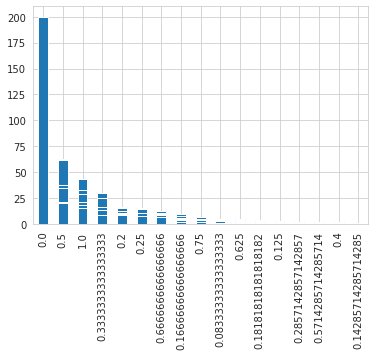

In [ ]:
i = 37
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,ABCD=True)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_37_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model37_evaluation_ABCD', 'wb') as fp:
    pickle.dump(model_37_result, fp)


## model 38 ABCD

In [ ]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_0words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_1words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_2words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_3words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_4words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_5words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_6words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_C1C2B2/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_all_words_0911/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_all_words_random_0911/test.complex'],
 ['asset.0.ABCD.test',
  'asset.1.ABCD.test',
  'asset.2.ABCD.test',
  'asset.3.ABCD.test',
  'asset.4.ABCD.tes

pred_path /content/drive/MyDrive/muss/output/model_38_local_1631390826128/00/asset.0.ABCD.test
{'bleu': 57.24, 'sari': 42.578, 'fkgl': 6.039, 'quality_estimation': {'Compression ratio': 1.132, 'Sentence splits': 1.695, 'Levenshtein similarity': 0.695, 'Exact copies': 0.0, 'Additions proportion': 0.361, 'Deletions proportion': 0.186, 'Lexical complexity score': 7.953}}
model id: model_38_local_1631390826128
dataset: asset
count    280.000000
mean       0.634168
std        0.379260
min        0.000000
25%        0.333333
50%        0.750000
75%        1.000000
max        1.000000
Name: hard_word_remain_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_38_local_1631390826128/00/asset.1.ABCD.test
{'bleu': 56.061, 'sari': 43.025, 'fkgl': 5.965, 'quality_estimation': {'Compression ratio': 1.127, 'Sentence splits': 1.68, 'Levenshtein similarity': 0.683, 'Exact copies': 0.0, 'Additions proportion': 0.376, 'Deletions proportion': 0.197, 'Lexical complexity score': 7.831

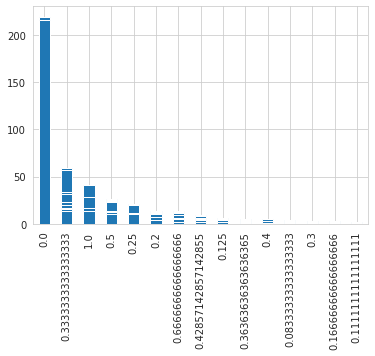

In [ ]:
i = 38
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,ABCD=True)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_38_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model38_evaluation_ABCD', 'wb') as fp:
    pickle.dump(model_38_result, fp)


## model 37 38 combine


In [102]:
id_list=[37,38]

In [103]:
for i in id_list:
  with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation_ABCD', 'rb') as fp:
    var_name = 'model_'+str(i)+'_result_combine'
    globals()[var_name] = pickle.load(fp)

  # with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation_complex', 'rb') as fp:
  #   var_name_complex = 'model_'+str(i)+'_result_complex'
  #   globals()[var_name_complex] = pickle.load(fp)

  # var_name_combined = 'model_'+str(i)+'_result_combine'
  # globals()[var_name_combined] = np.array(globals()[var_name_complex])[:,:,:7]
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,8:9]), axis=2)
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,0:8]), axis=2)
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name_complex])[:,:,7:9]), axis=2)
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,9:]), axis=2)
  
  # break

In [104]:
final_clrs = []
clrs = sns.color_palette('BrBG')#BrBG,,RdBu,RdGy,RdYlBu,Spectral,YlGnBu,,tab20c
final_clrs.extend(clrs)

In [105]:
clrs = sns.color_palette('tab20c')#BrBG,,RdBu,RdGy,RdYlBu,Spectral,YlGnBu,,tab20c
clrs
final_clrs.extend(clrs)

In [106]:
sns.reset_orig()  # get default matplotlib styles back

In [107]:
label_list=[
            'all pairs',
'filtered pairs',

]

In [108]:
color_list=[
            final_clrs[0],
            final_clrs[5],


]

In [109]:
marker_list=[
             '8',
             's',

]

In [110]:
ms_list=[None,
         None,
]

In [111]:
fillstyle_list=[None,
                None,

                
                
                
                ]

In [112]:
linestyle_list=['--',
                None,
                
                
                ]

In [113]:
alpha_list=[
            1,
            1,

]

In [114]:

with open('/content/drive/MyDrive/muss/qualitative/asset_evaluation_ABCD', 'rb') as fp:
    asset_result = pickle.load(fp)


with open('/content/drive/MyDrive/muss/qualitative/muss_evaluation_ABCD', 'rb') as fp:
    muss_result = pickle.load(fp)



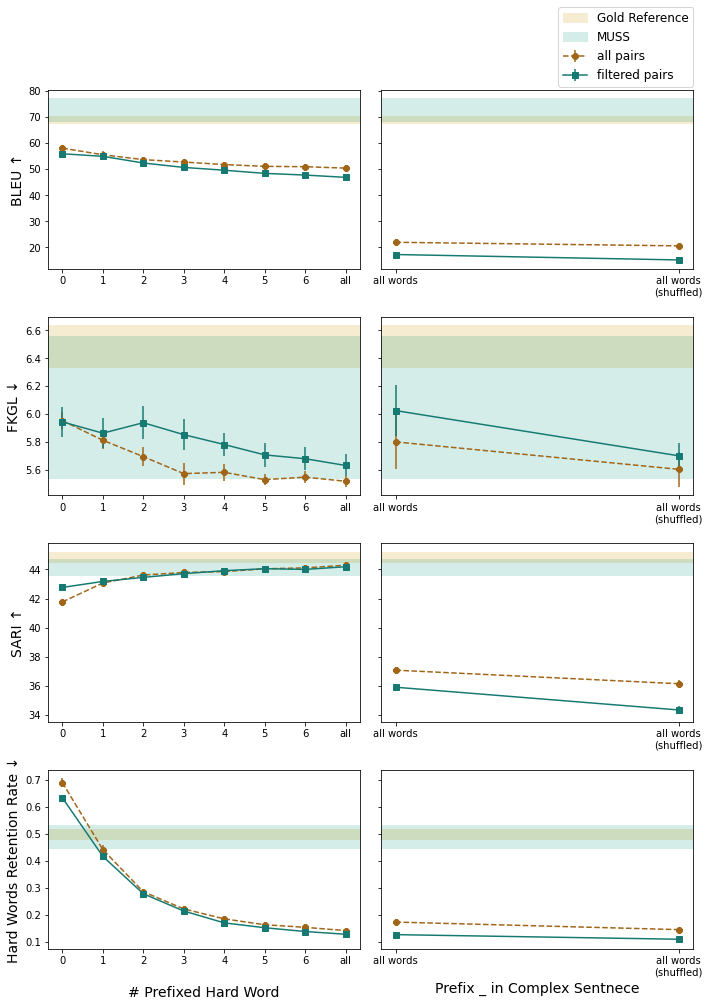

In [115]:

fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(ncols=2,nrows=4, sharey='row',figsize=(10,14))

# BLEU
for index_ax,ax in enumerate([ax1,ax2]):
  ax.axhspan(68.95+1.33, 68.95-1.33, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(72.98+4.28, 72.98-4.28, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(68.95+1.33, 72.98-4.28, alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    else:
      x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('BLEU ↑',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )




# FKGL
for index_ax,ax in enumerate([ax3,ax4]):
  ax.axhspan(6.49+0.15, 6.49-0.15, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(6.05+0.51, 6.05-0.51, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(6.05+0.51, 6.49-0.15, alpha=1, color='#cddbbf')


  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    else:
      x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('FKGL ↓',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )



# SARI
for index_ax,ax in enumerate([ax5,ax6]):

  ax.axhspan(44.87+0.36, 44.87-0.36, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(44.15-0.56, 44.15+0.56, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(44.15+0.56, 44.87-0.36, alpha=1, color='#cddbbf')

  
  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    else:
      x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('SARI ↑',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )
    



# hard word retention rate
for index_ax,ax in enumerate([ax7,ax8]):
  
  ax.axhspan(np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), np.mean(asset_result[3])-get_mean_confidence_interval(asset_result[3]), alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(np.mean(muss_result[3])+get_mean_confidence_interval(muss_result[3]), np.mean(muss_result[3])-get_mean_confidence_interval(muss_result[3]), alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), np.mean(asset_result[3])-get_mean_confidence_interval(asset_result[3]), alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    else:
      x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('Hard Words Retention Rate ↓',fontsize=14)
      ax.set_xlabel('\n# Prefixed Hard Word',fontsize=14)

    elif index_ax ==1:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )
      
      ax.set_xlabel('Prefix _ in Complex Sentnece',fontsize=14)
  

# ax.legend(loc='lower right',bbox_to_anchor=(1.5,-0.02,0,0),fontsize='large')
ax2.legend(loc='upper right',bbox_to_anchor=(1.02,1.5,0,0),fontsize='large')
# for label in ax.get_xticklabels():
#     label.set_ha("right")
#     label.set_rotation(45)


plt.tight_layout()

# plt.savefig('ABCD_result.pdf',bbox_inches='tight')
plt.show()

In [ ]:
cd /content

/content


# operation perserving and lexical simplification

## model 40 NER

In [ ]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_0NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_1NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_2NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_3NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_4NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_5NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_6NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_0CERF/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_1CERF/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_2CERF/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_N

pred_path /content/drive/MyDrive/muss/output/model_40_local_1631567843618/00/asset.allCERF.0NE
{'bleu': 50.656, 'sari': 40.503, 'fkgl': 6.167, 'quality_estimation': {'Compression ratio': 0.818, 'Sentence splits': 1.147, 'Levenshtein similarity': 0.674, 'Exact copies': 0.0, 'Additions proportion': 0.32, 'Deletions proportion': 0.406, 'Lexical complexity score': 7.521}}
model id: model_40_local_1631567843618
dataset: asset
count    318.000000
mean       0.254148
std        0.315319
min        0.000000
25%        0.000000
50%        0.142857
75%        0.500000
max        1.000000
Name: NER_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_40_local_1631567843618/00/asset.allCERF.1NE
{'bleu': 56.307, 'sari': 42.916, 'fkgl': 6.335, 'quality_estimation': {'Compression ratio': 0.839, 'Sentence splits': 1.171, 'Levenshtein similarity': 0.705, 'Exact copies': 0.0, 'Additions proportion': 0.294, 'Deletions proportion': 0.375, 'Lexical complexity score': 7.628}}
model id:

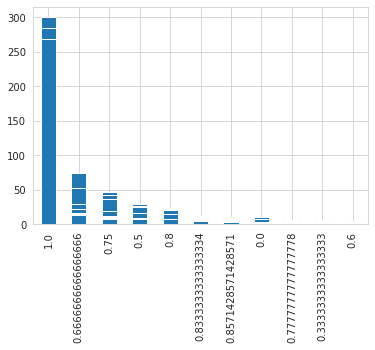

In [ ]:
i = 40
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_40_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model40_evaluation', 'wb') as fp:
    pickle.dump(model_40_result, fp)


## model 40 ABCD

In [ ]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_0NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_1NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_2NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_3NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_4NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_5NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_6NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_0CERF/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_1CERF/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_2CERF/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_N

pred_path /content/drive/MyDrive/muss/output/model_40_local_1631567843618/00/asset.allCERF.0NE
{'bleu': 50.656, 'sari': 40.503, 'fkgl': 6.167, 'quality_estimation': {'Compression ratio': 0.818, 'Sentence splits': 1.147, 'Levenshtein similarity': 0.674, 'Exact copies': 0.0, 'Additions proportion': 0.32, 'Deletions proportion': 0.406, 'Lexical complexity score': 7.521}}
model id: model_40_local_1631567843618
dataset: asset
count    280.000000
mean       0.148763
std        0.262371
min        0.000000
25%        0.000000
50%        0.000000
75%        0.250000
max        1.000000
Name: hard_word_remain_percent, dtype: float64
pred_path /content/drive/MyDrive/muss/output/model_40_local_1631567843618/00/asset.allCERF.1NE
{'bleu': 56.307, 'sari': 42.916, 'fkgl': 6.335, 'quality_estimation': {'Compression ratio': 0.839, 'Sentence splits': 1.171, 'Levenshtein similarity': 0.705, 'Exact copies': 0.0, 'Additions proportion': 0.294, 'Deletions proportion': 0.375, 'Lexical complexity score': 7.62

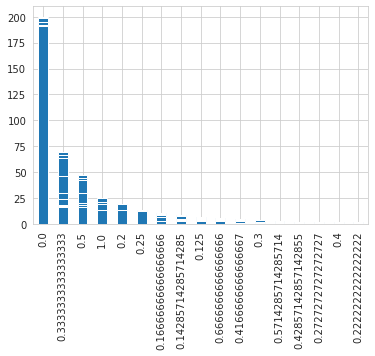

In [ ]:
i = 40
output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2]

bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list = [],[],[],[],[]
for generate_id_list in ['00','01','02','03','04']:#,'05','06']:
    
  dataset = 'asset'
  phase = 'test'

  bleu_list, sari_list, fkgl_list,NE_retain_mean_list,NE_retain_std_list = [],[],[],[],[]
  for output_file_name in test_data_list:
    bleu, sari, fkgl,NE_retain_mean,NE_retain_std = evaluate_my_model(output_id,generate_id_list,dataset,phase,output_file_name,ABCD=True)
    bleu_list.append(bleu)
    sari_list.append(sari)
    fkgl_list.append(fkgl)
    NE_retain_mean_list.append(NE_retain_mean)
    NE_retain_std_list.append(NE_retain_std)
  
  bleu_list_list += [bleu_list]
  sari_list_list += [sari_list]
  fkgl_list_list += [fkgl_list]
  NE_retain_mean_list_list += [NE_retain_mean_list]
  NE_retain_std_list_list += [NE_retain_std_list]

In [ ]:
model_40_result = [bleu_list_list, sari_list_list, fkgl_list_list,NE_retain_mean_list_list,NE_retain_std_list_list]

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/model40_evaluation_ABCD', 'wb') as fp:
    pickle.dump(model_40_result, fp)


## model 40 combine


In [152]:
test_data_dir_list,test_data_list

(['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_0NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_1NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_2NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_3NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_4NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_5NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_6NE/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_0CERF/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_1CERF/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_2CERF/test.complex',
  '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_N

In [153]:
test_data_list[0:8]

['asset.allCERF.0NE',
 'asset.allCERF.1NE',
 'asset.allCERF.2NE',
 'asset.allCERF.3NE',
 'asset.allCERF.4NE',
 'asset.allCERF.5NE',
 'asset.allCERF.6NE',
 'asset.allNE.0CERF']

In [154]:
id_list=[40]

In [155]:
for i in id_list:
  with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation', 'rb') as fp:
    var_name = 'model_'+str(i)+'_result'
    globals()[var_name] = pickle.load(fp)

  with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation_ABCD', 'rb') as fp:
    var_name_ABCD = 'model_'+str(i)+'_result_ABCD'
    globals()[var_name_ABCD] = pickle.load(fp)

  var_name_combined = 'model_'+str(i)+'_result_combine'
  globals()[var_name_combined] = np.array(globals()[var_name])[:,:,:7]
  globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,-1:]), axis=2)
  globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,7:]), axis=2)
  
  var_name_combined = 'model_'+str(i)+'_result_ABCD_combine'
  globals()[var_name_combined] = np.array(globals()[var_name_ABCD])[:,:,:7]
  globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name_ABCD])[:,:,-1:]), axis=2)
  globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name_ABCD])[:,:,7:]), axis=2)

  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name_complex])[:,:,7:9]), axis=2)
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,9:]), axis=2)
  
  # break

In [156]:

for i in [21]:
  with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation', 'rb') as fp:
    var_name = 'model_'+str(i)+'_result'
    globals()[var_name] = pickle.load(fp)

  # with open('/content/drive/MyDrive/muss/qualitative/model'+str(i)+'_evaluation_ABCD', 'rb') as fp:
  #   var_name_ABCD = 'model_'+str(i)+'_result_ABCD'
  #   globals()[var_name_ABCD] = pickle.load(fp)

  var_name_combined = 'model_'+str(i)+'_result_combine'
  globals()[var_name_combined] = np.array(globals()[var_name])[:,:,0:8]
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,-1:]), axis=2)
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,7:]), axis=2)
  
  # var_name_combined = 'model_'+str(i)+'_result_ABCD_combine'
  # globals()[var_name_combined] = np.array(globals()[var_name_ABCD])[:,:,:7]
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name_ABCD])[:,:,-1:]), axis=2)
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name_ABCD])[:,:,7:]), axis=2)

  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name_complex])[:,:,7:9]), axis=2)
  # globals()[var_name_combined] = np.concatenate((np.array(globals()[var_name_combined]), np.array(globals()[var_name])[:,:,9:]), axis=2)
  
  # break

In [157]:
with open('/content/drive/MyDrive/muss/qualitative/model38_evaluation_ABCD', 'rb') as fp:
    var_name = 'model_38_result_combine'
    globals()[var_name] = pickle.load(fp)

    globals()[var_name] = np.array(globals()[var_name])[:,:,0:8]

In [158]:
model_41_result_combine = np.concatenate((model_21_result_combine, model_38_result_combine), axis=2)
model_41_result_combine.shape

(5, 5, 16)

In [159]:
final_clrs = []
clrs = sns.color_palette('BrBG')#BrBG,,RdBu,RdGy,RdYlBu,Spectral,YlGnBu,,tab20c
final_clrs.extend(clrs)

In [160]:
clrs = sns.color_palette('tab20c')#BrBG,,RdBu,RdGy,RdYlBu,Spectral,YlGnBu,,tab20c
clrs
final_clrs.extend(clrs)

In [161]:
sns.reset_orig()  # get default matplotlib styles back

In [162]:
label_list=[
            'simple/simple/filtered pairs',
            'simple/simple',
            'filtered pairs'

]

In [163]:
color_list=[
            # final_clrs[0],
            final_clrs[5],
sns.color_palette('BrBG')[0],
sns.color_palette('BrBG')[1]

]

In [164]:
marker_list=[
             '8',
             's',
             's',

]

In [165]:
ms_list=[None,
         None,
         None
]

In [166]:
fillstyle_list=[None,
                None,
                None

                
                
                
                ]

In [167]:
linestyle_list=[None,
                'dashed',
                'dotted'
                
                
                ]

In [168]:
alpha_list=[
            1,
            1,
            1,

]

In [169]:

with open('/content/drive/MyDrive/muss/qualitative/asset_evaluation', 'rb') as fp:
    asset_result = pickle.load(fp)


with open('/content/drive/MyDrive/muss/qualitative/muss_evaluation', 'rb') as fp:
    muss_result = pickle.load(fp)



In [170]:

with open('/content/drive/MyDrive/muss/qualitative/asset_evaluation_ABCD', 'rb') as fp:
    asset_result_ABCD = pickle.load(fp)


with open('/content/drive/MyDrive/muss/qualitative/muss_evaluation_ABCD', 'rb') as fp:
    muss_result_ABCD = pickle.load(fp)



In [171]:
id_list=[40,41]

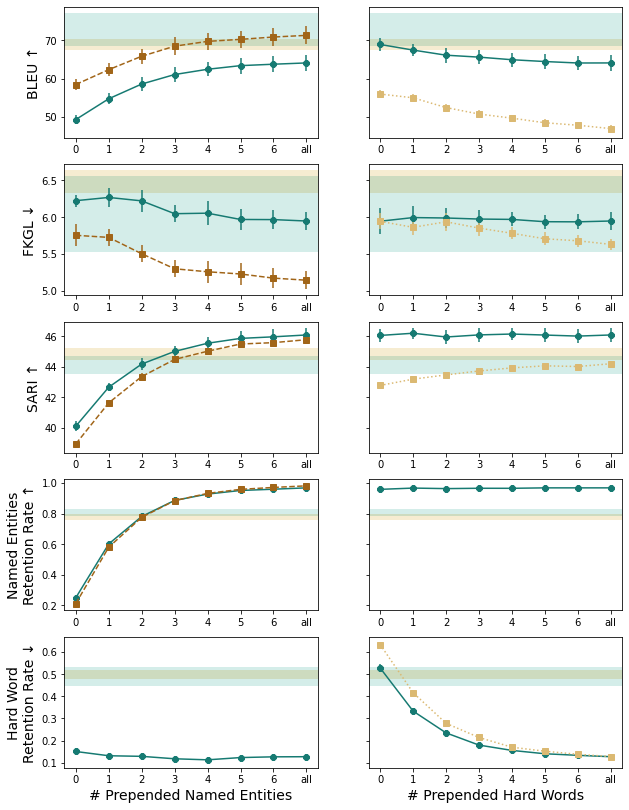

In [173]:

fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6),(ax7, ax8),(ax9, ax10)) = plt.subplots(ncols=2,nrows=5, sharey='row',figsize=(10,14))

# BLEU
for index_ax,ax in enumerate([ax1,ax2]):
  ax.axhspan(68.95+1.33, 68.95-1.33, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(72.98+4.28, 72.98-4.28, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(68.95+1.33, 72.98-4.28, alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('BLEU ↑',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      if index ==0:
        ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index]
                  )
      if index ==1:
        index=2
        ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index]
                  )




# FKGL
for index_ax,ax in enumerate([ax3,ax4]):
  ax.axhspan(6.49+0.15, 6.49-0.15, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(6.05+0.51, 6.05-0.51, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(6.05+0.51, 6.49-0.15, alpha=1, color='#cddbbf')


  # ax.axhspan(68.95+1.33, 68.95-1.33, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  # ax.axhspan(72.98+4.28, 72.98-4.28, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  # ax.axhspan(68.95+1.33, 72.98-4.28, alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('FKGL ↓',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      if index ==1:
        index=2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )



# SARI
for index_ax,ax in enumerate([ax5,ax6]):

  ax.axhspan(44.87+0.36, 44.87-0.36, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(44.15-0.56, 44.15+0.56, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(44.15+0.56, 44.87-0.36, alpha=1, color='#cddbbf')

  
  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('SARI ↑',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      if index ==1:
        index=2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )
    




# NE retention rate
for index_ax,ax in enumerate([ax7,ax8]):
  
  # ax.axhspan(np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), np.mean(asset_result[3])-get_mean_confidence_interval(asset_result[3]), alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  # ax.axhspan(np.mean(muss_result[3])+get_mean_confidence_interval(muss_result[3]), np.mean(muss_result[3])-get_mean_confidence_interval(muss_result[3]), alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  # ax.axhspan(np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), np.mean(asset_result[3])-get_mean_confidence_interval(asset_result[3]), alpha=1, color='#cddbbf')

  ax.axhspan(np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), np.mean(asset_result[3])-get_mean_confidence_interval(asset_result[3]), alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(np.mean(muss_result[3])+get_mean_confidence_interval(muss_result[3]), np.mean(muss_result[3])-get_mean_confidence_interval(muss_result[3]), alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(np.mean(muss_result[3])-get_mean_confidence_interval(muss_result[3]), np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), alpha=1, color='#cddbbf')


  for index,i in enumerate([40]):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('Named Entities\nRetention Rate ↑',fontsize=14)
      # ax.set_xlabel('\n# Prepended Hard Word',fontsize=14)

    elif index_ax ==1:
      if index ==1:
        index=2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )
  
  for index,i in enumerate([41]):

    # if index_ax !=1:
    #   x_list = [str(x) for x in range(7)]
    #   x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      index=1
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

    #   ax.set_ylabel('Named Entities\nRetention Rate ↑',fontsize=14)
    #   # ax.set_xlabel('\n# Prepended Hard Word',fontsize=14)

    # elif index_ax ==1:
    #   ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:],axis=0),
    #             yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
    #             # fmt='-',
    #           #  elinewidth = 0.8,
    #             # capsize = 2, 
    #             label=label_list[index],
    #             color=color_list[index],
    #             marker=marker_list[index],
    #             fillstyle=fillstyle_list[index],
    #             ms=ms_list[index],
    #             linestyle=linestyle_list[index],
    #             alpha=alpha_list[index]
    #             )
    #   # ax.set_xlabel('Prepend _ in Complex Sentnece',fontsize=14)
  


# ABCD retention rate
for index_ax,ax in enumerate([ax9,ax10]):
  
  ax.axhspan(np.mean(asset_result_ABCD[3])+get_mean_confidence_interval(asset_result_ABCD[3]), np.mean(asset_result_ABCD[3])-get_mean_confidence_interval(asset_result_ABCD[3]), alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(np.mean(muss_result_ABCD[3])+get_mean_confidence_interval(muss_result_ABCD[3]), np.mean(muss_result_ABCD[3])-get_mean_confidence_interval(muss_result_ABCD[3]), alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(np.mean(asset_result_ABCD[3])+get_mean_confidence_interval(asset_result_ABCD[3]), np.mean(asset_result_ABCD[3])-get_mean_confidence_interval(asset_result_ABCD[3]), alpha=1, color='#cddbbf')

  for index,i in enumerate([40]):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('Hard Word\nRetention Rate ↓',fontsize=14)
      ax.set_xlabel('# Prepended Named Entities',fontsize=14)

    elif index_ax ==1:
      if index ==1:
        index=2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )
      
      ax.set_xlabel('# Prepended Hard Word',fontsize=14)

  for index,i in enumerate([41]):

    # if index_ax !=1:
    #   x_list = [str(x) for x in range(7)]
    #   x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 1:
      index = 2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      # ax.set_ylabel('Hard Word\nRetention Rate ↓',fontsize=14)
      ax.set_xlabel('# Prepended Hard Words',fontsize=14)

    # elif index_ax ==1:
    #   ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,8:],axis=0),
    #             yerr=get_std(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
    #             # fmt='-',
    #           #  elinewidth = 0.8,
    #             # capsize = 2, 
    #             label=label_list[index],
    #             color=color_list[index],
    #             marker=marker_list[index],
    #             fillstyle=fillstyle_list[index],
    #             ms=ms_list[index],
    #             linestyle=linestyle_list[index],
    #             alpha=alpha_list[index]
    #             )
      
    #   ax.set_xlabel('# Prepended Hard Word\n(each with All Named Entities)',fontsize=14)
  


In [174]:
from matplotlib.patches import Patch

In [ ]:
handles, labels = ax2.get_legend_handles_labels()

In [176]:
handles, labels

([<matplotlib.patches.Polygon at 0x7f1e59388290>,
  <ErrorbarContainer object of 3 artists>,
  <ErrorbarContainer object of 3 artists>],
 ['Gold Reference', 'MUSS', 'simple/simple/filtered pairs', 'filtered pairs'])

In [177]:
handles_new, labels_new = ax3.get_legend_handles_labels()

In [178]:
handles_new, labels_new 

([<matplotlib.patches.Polygon at 0x7f1e5aab0650>,
  <ErrorbarContainer object of 3 artists>,
  <ErrorbarContainer object of 3 artists>],
 ['Gold Reference', 'MUSS', 'simple/simple/filtered pairs', 'simple/simple'])

In [179]:
handles.append(handles_new[-1])
labels.append(labels_new[-1])

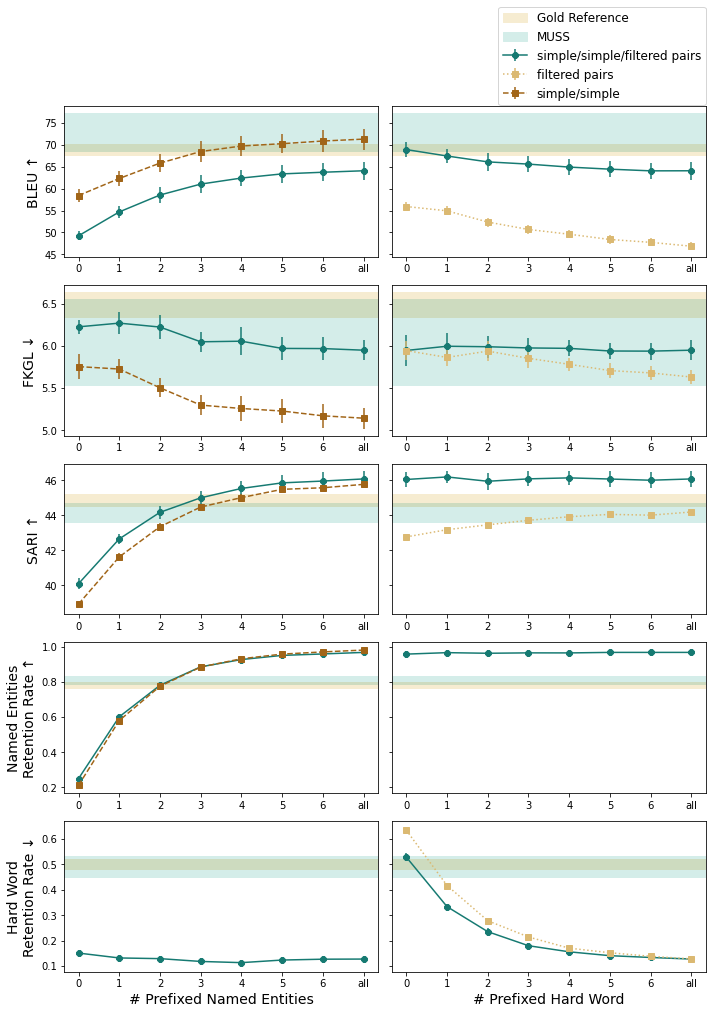

In [182]:

fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6),(ax7, ax8),(ax9, ax10)) = plt.subplots(ncols=2,nrows=5, sharey='row',figsize=(10,14))

# BLEU
for index_ax,ax in enumerate([ax1,ax2]):
  ax.axhspan(68.95+1.33, 68.95-1.33, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(72.98+4.28, 72.98-4.28, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(68.95+1.33, 72.98-4.28, alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('BLEU ↑',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      if index ==0:
        ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index]
                  )
      if index ==1:
        index=2
        ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[0,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index]
                  )




# FKGL
for index_ax,ax in enumerate([ax3,ax4]):
  ax.axhspan(6.49+0.15, 6.49-0.15, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(6.05+0.51, 6.05-0.51, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(6.05+0.51, 6.49-0.15, alpha=1, color='#cddbbf')


  # ax.axhspan(68.95+1.33, 68.95-1.33, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  # ax.axhspan(72.98+4.28, 72.98-4.28, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  # ax.axhspan(68.95+1.33, 72.98-4.28, alpha=1, color='#cddbbf')

  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('FKGL ↓',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      if index ==1:
        index=2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[2,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )



# SARI
for index_ax,ax in enumerate([ax5,ax6]):

  ax.axhspan(44.87+0.36, 44.87-0.36, alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(44.15-0.56, 44.15+0.56, alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(44.15+0.56, 44.87-0.36, alpha=1, color='#cddbbf')

  
  for index,i in enumerate(id_list):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('SARI ↑',fontsize=14)
      # ax.set_xlabel('# Prepended Named Entities\n (Entities from Complex Sentence)',fontsize=14)
    elif index_ax ==1:
      if index ==1:
        index=2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[1,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )
    




# NE retention rate
for index_ax,ax in enumerate([ax7,ax8]):
  
  # ax.axhspan(np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), np.mean(asset_result[3])-get_mean_confidence_interval(asset_result[3]), alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  # ax.axhspan(np.mean(muss_result[3])+get_mean_confidence_interval(muss_result[3]), np.mean(muss_result[3])-get_mean_confidence_interval(muss_result[3]), alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  # ax.axhspan(np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), np.mean(asset_result[3])-get_mean_confidence_interval(asset_result[3]), alpha=1, color='#cddbbf')

  ax.axhspan(np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), np.mean(asset_result[3])-get_mean_confidence_interval(asset_result[3]), alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(np.mean(muss_result[3])+get_mean_confidence_interval(muss_result[3]), np.mean(muss_result[3])-get_mean_confidence_interval(muss_result[3]), alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(np.mean(muss_result[3])-get_mean_confidence_interval(muss_result[3]), np.mean(asset_result[3])+get_mean_confidence_interval(asset_result[3]), alpha=1, color='#cddbbf')


  for index,i in enumerate([40]):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('Named Entities\nRetention Rate ↑',fontsize=14)
      # ax.set_xlabel('\n# Prepended Hard Word',fontsize=14)

    elif index_ax ==1:
      if index ==1:
        index=2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )
  
  for index,i in enumerate([41]):

    # if index_ax !=1:
    #   x_list = [str(x) for x in range(7)]
    #   x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      index=1
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

    #   ax.set_ylabel('Named Entities\nRetention Rate ↑',fontsize=14)
    #   # ax.set_xlabel('\n# Prepended Hard Word',fontsize=14)

    # elif index_ax ==1:
    #   ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:],axis=0),
    #             yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
    #             # fmt='-',
    #           #  elinewidth = 0.8,
    #             # capsize = 2, 
    #             label=label_list[index],
    #             color=color_list[index],
    #             marker=marker_list[index],
    #             fillstyle=fillstyle_list[index],
    #             ms=ms_list[index],
    #             linestyle=linestyle_list[index],
    #             alpha=alpha_list[index]
    #             )
    #   # ax.set_xlabel('Prepend _ in Complex Sentnece',fontsize=14)
  


# ABCD retention rate
for index_ax,ax in enumerate([ax9,ax10]):
  
  ax.axhspan(np.mean(asset_result_ABCD[3])+get_mean_confidence_interval(asset_result_ABCD[3]), np.mean(asset_result_ABCD[3])-get_mean_confidence_interval(asset_result_ABCD[3]), alpha=1, color=sns.color_palette('BrBG')[2],label='Gold Reference')
  ax.axhspan(np.mean(muss_result_ABCD[3])+get_mean_confidence_interval(muss_result_ABCD[3]), np.mean(muss_result_ABCD[3])-get_mean_confidence_interval(muss_result_ABCD[3]), alpha=1, color=sns.color_palette('BrBG')[3],label='MUSS')
  ax.axhspan(np.mean(asset_result_ABCD[3])+get_mean_confidence_interval(asset_result_ABCD[3]), np.mean(asset_result_ABCD[3])-get_mean_confidence_interval(asset_result_ABCD[3]), alpha=1, color='#cddbbf')

  for index,i in enumerate([40]):

    if index_ax !=1:
      x_list = [str(x) for x in range(7)]
      x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 0:
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,0:8],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,0:8]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      ax.set_ylabel('Hard Word\nRetention Rate ↓',fontsize=14)
      ax.set_xlabel('# Prefixed Named Entities',fontsize=14)

    elif index_ax ==1:
      if index ==1:
        index=2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,8:],axis=0),
                yerr=get_std(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                # fmt='-',
              #  elinewidth = 0.8,
                # capsize = 2, 
                label=label_list[index],
                color=color_list[index],
                marker=marker_list[index],
                fillstyle=fillstyle_list[index],
                ms=ms_list[index],
                linestyle=linestyle_list[index],
                alpha=alpha_list[index]
                )
      
      ax.set_xlabel('# Prefixed Hard Word',fontsize=14)

  for index,i in enumerate([41]):

    # if index_ax !=1:
    #   x_list = [str(x) for x in range(7)]
    #   x_list.append('all')
    # else:
    #   x_list = ['all words','all words\n(shuffled)']

    if index_ax == 1:
      index = 2
      ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:],axis=0),
                  yerr=get_std(np.array(globals()['model_'+str(i)+'_result_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
                  # fmt='-',
                #  elinewidth = 0.8,
                  # capsize = 2, 
                  label=label_list[index],
                  color=color_list[index],
                  marker=marker_list[index],
                  fillstyle=fillstyle_list[index],
                  ms=ms_list[index],
                  linestyle=linestyle_list[index],
                  alpha=alpha_list[index],
                  
                  )

      # ax.set_ylabel('Hard Word\nRetention Rate ↓',fontsize=14)
      # ax.set_xlabel('# Prefixed Hard Words',fontsize=14)

    # elif index_ax ==1:
    #   ax.errorbar(x_list, np.mean(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,8:],axis=0),
    #             yerr=get_std(np.array(globals()['model_'+str(i)+'_result_ABCD_combine'])[3,:,8:]),#np.std(np.array(sari_list_list),axis=0),
    #             # fmt='-',
    #           #  elinewidth = 0.8,
    #             # capsize = 2, 
    #             label=label_list[index],
    #             color=color_list[index],
    #             marker=marker_list[index],
    #             fillstyle=fillstyle_list[index],
    #             ms=ms_list[index],
    #             linestyle=linestyle_list[index],
    #             alpha=alpha_list[index]
    #             )
      
    #   ax.set_xlabel('# Prepended Hard Word\n(each with All Named Entities)',fontsize=14)
  


ax2.legend(handles=handles, labels=labels,loc='upper right',bbox_to_anchor=(1.02,1.7,0,0),fontsize='large')


plt.tight_layout()
# plt.savefig('two_ope_result.pdf',bbox_inches='tight')
plt.show()

In [ ]:
cd /content

# SARI operation

In [ ]:
def get_mean_CI_sari_operation(i,generate_id_list,test_data_list,):
  

  output_id = 'model_'+str(i)+'_'+model_dir_dict[i]['exp_dir'].split('/')[-2] # model_18_local_1629593348299

  sari_add_list, sari_keep_list, sari_del_list = [],[],[]

  dataset = 'asset'
  phase = 'test'

  for generate_id in generate_id_list:
    
    tmp_sari_add,tmp_sari_keep,tmp_sari_del=[],[],[]
    for output_file_name in test_data_list:

      sari_add, sari_keep, sari_del = evaluate_my_model_operation(output_id,generate_id,dataset,phase,output_file_name)

      tmp_sari_add.append(sari_add)
      tmp_sari_keep.append(sari_keep)
      tmp_sari_del.append(sari_del)

    sari_add_list += [tmp_sari_add]
    sari_keep_list += [tmp_sari_keep]
    sari_del_list += [tmp_sari_del]

    
  print('model',i)
  print('sari_add',round(np.mean(sari_add_list), 2),'±',round(get_mean_confidence_interval(sari_add_list), 2))
  print('sari_keep_list',round(np.mean(sari_keep_list), 2),'±',round(get_mean_confidence_interval(sari_keep_list), 2))
  print('sari_del_list',round(np.mean(sari_del_list), 2),'±',round(get_mean_confidence_interval(sari_del_list), 2))

  return  sari_add_list,sari_keep_list,sari_del_list

In [ ]:
# second, evalaute 
sari_add_list,sari_keep_list,sari_del_list = get_mean_CI_sari_operation(i,generate_id_list,test_data_list,)

In [ ]:
# first, define the model id and the corsponding generate folder id
# test data can be 'asset.simple.test' and 'asset.complex.test'
i = 18
generate_id_list = ['02','03','04','05','06']
test_data_list = ['asset.simple.test']

In [ ]:
# third, save the result
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_18_complex', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
# Following: repeat for all models

In [ ]:
i = 18
generate_id_list = ['02','03','04','05','06']
test_data_list = ['asset.complex.test']

In [ ]:
i = 19
generate_id_list = ['00','01','02','03','04']
test_data_list = ['asset.complex.test']

In [ ]:
i = 20
generate_id_list = ['00','01','02','03','05']
test_data_list = ['asset.complex.test']

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_20_simple', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_20_complex', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
i = 21
generate_id_list = ['00','01','02','03','04']
test_data_list = ['asset.complex.test']

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_21_simple', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_21_complex', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
i = 21
generate_id_list = ['00','01','02','03','04']
test_data_list = test_data_list[0:8]
test_data_list

['asset.0.simple.test',
 'asset.1.simple.test',
 'asset.2.simple.test',
 'asset.3.simple.test',
 'asset.4.simple.test',
 'asset.5.simple.test',
 'asset.6.simple.test',
 'asset.simple.test']

In [ ]:
np.mean(np.array(sari_add_list),axis=0)

array([ 9.1888, 10.329 , 10.9818, 11.6014, 11.6874, 11.8572, 12.0064,
       12.0276])

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_21_simple_trend', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
i = 22
generate_id_list = ['00','01','02','03','04']
test_data_list = ['asset.complex.test']

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_22_simple', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_22_complex', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:

i = 23
generate_id_list = ['00','01','02','03','04']
test_data_list = ['asset.complex.test']

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_23_simple', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_23_complex', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:

i = 39
generate_id_list = ['00','01','02','03','04']
test_data_list = ['asset.complex.test']

In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_39_simple', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


In [ ]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_39_complex', 'wb') as fp:
    pickle.dump([sari_add_list,sari_keep_list,sari_del_list], fp)


## operation preserving



In [27]:
!pip install matplotlib==3.4

In [28]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_asset', 'rb') as fp:
    asset_ope = pickle.load(fp)

with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_muss', 'rb') as fp:
    muss_ope = pickle.load(fp)

In [29]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_21_simple_trend', 'rb') as fp:
  [sari_add_list,sari_keep_list,sari_del_list] = pickle.load(fp)


In [30]:
df = pd.DataFrame(np.array([  [round(x,1) for x in np.mean(np.array(sari_add_list),axis=0)] ,
[round(x,1) for x in np.mean(np.array(sari_keep_list),axis=0)] ,
[round(x,1) for x in np.mean(np.array(sari_del_list),axis=0)] ,
]).T, columns =['add', 'keep', 'del'], dtype = float)

df

,add,keep,del
0,9.2,50.3,57.3
1,10.3,54.4,60.1
2,11.0,57.6,61.5
3,11.6,59.7,62.1
4,11.7,61.0,62.3
5,11.9,61.8,62.8
6,12.0,62.0,62.7
7,12.0,62.7,62.6


In [31]:
x_list = [str(x) for x in range(7)]
x_list.append('all')
df['x_list']=x_list
df

,add,keep,del,x_list
0,9.2,50.3,57.3,0
1,10.3,54.4,60.1,1
2,11.0,57.6,61.5,2
3,11.6,59.7,62.1,3
4,11.7,61.0,62.3,4
5,11.9,61.8,62.8,5
6,12.0,62.0,62.7,6
7,12.0,62.7,62.6,all


In [32]:
df_ref = pd.DataFrame( columns =['add', 'keep', 'del'], dtype = float)

In [33]:
df_ref.loc[0] =np.array([round(np.mean(muss_ope[0]),1),round(np.mean(muss_ope[1]),1),round(np.mean(muss_ope[2]),1)], dtype = float)

df_ref

,add,keep,del
0,11.1,60.9,60.4


In [34]:
df_ref.loc[1] =np.array([round(np.mean(asset_ope[0]),1),round(np.mean(asset_ope[1]),1),round(np.mean(asset_ope[2]),1)], dtype = float)

df_ref

,add,keep,del
0,11.1,60.9,60.4
1,10.2,58.7,65.7


In [35]:
df_ref['x_list']=['muss','asset']
df_ref

,add,keep,del,x_list
0,11.1,60.9,60.4,muss
1,10.2,58.7,65.7,asset


In [36]:
final_clrs = []
clrs = sns.color_palette('BrBG')#BrBG,,RdBu,RdGy,RdYlBu,Spectral,YlGnBu,,tab20c
final_clrs = clrs
final_clrs

[(0.6313725490196078, 0.3951557093425605, 0.09573241061130335),
 (0.8572856593617839, 0.7257977700884274, 0.4471357170319107),
 (0.9636293733179546, 0.9237985390234525, 0.8185313341022683),
 (0.8299115724721262, 0.9294886582083814, 0.9152633602460593),
 (0.4615916955017304, 0.7748558246828146, 0.7299500192233758),
 (0.0878892733564014, 0.479123414071511, 0.44775086505190315)]

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


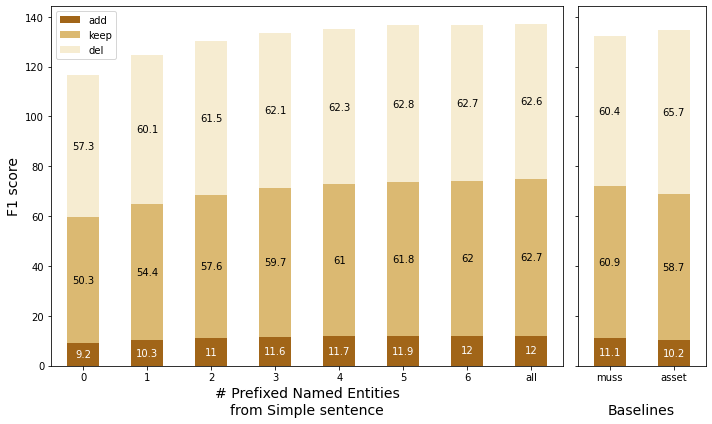

In [37]:

f, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(10, 6),sharey=True)

df.plot(ax=ax,x='x_list',kind='bar', stacked=True, rot=0, xlabel='Class', ylabel='Count', color=final_clrs)
for index,c in enumerate(ax.containers):
    if index !=0:
      ax.bar_label(c, label_type='center')
    else:
      ax.bar_label(c, label_type='center',color='white')


df_ref.plot(ax=ax2,x='x_list',kind='bar', stacked=True,  rot=0, color=final_clrs,legend=False)
for index,c in enumerate(ax2.containers):
    if index !=0:
      ax2.bar_label(c, label_type='center')
    else:
      ax2.bar_label(c, label_type='center',color='white')


# ax.legend(loc='upper right',bbox_to_anchor=(1.01,2,0,0),fontsize='large')
ax.set_ylabel('F1 score',fontsize=14)
ax.set_xlabel('# Prefixed Named Entities\nfrom Simple sentence',fontsize=14)

ax2.set_xlabel('\nBaselines',fontsize=14)

plt.tight_layout()

# plt.savefig('trend_sari_ope.pdf',bbox_inches='tight')
plt.show()

In [38]:
id_list = [x for x in range(18,24)]
id_list.append(39)
id_list

[18, 19, 20, 21, 22, 23, 39]

In [39]:
for i in id_list:
  

  with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_'+str(i)+'_simple', 'rb') as fp:
    var_name = 'model_'+str(i)+'_simple'
    globals()[var_name] = pickle.load(fp)

  with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_'+str(i)+'_complex', 'rb') as fp:
    var_name = 'model_'+str(i)+'_complex'
    globals()[var_name] = pickle.load(fp)



In [41]:
df_all_NE = pd.DataFrame( columns =['add', 'keep', 'del'], dtype = float)

In [42]:
# complex/complex use all complex NE
df_all_NE.loc[0] =np.array([round(np.mean(model_18_complex[0]),1),round(np.mean(model_18_complex[1]),1),round(np.mean(model_18_complex[2]),1)], dtype = float)#,

df_all_NE

,add,keep,del
0,12.1,59.2,61.3


In [43]:
# simple/simple use all ccomplex NE
df_all_NE.loc[1] =np.array([round(np.mean(model_21_complex[0]),1),round(np.mean(model_21_complex[1]),1),round(np.mean(model_21_complex[2]),1)], dtype = float)#,

df_all_NE

,add,keep,del
0,12.1,59.2,61.3
1,11.7,62.3,60.9


In [44]:
# simple/simple use all simple NE
df_all_NE.loc[2] =np.array([round(np.mean(model_21_simple[0]),1),round(np.mean(model_21_simple[1]),1),round(np.mean(model_21_simple[2]),1)], dtype = float)#,

df_all_NE

,add,keep,del
0,12.1,59.2,61.3
1,11.7,62.3,60.9
2,12.0,62.7,62.6


In [45]:
# both/both use all simple NE
df_all_NE.loc[3] =np.array([round(np.mean(model_39_simple[0]),1),round(np.mean(model_39_simple[1]),1),round(np.mean(model_39_simple[2]),1)], dtype = float)#,

df_all_NE

,add,keep,del
0,12.1,59.2,61.3
1,11.7,62.3,60.9
2,12.0,62.7,62.6
3,11.4,60.6,59.6


In [46]:
df_all_NE.loc[4] =np.array([round(np.mean(muss_ope[0]),1),round(np.mean(muss_ope[1]),1),round(np.mean(muss_ope[2]),1)], dtype = float)#,

df_all_NE

,add,keep,del
0,12.1,59.2,61.3
1,11.7,62.3,60.9
2,12.0,62.7,62.6
3,11.4,60.6,59.6
4,11.1,60.9,60.4


In [47]:
df_all_NE.loc[5] =np.array([round(np.mean(asset_ope[0]),1),round(np.mean(asset_ope[1]),1),round(np.mean(asset_ope[2]),1)], dtype = float)#,

df_all_NE

,add,keep,del
0,12.1,59.2,61.3
1,11.7,62.3,60.9
2,12.0,62.7,62.6
3,11.4,60.6,59.6
4,11.1,60.9,60.4
5,10.2,58.7,65.7


In [48]:
df_all_NE['x_list']=['complex/complex','simple/simple','simple/simple','both/both','muss','asset']

In [49]:
df_all_NE[0:2]

,add,keep,del,x_list
0,12.1,59.2,61.3,complex/complex
1,11.7,62.3,60.9,simple/simple


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


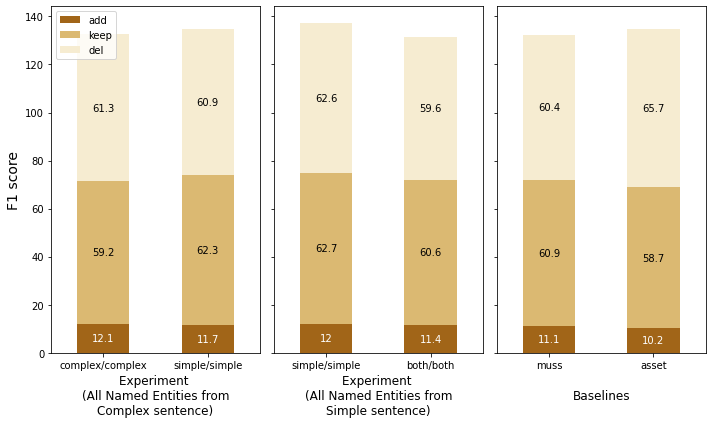

In [50]:

f, (ax, ax2,ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2,2, 2]}, figsize=(10, 6),sharey=True)

df_all_NE[0:2].plot(ax=ax,x='x_list',kind='bar', stacked=True, rot=0, xlabel='Class', ylabel='Count', color=final_clrs).legend(loc='upper left')
for index,c in enumerate(ax.containers):
    if index !=0:
      ax.bar_label(c, label_type='center')
    else:
      ax.bar_label(c, label_type='center',color='white')

ax.set_xlabel('Experiment \n(All Named Entities from\nComplex sentence)',fontsize=12)

df_all_NE[2:4].plot(ax=ax2,x='x_list',kind='bar', stacked=True,  rot=0, color=final_clrs,legend=False)
for index,c in enumerate(ax2.containers):
    if index !=0:
      ax2.bar_label(c, label_type='center')
    else:
      ax2.bar_label(c, label_type='center',color='white')

ax2.set_xlabel('Experiment \n(All Named Entities from\nSimple sentence)',fontsize=12)

df_all_NE[4:].plot(ax=ax3,x='x_list',kind='bar', stacked=True,  rot=0, color=final_clrs,legend=False)
for index,c in enumerate(ax3.containers):
    if index !=0:
      ax3.bar_label(c, label_type='center')
    else:
      ax3.bar_label(c, label_type='center',color='white')

# ax.legend(loc='upper right',bbox_to_anchor=(1.01,2,0,0),fontsize='large')
ax.set_ylabel('F1 score',fontsize=14)


ax3.set_xlabel('\nBaselines',fontsize=12)

plt.tight_layout()

plt.savefig('best_sari_ope.pdf',bbox_inches='tight')
plt.show()

## operation lexical simplification

In [51]:
!pip install matplotlib==3.4

In [52]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_asset', 'rb') as fp:
    asset_ope = pickle.load(fp)

with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_muss', 'rb') as fp:
    muss_ope = pickle.load(fp)

In [53]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_38_ABCD_new', 'rb') as fp:
  [sari_add_list,sari_keep_list,sari_del_list] = pickle.load(fp)


In [54]:
df = pd.DataFrame(np.array([  [round(x,1) for x in np.mean(np.array(sari_add_list),axis=0)] ,
[round(x,1) for x in np.mean(np.array(sari_keep_list),axis=0)] ,
[round(x,1) for x in np.mean(np.array(sari_del_list),axis=0)] ,
]).T, columns =['add', 'keep', 'del'], dtype = float)

df

,add,keep,del
0,11.1,59.3,58.0
1,11.2,59.2,59.2
2,11.1,58.6,60.6
3,11.3,58.2,61.7
4,11.5,57.8,62.5
5,11.5,57.5,63.1
6,11.4,57.1,63.5
7,11.4,57.0,64.1
8,6.7,31.6,69.4
9,6.1,27.6,69.4


In [55]:
x_list = [str(x) for x in range(7)]
x_list.extend(['all','all\nwords','all\nwords\nshuffled'])
df['x_list']=x_list
df

,add,keep,del,x_list
0,11.1,59.3,58.0,0
1,11.2,59.2,59.2,1
2,11.1,58.6,60.6,2
3,11.3,58.2,61.7,3
4,11.5,57.8,62.5,4
5,11.5,57.5,63.1,5
6,11.4,57.1,63.5,6
7,11.4,57.0,64.1,all
8,6.7,31.6,69.4,all\nwords
9,6.1,27.6,69.4,all\nwords\nshuffled


In [56]:
df_ref = pd.DataFrame( columns =['add', 'keep', 'del'], dtype = float)

In [57]:
df_ref.loc[0] =np.array([round(np.mean(muss_ope[0]),1),round(np.mean(muss_ope[1]),1),round(np.mean(muss_ope[2]),1)], dtype = float)#,

df_ref

,add,keep,del
0,11.1,60.9,60.4


In [58]:
df_ref.loc[1] =np.array([round(np.mean(asset_ope[0]),1),round(np.mean(asset_ope[1]),1),round(np.mean(asset_ope[2]),1)], dtype = float)#,

df_ref

,add,keep,del
0,11.1,60.9,60.4
1,10.2,58.7,65.7


In [59]:
df_ref.loc[2] =np.array([0.5,62.0,34.7], dtype = float)#,

df_ref

,add,keep,del
0,11.1,60.9,60.4
1,10.2,58.7,65.7
2,0.5,62.0,34.7


In [60]:
df_ref['x_list']=['muss','asset','all hard\nwords\nremoved']
df_ref

,add,keep,del,x_list
0,11.1,60.9,60.4,muss
1,10.2,58.7,65.7,asset
2,0.5,62.0,34.7,all hard\nwords\nremoved


In [61]:
final_clrs = []
clrs = sns.color_palette('BrBG')#BrBG,,RdBu,RdGy,RdYlBu,Spectral,YlGnBu,,tab20c
final_clrs = clrs
final_clrs

[(0.6313725490196078, 0.3951557093425605, 0.09573241061130335),
 (0.8572856593617839, 0.7257977700884274, 0.4471357170319107),
 (0.9636293733179546, 0.9237985390234525, 0.8185313341022683),
 (0.8299115724721262, 0.9294886582083814, 0.9152633602460593),
 (0.4615916955017304, 0.7748558246828146, 0.7299500192233758),
 (0.0878892733564014, 0.479123414071511, 0.44775086505190315)]

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


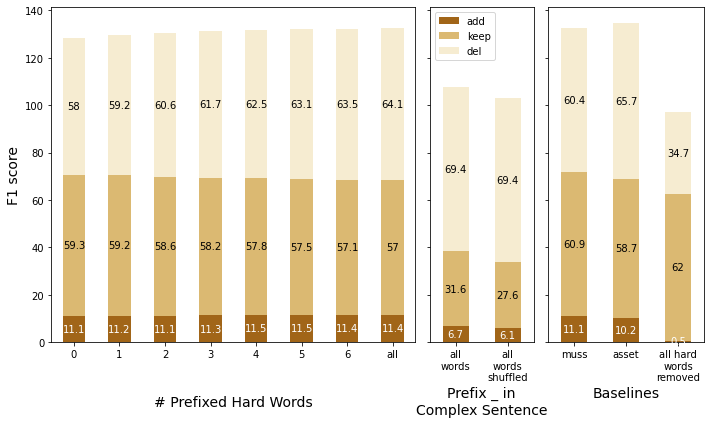

In [62]:

f, (ax, ax2,ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [7,2, 3]}, figsize=(10, 6),sharey=True)

df[0:8].plot(ax=ax,x='x_list',kind='bar', stacked=True, rot=0, xlabel='Class', ylabel='Count', color=final_clrs,legend=False)
for index,c in enumerate(ax.containers):
    if index !=0:
      ax.bar_label(c, label_type='center')
    else:
      ax.bar_label(c, label_type='center',color='white')

df[8:].plot(ax=ax2,x='x_list',kind='bar', stacked=True, rot=0, xlabel='Class', ylabel='Count', color=final_clrs).legend(loc='upper left')
for index,c in enumerate(ax2.containers):
    if index !=0:
      ax2.bar_label(c, label_type='center')
    else:
      ax2.bar_label(c, label_type='center',color='white')

df_ref.plot(ax=ax3,x='x_list',kind='bar', stacked=True,  rot=0, color=final_clrs,legend=False)
for index,c in enumerate(ax3.containers):
    if index !=0:
      ax3.bar_label(c, label_type='center')
    else:
      ax3.bar_label(c, label_type='center',color='white')


# ax.legend(loc='upper right',bbox_to_anchor=(1.01,2,0,0),fontsize='large')
ax.set_ylabel('F1 score',fontsize=14)
ax.set_xlabel('\n\n# Prefixed Hard Words',fontsize=14)

ax2.set_xlabel('Prefix _ in\nComplex Sentence',fontsize=14)
ax3.set_xlabel('Baselines',fontsize=14)

plt.tight_layout()

# plt.savefig('ls_ope.pdf',bbox_inches='tight')
plt.show()

In [63]:
cd /content

/content


## operation preserving + lexical simplification

In [80]:
test_data_dir_list

['/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_0NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_1NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_2NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_3NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_4NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_5NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_CERF_6NE/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_0CERF/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_1CERF/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_2CERF/test.complex',
 '/content/drive/MyDrive/muss/resources/datasets/asset_ABCD_NER_fix_NE_3CERF/tes

In [81]:
test_data_list

['asset.allCERF.0NE',
 'asset.allCERF.1NE',
 'asset.allCERF.2NE',
 'asset.allCERF.3NE',
 'asset.allCERF.4NE',
 'asset.allCERF.5NE',
 'asset.allCERF.6NE',
 'asset.allNE.0CERF',
 'asset.allNE.1CERF',
 'asset.allNE.2CERF',
 'asset.allNE.3CERF',
 'asset.allNE.4CERF',
 'asset.allNE.5CERF',
 'asset.allNE.6CERF',
 'asset.allNE.allCERF']

In [82]:

i = 40
generate_id_list = ['00','01','02','03','04']

In [83]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_model40', 'rb') as fp:
    [sari_add_list,sari_keep_list,sari_del_list] = pickle.load(fp)


In [84]:
with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_asset', 'rb') as fp:
    asset_ope = pickle.load(fp)

with open('/content/drive/MyDrive/muss/qualitative/SARI_ope_muss', 'rb') as fp:
    muss_ope = pickle.load(fp)

In [85]:
df = pd.DataFrame(np.array([  [round(x,1) for x in np.mean(np.array(sari_add_list),axis=0)] ,
[round(x,1) for x in np.mean(np.array(sari_keep_list),axis=0)] ,
[round(x,1) for x in np.mean(np.array(sari_del_list),axis=0)] ,
]).T, columns =['add', 'keep', 'del'], dtype = float)

df

,add,keep,del
0,9.7,46.7,63.9
1,10.6,51.9,65.5
2,10.9,55.6,66.0
3,11.1,57.8,66.1
4,11.3,59.0,66.3
5,11.4,59.9,66.3
6,11.5,60.3,66.2
7,11.6,61.6,64.9
8,11.6,61.4,65.6
9,11.4,60.9,65.6


In [86]:
line = pd.DataFrame({"add": 11.5, "keep": 60.6,'del':66.2}, index=[7])
line

,add,keep,del
7,11.5,60.6,66.2


In [87]:
df = pd.concat([df.iloc[:7], line, df.iloc[7:]]).reset_index(drop=True)
df

,add,keep,del
0,9.7,46.7,63.9
1,10.6,51.9,65.5
2,10.9,55.6,66.0
3,11.1,57.8,66.1
4,11.3,59.0,66.3
5,11.4,59.9,66.3
6,11.5,60.3,66.2
7,11.5,60.6,66.2
8,11.6,61.6,64.9
9,11.6,61.4,65.6


In [88]:
x_list = [str(x) for x in range(7)]
x_list.extend(['all'])
x_list.extend([str(x) for x in range(7)])
x_list.extend(['all'])
df['x_list']=x_list
df

,add,keep,del,x_list
0,9.7,46.7,63.9,0
1,10.6,51.9,65.5,1
2,10.9,55.6,66.0,2
3,11.1,57.8,66.1,3
4,11.3,59.0,66.3,4
5,11.4,59.9,66.3,5
6,11.5,60.3,66.2,6
7,11.5,60.6,66.2,all
8,11.6,61.6,64.9,0
9,11.6,61.4,65.6,1


In [89]:
df_ref = pd.DataFrame( columns =['add', 'keep', 'del'], dtype = float)

In [90]:
df_ref.loc[0] =np.array([round(np.mean(muss_ope[0]),1),round(np.mean(muss_ope[1]),1),round(np.mean(muss_ope[2]),1)], dtype = float)#,

df_ref

,add,keep,del
0,11.1,60.9,60.4


In [91]:
df_ref.loc[1] =np.array([round(np.mean(asset_ope[0]),1),round(np.mean(asset_ope[1]),1),round(np.mean(asset_ope[2]),1)], dtype = float)#,

df_ref

,add,keep,del
0,11.1,60.9,60.4
1,10.2,58.7,65.7


In [92]:
df_ref['x_list']=['muss','asset']
df_ref

,add,keep,del,x_list
0,11.1,60.9,60.4,muss
1,10.2,58.7,65.7,asset


In [93]:
final_clrs = []
clrs = sns.color_palette('BrBG')#BrBG,,RdBu,RdGy,RdYlBu,Spectral,YlGnBu,,tab20c
final_clrs = clrs
final_clrs

[(0.6313725490196078, 0.3951557093425605, 0.09573241061130335),
 (0.8572856593617839, 0.7257977700884274, 0.4471357170319107),
 (0.9636293733179546, 0.9237985390234525, 0.8185313341022683),
 (0.8299115724721262, 0.9294886582083814, 0.9152633602460593),
 (0.4615916955017304, 0.7748558246828146, 0.7299500192233758),
 (0.0878892733564014, 0.479123414071511, 0.44775086505190315)]

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


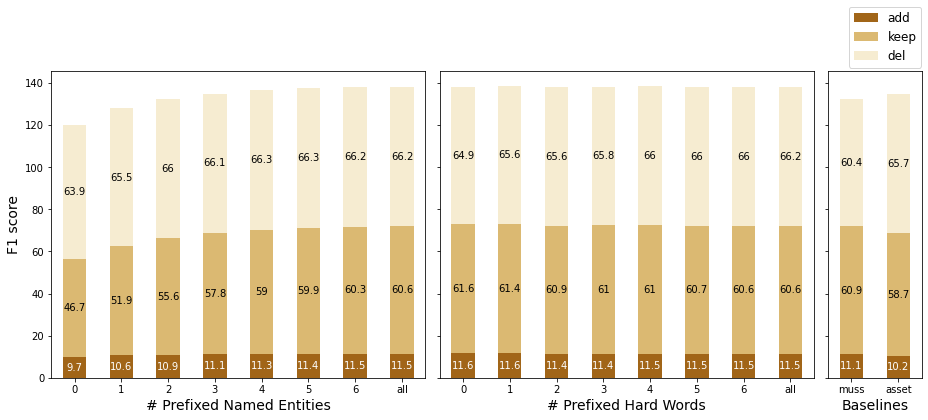

In [94]:

f, (ax, ax2,ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [8,8,2]}, figsize=(13, 6),sharey=True)

df[0:8].plot(ax=ax,x='x_list',kind='bar', stacked=True, rot=0, xlabel='Class', ylabel='Count', color=final_clrs,legend=False)
for index,c in enumerate(ax.containers):
    if index !=0:
      ax.bar_label(c, label_type='center')
    else:
      ax.bar_label(c, label_type='center',color='white')

df[8:].plot(ax=ax2,x='x_list',kind='bar', stacked=True, rot=0, xlabel='Class', ylabel='Count', color=final_clrs,legend=False)
for index,c in enumerate(ax2.containers):
    if index !=0:
      ax2.bar_label(c, label_type='center')
    else:
      ax2.bar_label(c, label_type='center',color='white')

df_ref.plot(ax=ax3,x='x_list',kind='bar', stacked=True,  rot=0, color=final_clrs,legend=False)
for index,c in enumerate(ax3.containers):
    if index !=0:
      ax3.bar_label(c, label_type='center')
    else:
      ax3.bar_label(c, label_type='center',color='white')


ax3.legend(loc='upper right',bbox_to_anchor=(1.06,1.23,0,0),fontsize='large')
ax.set_ylabel('F1 score',fontsize=14)
ax.set_xlabel('# Prefixed Named Entities',fontsize=14)

ax2.set_xlabel('# Prefixed Hard Words',fontsize=14)
ax3.set_xlabel('Baselines',fontsize=14)

plt.tight_layout()

# plt.savefig('pre_ls_ope.pdf',bbox_inches='tight')
plt.show()

In [95]:
cd /content

/content
